<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/Plots_%2B_subclass_%2B_ebv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Подгружаем необходимые библиотеки 

In [2]:
!pip install -q scikit-learn==0.22.1

     |████████████████████████████████| 7.0MB 6.5MB/s 


In [3]:
pip install pytorch-tabnet

In [4]:
import numpy as np
import pandas as pd

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [6]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

from pytorch_tabnet.tab_model import TabNetClassifier

from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

from time import time

In [7]:
import torch

#Загружаем данные, параметры

In [8]:
def data_preparation(X, y, c=10000, test_size = 0.8):

    X1_train, X1_test, y1_train, y1_test = train_test_split(X[y==1], y[y==1], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[y==2], y[y==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[y==3], y[y==3], test_size=test_size, random_state = 43)
    
    count = c
    count1 = c

    X_train, X_test = np.concatenate((X1_train[:count], X2_train[:count], X3_train[:count])), np.concatenate((X1_test[:count1], X2_test[:count1], X3_test[:count1]))
    y_train, y_test = np.concatenate((y1_train[:count], y2_train[:count], y3_train[:count])), np.concatenate((y1_test[:count1], y2_test[:count1], y3_test[:count1]))

    data = np.concatenate((X_train, y_train.reshape((len(y_train), 1))), axis=1)
    np.random.shuffle(data)

    datat = np.concatenate((X_test, y_test.reshape((len(y_test), 1))), axis=1)
    np.random.shuffle(datat)
    

    return data, datat

# Разделение данных

In [9]:
#pip install -q pandas==0.25.3

In [9]:
features_path = '/content/drive/MyDrive/Научная работа/Data/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl'

In [10]:
column = 'sdssdr16_r_cmodel'

In [11]:
features = pd.read_pickle(features_path)

In [12]:
sdss = [i for i in features if 'sdss' in i and 'decals' not in i and column not in i] 

In [13]:
decals = [i for i in features if 'decals' in i and 'sdss' not in i and 'psdr' not in i and column not in i] 

In [14]:
wise = [i for i in decals if 'Lw' in i and column not in i] 

In [15]:
ps = [i for i in features if 'psdr' in i and 'decals' not in i and column not in i] 

In [16]:
label = ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [17]:
f = {#"sdssdr16+wise_decals8tr": sdss+wise,
     "psdr2+wise_decals8tr": ps+wise,
     #"sdssdr16+all_decals8tr": sdss+decals,
     #"psdr2+all_decals8tr": ps+decals,
     #"decals8tr": decals,
     #"sdssdr16+psdr2+wise_decals8tr": sdss+ps+wise,
     "sdssdr16+psdr2+all_decals8tr": sdss+ps+decals}

In [78]:
df = pd.read_pickle('/content/drive/MyDrive/Научная работа/Data/Specific X-ray/05_all.gz_pkl', compression='gzip')

In [79]:
df = df[df['Fx']>0]

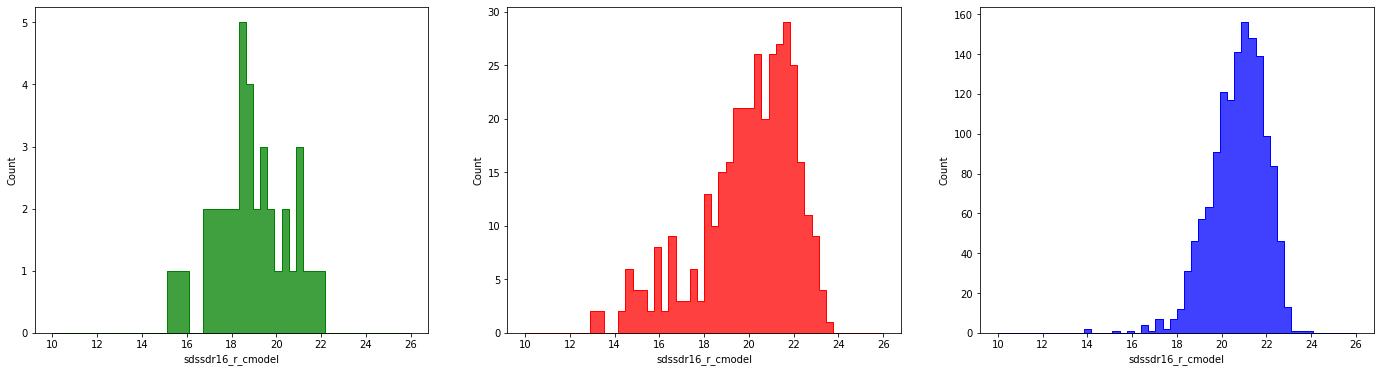

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(df[df['Label']==0]['sdssdr16_r_cmodel'], ax = ax1, bins = 50, color = 'g', element="step", binrange=(10, 26))
sns.histplot(df[df['Label']==2]['sdssdr16_r_cmodel'], ax = ax2, bins = 50, color = 'r', element="step", binrange=(10, 26))
sns.histplot(df[df['Label']==1]['sdssdr16_r_cmodel'], ax = ax3, bins = 50, color = 'b', element="step", binrange=(10, 26))

In [22]:
for i in df.columns:
  print(i)

objID
ra_x
dec_x
zspec
zspec_conf
zspec_source
class
subclass
class1
class2
origin
Fx
is_12-SDSSunWISE
u
g
r
i
z
Lw1
Lw2
uM
gM
rM
iM
zM
LabelQ
LabelG
LabelS
Label
nrow
ra_y
dec_y
__workxid__
ls_sep_input
ls_release
ls_brickid
ls_brickname
ls_objid
ls_brick_primary
ls_brightblob
ls_maskbits
ls_type
ls_ra
ls_dec
ls_ra_ivar
ls_dec_ivar
ls_bx
ls_by
ls_ebv
ls_mjd_min
ls_mjd_max
ls_ref_cat
ls_ref_id
ls_pmra
ls_pmdec
ls_parallax
ls_pmra_ivar
ls_pmdec_ivar
ls_parallax_ivar
ls_ref_epoch
ls_gaia_pointsource
ls_gaia_phot_g_mean_mag
ls_gaia_phot_g_mean_flux_over_error
ls_gaia_phot_g_n_obs
ls_gaia_phot_bp_mean_mag
ls_gaia_phot_bp_mean_flux_over_error
ls_gaia_phot_bp_n_obs
ls_gaia_phot_rp_mean_mag
ls_gaia_phot_rp_mean_flux_over_error
ls_gaia_phot_rp_n_obs
ls_gaia_phot_variable_flag
ls_gaia_astrometric_excess_noise
ls_gaia_astrometric_excess_noise_sig
ls_gaia_astrometric_n_obs_al
ls_gaia_astrometric_n_good_obs_al
ls_gaia_astrometric_weight_al
ls_gaia_duplicated_source
ls_gaia_a_g_val
ls_gaia_e_bp_min

In [18]:
def data_split(df_all, column='sdssdr16_r_cmodel', label='Label', balance=True):
  df = df_all.sort_values(column)
  def split(df_loc, c=9000):
    data = df_loc.drop(['LabelQ', 'LabelG', 'LabelS', 'Label'], axis = 1).values
    data1 = data[::2]
    data2 = data[1::2]
    np.random.shuffle(data1)
    np.random.shuffle(data2)
    return data1[:c//2], data2[:c//2]

  def train_test(X1, X2, X3, test_size=0.1):
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, 1*np.ones([len(X1), 1]), test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, 2*np.ones([len(X2), 1]), test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3, 3*np.ones([len(X3), 1]), test_size=test_size, random_state = 43)

    X_train, X_test = np.concatenate((X1_train, X2_train, X3_train)), np.concatenate((X1_test, X2_test, X3_test))
    y_train, y_test = np.concatenate((y1_train, y2_train, y3_train)), np.concatenate((y1_test, y2_test, y3_test))
        
    train = np.concatenate((X_train, y_train.rashape((len(X_train), 1))))
    test = np.concatenate((X_test, y_test.rashape((len(X_test), 1))))

    return train, test
    
  df_s = df[df[label]==0]
  df_q = df[df[label]==1]
  df_g = df[df[label]==2]

  if balance:
    c = len(df_g)#np.min((len(df_s), len(df_q), len(df_g)))

  else:
    c = 17000



  X1_s , X2_s = split(df_s, c)
  X1_q , X2_q = split(df_q, c)
  X1_g , X2_g = split(df_g, c)


  X1 = np.concatenate((np.concatenate((X1_s, 1*np.ones([len(X1_s), 1])), axis=1),
                       np.concatenate((X1_q, 2*np.ones([len(X1_q), 1])), axis=1),
                       np.concatenate((X1_g, 3*np.ones([len(X1_g), 1])), axis=1)),
                      axis=0)
  X2 = np.concatenate((np.concatenate((X2_s, 1*np.ones([len(X2_s), 1])), axis=1),
                       np.concatenate((X2_q, 2*np.ones([len(X2_q), 1])), axis=1),
                       np.concatenate((X2_g, 3*np.ones([len(X2_g), 1])), axis=1)),
                      axis=0)
  
  np.random.shuffle(X1)
  np.random.shuffle(X2)

  return X1, X2#train1, train2, test1, test2

In [19]:
def data_open(path, features):
    classes = {'STAR': 1, 'QSO':2, 'GALAXY':3}
    with gzip.open(path, 'rb') as f:
      df = pickle.load(f)
    df = df[features + ['class']].dropna()
    X = df[features].values
    y = df.replace({'class':classes}, inplace = True)['class'].values
    return X, y

In [20]:
def scor(y_test, y_pred):
  return accuracy_score(y_test, y_pred)

lgb_reg_params = {
    'min_child_samples':hp.randint('min_child_samples', 50)+1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'num_leaves' :      hp.randint('num_leaves', 100)+10,
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 0.99),
    'n_estimators':     1000
}
lgb_fit_params = {
    'early_stopping_rounds': 50,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['score'] = lambda y, pred: -accuracy_score(y, pred)


rf_reg_params = {
    'min_samples_leaf': hp.randint('min_samples_leaf', 20)+1,
    'min_samples_split':hp.uniform('min_samples_split', 0.001, 0.1),
    #'max_features':     hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    #'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'n_estimators':     hp.randint('n_estimators', 800)+100
}
rf_fit_params = {
}
rf_para = dict()
rf_para['reg_params'] = rf_reg_params
rf_para['fit_params'] = rf_fit_params
rf_para['score'] = lambda y, pred: -accuracy_score(y, pred)

tabnet_reg_params = {
    'n_d' :              8,
    'n_a' :              8,
    'n_shared':          hp.randint('n_shared', 3)+1,
    'n_independent':     hp.randint('n_independent', 3)+1,
    'n_steps' :          hp.randint('n_steps', 3)+3,
    'gamma' :            hp.uniform('gamma', 1.0, 3.0),
    'lambda_sparse' :    hp.uniform('lambda_sparse', 0.0, 0.01),
    'optimizer_params' : dict(lr=2e-2),
    'scheduler_params' : {"step_size":200, "gamma":0.95},
    'scheduler_fn' :     torch.optim.lr_scheduler.StepLR,
    'mask_type' :       'entmax'
}

tabnet_fit_params = {
    'max_epochs' : 2000, 
    'patience' : 20,
    'batch_size' : 1024,
    'virtual_batch_size' : 128,
    'num_workers' : 0,
    'weights' : 1,
    'drop_last' : False,
    #'from_unsupervised' : unsupervised_model
}
tabnet_para = dict()
tabnet_para['reg_params'] = tabnet_reg_params
tabnet_para['fit_params'] = tabnet_fit_params
tabnet_para['score'] = lambda y, pred: -accuracy_score(y, pred)

In [21]:
class HPOpt(object):

    def __init__(self, X, y, cv=3):
        self.X = X
        self.y = y
        self.cv = cv
        #print('init')

    def process(self, fn_name, space, trials, algo, max_evals):
        #print('in process')
        fn = getattr(self, fn_name)
        try:
            #print('try')
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
            #print('i can')
        except Exception as e:
            print({'status': STATUS_FAIL,
                    'exception': str(e)})
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def rf_reg(self, para):
        reg = RandomForestClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMClassifier(**para['reg_params'])
        if self.cv>1:
          return self.train_cv_gb(reg, para)
        return self.train_reg(reg, para)

    def tabnet_reg(self, para):
        #print('class')
        reg = TabNetClassifier(**para['reg_params'])
        #print('end class')
        if self.cv>1:
          return self.train_cv_tn(reg, para)
        return self.train_reg(reg, para)


    def train_reg(self, reg, para):
        if len(para['fit_params'])>0:
            #print('start')
            reg.fit(self.X, self.y,
                  eval_set=[(self.X, self.y), (self.X, self.y)],
                  **para['fit_params'])
        else:
            reg.fit(self.X, self.y)
        pred = reg.predict(self.X)
        loss = para['score'](self.y, pred)
        return {'loss': loss, 'status': STATUS_OK}

    def train_cv_tn(self, reg, para):
        kf = KFold(n_splits=self.cv, shuffle=False)
        loss = 0 
        for train, test in kf.split(self.X):
            #print('start', type(train[0]), type(test[0]), type(self.y[0]), type(self.X))
            if len(para['fit_params'])>0:
                reg = TabNetClassifier(**para['reg_params'])
                reg.fit(self.X[train], self.y[train],
                      eval_set=[(self.X[train], self.y[train]), (self.X[test], self.y[test])],
                      **para['fit_params'])
            else:
                reg.fit(self.X[train], self.y[train])
            #print('pred')
            pred = reg.predict(self.X[test])
            score = para['score'](self.y[test], pred)
            loss += score

        loss=loss/self.cv
        return {'loss': loss, 'status': STATUS_OK}

    def train_cv_gb(self, reg, para):
        kf = KFold(n_splits=self.cv, shuffle=False)
        loss = 0 
        for train, test in kf.split(self.X):
            #print('start', type(train[0]), type(test[0]), type(self.y[0]), type(self.X))
            if len(para['fit_params'])>0:
                reg = lgb.LGBMClassifier(**para['reg_params'])
                reg.fit(self.X[train], self.y[train],
                      eval_set=[(self.X[train], self.y[train]), (self.X[test], self.y[test])],
                      **para['fit_params'])
            else:
                reg.fit(self.X[train], self.y[train])
            #print('pred')
            pred = reg.predict(self.X[test])
            score = para['score'](self.y[test], pred)
            loss += score

        loss=loss/self.cv
        return {'loss': loss, 'status': STATUS_OK}


In [22]:
acc = pd.DataFrame(index=['acc'])

In [23]:
#acc

# Получение моделей на всей выборке 

## На рентгеновском датасете

In [ ]:
import joblib
for overview in f.keys():
  print(overview)
  if 'sdss' in overview:
    column = 'sdssdr16_r_psf'
  elif 'psdr' in overview:
    column='psdr2_r_psf'
  else:
    column='decals8tr_r'
  data1, data2 = data_split(df[f[overview]+label].dropna(), column=column, balance=False)
  X1, y1 = data1[:,:-1], data1[:,-1].astype('int')
  X2, y2 = data2[:,:-1], data2[:,-1].astype('int')
  X = np.concatenate((X1, X2))
  y = np.concatenate((y1, y2))
  robust = RobustScaler()

  X_train_norm = robust.fit_transform(X)
  X_test_norm = robust.transform(X)
  y_train = y
  y_test = y

  obj = HPOpt(X_train_norm, y_train, cv=3)
  lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
  print(lgb_opt)
  gb = lgb.LGBMClassifier( 
                            **{'colsample_bytree': lgb_opt[0]['colsample_bytree'],
                              'min_child_samples': lgb_opt[0]['min_child_samples']+1,
                              'min_child_weight': lgb_opt[0]['min_child_weight'],
                              'num_leaves': lgb_opt[0]['num_leaves']+10,
                              'n_estimators': 1000
                              }
                          )
  t = time()
  gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[-500:], y_train[-500:])],  **lgb_fit_params)
  print(time()-t)
  gb_test_acc = accuracy_score(y_test[-500:], gb.predict(X_test_norm[-500:]))
  acc[overview] = gb_test_acc
  joblib.dump(gb, '/content/drive/MyDrive/Научная работа/Data/X-ray/gb/model_'+overview+'.pkl')
  joblib.dump(f[overview], '/content/drive/MyDrive/Научная работа/Data/X-ray/gb/features_'+overview+'.pkl')
  joblib.dump(robust, '/content/drive/MyDrive/Научная работа/Data/X-ray/gb/'+overview+'_robust_for_gb.pkl')


In [ ]:
acc

In [ ]:
import joblib
for overview in f.keys():
   column = 'sdssdr16_r_cmodel'

  data1, data2 = data_split(df[f[overview]+label].dropna(), column=column, balance=False)
  X1, y1 = data1[:,:-1], data1[:,-1].astype('int')
  X2, y2 = data2[:,:-1], data2[:,-1].astype('int')
  X_train = X_test = np.concatenate((X1, X2))
  y_train = y_test = np.concatenate((y1, y2)).astype('int')
  

  obj = HPOpt(X_train, y_train, cv=2)
  tn_opt = obj.process(fn_name='tabnet_reg', space=tabnet_para, trials=Trials(), algo=tpe.suggest, max_evals=5)
  print(tn_opt)
  tn = TabNetClassifier( 
                         **{'n_d' :              8,
                            'n_a' :              8,
                            'n_shared':          tn_opt[0]['n_shared']+1,
                            'n_independent':     tn_opt[0]['n_independent']+1,
                            'n_steps' :          tn_opt[0]['n_steps']+3,
                            'gamma' :            tn_opt[0]['gamma'],
                            'lambda_sparse' :    tn_opt[0]['lambda_sparse'],
                            'optimizer_params' : dict(lr=2e-2),
                            'scheduler_params' : {"step_size":200, "gamma":0.95},
                            'scheduler_fn' :     torch.optim.lr_scheduler.StepLR,
                            'mask_type' :       'entmax'}
                          )
  t = time()
  tn.fit(X_train[:-500], y_train[:-500], eval_set=[(X_train[:-500], y_train[:-500]), (X_train[-500:], y_train[-500:])],  **tabnet_fit_params)
  print(time()-t)
  tn_test_acc = accuracy_score(y_test[-500:], tn.predict(X_test[-500:]))
  print(tn_test_acc)
  joblib.dump(tn, '/content/drive/MyDrive/Научная работа/Data/X-ray/tn/model_'+overview+'.pkl')
  joblib.dump(f[overview], '/content/drive/MyDrive/Научная работа/Data/X-ray/gb/features_'+overview+'.pkl')

## На большом датасете

In [ ]:
column = 'sdssdr16_r_cmodel'

In [ ]:
import gzip
import pickle
classes = {'STAR': 1, 'QSO':2, 'GALAXY':3}


path = '/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_0/cv0.gz_pkl'
with gzip.open(path, 'rb') as fin:
    df1 = pickle.load(fin)
    df1 = df1[[column] + features + ['class']].dropna()

path = '/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_1/cv1.gz_pkl'
with gzip.open(path, 'rb') as fin:
    df2 = pickle.load(fin)
    df2= df2[[column] + features + ['class']].dropna()

In [ ]:
df1.to_csv('/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_0/cv0.csv', index=False)
df2.to_csv('/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_1/cv1.csv', index=False)

In [ ]:
df1.replace({'class':classes}, inplace = True)
df2.replace({'class':classes}, inplace = True)

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_0/cv0.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_1/cv1.csv')

In [ ]:
df1

sdssdr16_r_cmodel  sdssdr16_u_psf  ...  sdssdr16_z_cmodel-decals8tr_z  class
0               16.824337       21.455454  ...                       0.245783      3
1               13.692711       18.601305  ...                      -0.000922      3
2               16.642016       19.744036  ...                       0.033045      3
3               15.300124       20.341056  ...                       0.919084      3
4               17.380912       19.755114  ...                      -0.168231      3
...                   ...             ...  ...                            ...    ...
650798          22.998939       23.903951  ...                      -0.389371      1
650799          23.012422       20.590472  ...                       0.063710      1
650800          23.180539       22.605940  ...                       1.372658      1
650801          23.418319       20.947137  ...                      -0.530340      1
650802          23.486469       23.616061  ...                      -2.218059      1

[650803 rows x 67 columns]

In [ ]:
df2

sdssdr16_r_cmodel  sdssdr16_u_psf  ...  sdssdr16_z_cmodel-decals8tr_z  class
0               14.495915       19.819077  ...                       0.026564      3
1               17.502530       20.838590  ...                       0.122223      3
2               22.521217       21.536272  ...                      -0.202841      3
3               17.586410       20.139506  ...                       0.224106      3
4               12.352081       18.714715  ...                       0.165234      3
...                   ...             ...  ...                            ...    ...
654349          23.188235       19.898474  ...                       0.631774      1
654350          23.427587       24.049108  ...                      -1.176075      1
654351          23.505259       24.902663  ...                      -1.495594      1
654352          23.611009       19.389092  ...                       0.264610      1
654353          24.480752       22.704783  ...                      -2.672473      1

[654354 rows x 67 columns]

In [ ]:
for overview in f.keys():
  X1, y1 = df1[f[overview]].values, df1['class'].values #.replace({'class':classes}, inplace = True)
  X2, y2 = df2[f[overview]].values, df2['class'].values
  
  data, datat = data_preparation(np.concatenate((X1, X2)), np.concatenate((y1, y2)), test_size=0.5)
  X1, y1 = data[:, :-1], data[:, -1].astype('int')
  X2, y2 = datat[:, :-1], datat[:, -1].astype('int')
  
  X = np.concatenate((X1, X2))
  y = np.concatenate((y1, y2))
  print(X.shape, y.shape)

  robust = RobustScaler()

  X_train_norm = robust.fit_transform(X)
  X_test_norm = robust.transform(X)
  y_train = y
  y_test = y

  obj = HPOpt(X_train_norm, y_train, cv=2)
  lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=10)
  print(lgb_opt)
  gb = lgb.LGBMClassifier( 
                            **{'colsample_bytree': lgb_opt[0]['colsample_bytree'],
                              'min_child_samples': lgb_opt[0]['min_child_samples']+1,
                              'min_child_weight': lgb_opt[0]['min_child_weight'],
                              'num_leaves': lgb_opt[0]['num_leaves']+10,
                              'n_estimators': 1000
                              }
                          )
  t = time()
  gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[-500:], y_train[-500:])],  **lgb_fit_params)
  print(time()-t)
  gb_test_acc = accuracy_score(y_test[-500:], gb.predict(X_test_norm[-500:]))
  acc[overview] = gb_test_acc
  joblib.dump(gb, '/content/drive/MyDrive/Научная работа/Data/X-ray/gb_big/model_'+overview+'_big.pkl')
  joblib.dump(f[overview], '/content/drive/MyDrive/Научная работа/Data/X-ray/gb_big/features_'+overview+'_big.pkl')
  joblib.dump(robust, '/content/drive/MyDrive/Научная работа/Data/X-ray/gb_big/'+overview+'_robust_for_gb_big.pkl')


(60000, 20) (60000,)
100%|██████████| 10/10 [01:36<00:00,  9.70s/it, best loss: -0.9709666666666668]
({'colsample_bytree': 0.4760538579849609, 'min_child_samples': 41, 'min_child_weight': 0.34942339260626254, 'num_leaves': 50}, <hyperopt.base.Trials object at 0x7fec85df8e50>)
5.721895456314087
(60000, 19) (60000,)
100%|██████████| 10/10 [01:38<00:00,  9.89s/it, best loss: -0.9715666666666667]
({'colsample_bytree': 0.6361751860249435, 'min_child_samples': 27, 'min_child_weight': 0.4214330886991654, 'num_leaves': 31}, <hyperopt.base.Trials object at 0x7fec8481cfd0>)
4.200650930404663
(60000, 26) (60000,)
100%|██████████| 10/10 [01:53<00:00, 11.34s/it, best loss: -0.9778166666666667]
({'colsample_bytree': 0.28095654401228476, 'min_child_samples': 47, 'min_child_weight': 0.11954991086780095, 'num_leaves': 32}, <hyperopt.base.Trials object at 0x7fec83fb7ad0>)
5.713337421417236
(60000, 25) (60000,)
100%|██████████| 10/10 [01:37<00:00,  9.77s/it, best loss: -0.9759833333333334]
({'colsample_b

In [ ]:
acc

sdssdr16+wise_decals8tr  ...  sdssdr16+psdr2+all_decals8tr
acc                    0.974  ...                         0.982

[1 rows x 7 columns]

In [ ]:
acc_tn = pd.DataFrame(index=['acc'])

In [ ]:
for overview in f.keys():
  X1, y1 = df1[f[overview]].values, df1['class'].values #.replace({'class':classes}, inplace = True)
  X2, y2 = df2[f[overview]].values, df2['class'].values
  
  data, datat = data_preparation(np.concatenate((X1, X2)), np.concatenate((y1, y2)), c=30000, test_size=0.5)
  X1, y1 = data[:, :-1], data[:, -1].astype('int')
  X2, y2 = datat[:, :-1], datat[:, -1].astype('int')
  
  X = np.concatenate((X1, X2))
  y = np.concatenate((y1, y2))
  X_train = X_test = X
  y_train = y_test = y

  obj = HPOpt(X_train, y_train, cv=2)
  tn_opt = obj.process(fn_name='tabnet_reg', space=tabnet_para, trials=Trials(), algo=tpe.suggest, max_evals=5)
  print(tn_opt)
  tn = TabNetClassifier( 
                         **{'n_d' :              8,
                            'n_a' :              8,
                            'n_shared':          tn_opt[0]['n_shared']+1,
                            'n_independent':     tn_opt[0]['n_independent']+1,
                            'n_steps' :          tn_opt[0]['n_steps']+3,
                            'gamma' :            tn_opt[0]['gamma'],
                            'lambda_sparse' :    tn_opt[0]['lambda_sparse'],
                            'optimizer_params' : dict(lr=2e-2),
                            'scheduler_params' : {"step_size":200, "gamma":0.95},
                            'scheduler_fn' :     torch.optim.lr_scheduler.StepLR,
                            'mask_type' :       'entmax'}
                          )
  t = time()
  tn.fit(X_train[:-500], y_train[:-500], eval_set=[(X_train[:-500], y_train[:-500]), (X_train[-500:], y_train[-500:])],  **tabnet_fit_params)
  print(time()-t)
  tn_test_acc = accuracy_score(y_test[-500:], tn.predict(X_test[-500:]))
  acc_tn[overview] = tn_test_acc
  print(tn_test_acc)
  joblib.dump(tn, '/content/drive/MyDrive/Научная работа/Data/X-ray/tn_big/model_'+overview+'_big.pkl')
  joblib.dump(f[overview], '/content/drive/MyDrive/Научная работа/Data/X-ray/tn_big/features_'+overview+'_big.pkl')

Device used : cpu
epoch 0  | loss: 0.41092 | val_0_accuracy: 0.57684 | val_1_accuracy: 0.57662 |  0:00:15s
epoch 1  | loss: 0.16492 | val_0_accuracy: 0.76226 | val_1_accuracy: 0.76483 |  0:00:31s
epoch 2  | loss: 0.13584 | val_0_accuracy: 0.93924 | val_1_accuracy: 0.94132 |  0:00:46s
epoch 3  | loss: 0.12991 | val_0_accuracy: 0.96512 | val_1_accuracy: 0.9664  |  0:01:02s
epoch 4  | loss: 0.11777 | val_0_accuracy: 0.97058 | val_1_accuracy: 0.97127 |  0:01:17s
epoch 5  | loss: 0.1142  | val_0_accuracy: 0.97168 | val_1_accuracy: 0.9725  |  0:01:33s
epoch 6  | loss: 0.11383 | val_0_accuracy: 0.96722 | val_1_accuracy: 0.96913 |  0:01:48s
epoch 7  | loss: 0.11278 | val_0_accuracy: 0.97051 | val_1_accuracy: 0.97212 |  0:02:04s
epoch 8  | loss: 0.10379 | val_0_accuracy: 0.97259 | val_1_accuracy: 0.97379 |  0:02:20s
epoch 9  | loss: 0.10468 | val_0_accuracy: 0.97318 | val_1_accuracy: 0.97404 |  0:02:35s
epoch 10 | loss: 0.103   | val_0_accuracy: 0.97427 | val_1_accuracy: 0.9754  |  0:02:51s
epo

In [ ]:
acc_tn

# Построение графиков

In [18]:
def choseAcc_2cv(X1, y1, X2, y2, model1, model2, n_split, robust1, robust2, function=f1_score, proba=False, lit=50, norm=True, my_norm=1000):#accuracy_score): n_features=0,
  acc = function
  one = n_split <= 1

  def get_pred(X, y, model, r1, r2, robust):
    ind = (X[:, 0]>=r1) & (X[:, 0]<= r2)
    
    if one:
      test = X[:, 1:]
      yt = y
    else:
      X = X[ind]
      y = y[ind]

      if norm:
        size = np.min((np.sum(y==1), np.sum(y==3), np.sum(y==2))) #для уравновешивания классов
      else:
        size = np.max((np.sum(y==1), np.sum(y==3), np.sum(y==2)))
      if size < lit:
          return [0], [0], [0]

      if not norm:
        size = my_norm//n_split
      test = np.concatenate((X[y==1][:size][:, 1:], X[y==2][:size][:, 1:], X[y==3][:size][:, 1:]))
      yt = np.concatenate((y[y==1][:size], y[y==2][:size], y[y==3][:size]))

    print(test.shape)

    if robust is not None:
      test = robust.transform(test)

    if proba:
      return yt, model.predict_proba(test), ind
    return yt, model.predict(test), ind

  if not one:
    q = np.linspace(0, 1, num=n_split+1)
    feature_q = np.quantile(np.concatenate((X1, X2))[:, 0], q)
  else:
    feature_q = [np.min(X1[:, 0]), np.max(X1[:, 0])]

  print('QQQQ', feature_q)

  Acc = []
  feature = []
  r0 = feature_q[0]

  for i in range(n_split):

    ind1 = 0;
    ind2 = 0;

    r1 = feature_q[i+1]
    print(r0, r1)
    print(y1[0])
    yt1, yp1, ind1 = get_pred(X1, y1, model1, r0, r1, robust1)
    if not one:
      yt2, yp2, ind2 = get_pred(X2, y2, model2, r0, r1, robust2)
      if (len(yt1) == 1 or len(yt2) == 1):
        print('continue')
        continue
      print(len(yt1), len(yt2))
      y_true = np.concatenate((yt1, yt2))
      y_pred = np.concatenate((yp1, yp2))
    else:
      y_true = yt1
      y_pred = yp1

    Acc.append(acc(y_true, y_pred))
    feature.append(np.mean(np.concatenate((X1[ind1][:, 0], X2[ind2][:, 0]))) if not one else np.mean((r0, r1)))
    r0 = r1
   
  return Acc, feature

In [19]:
def SubClass_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=None, N=5):
  def rec(y_true, y_pred):
    from sklearn.metrics import recall_score

    y_pred = (y_pred != 1)*1 + 1
    return recall_score(y_true, y_pred)
  cl = np.array([b'LT', b'C', b'M', b'K', b'G', b'F', b'A', b'WD', b'OB'], dtype=object)
  plt.figure(figsize=(10, 10))
  #lab =['S', 'Q', 'G']
  lines = []
  labels = []
  clr = ['aqua', 'skyblue', 'paleturquoise', 'lemonchiffon', 'yellow', 'orange', 'red', 'darkred', 'chocolate']
  j = 0 
  for i in reversed(cl):
    print(i)
    ind1 = subclass1 == i
    ind2 = subclass2 == i
    print(X1[ind1].shape, X2[ind2].shape)
    acc, r = choseAcc_2cv(X1[ind1], y1[ind1], X2[ind2], y2[ind2], model1, model2, N, robust1, robust2, function=rec, proba=False, lit=50, norm=False, my_norm=13000)
    acc = np.array(acc).T
    l, = plt.plot(r, acc, color=clr[j], lw=2)
    lines.append(l)
    labels.append(f'SubClass = {i}')
    j += 1

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel(column)
  plt.xlim(15.5, 24)
  plt.ylim(0.0, 1.01)
  plt.ylabel('Recall')
  plt.title('Recall for SubClass')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
  if file_name is not None:
    plt.savefig(file_name+'Recall_subclass.png')
  plt.show()

In [20]:
def EBV_STAR_plot(X1, y1, X2, y2, ebv1, ebv2, model1, model2, robust1, robust2, column, file_name=None, N=5):
  def rec(y_true, y_pred):
    from sklearn.metrics import recall_score

    y_pred = (y_pred != 1)*1 + 1
    print(y_true, y_pred)
    return recall_score(y_true, y_pred)
  cl = np.array((0.0, 0.1, 0.2, 0.3, 10))
  plt.figure(figsize=(10, 10))
  #lab =['S', 'Q', 'G']
  lines = []
  labels = []
  clr = ['aqua', 'skyblue', 'paleturquoise', 'lemonchiffon', 'yellow', 'orange', 'red', 'darkred', 'chocolate']
  j = 0 
  for i in range(len(cl)-1):
    print(cl[i])
    ind1 = (ebv1 >= cl[i]) & (ebv1 <= cl[i+1]) & (y1 == 1)
    ind2 = (ebv1 >= cl[i]) & (ebv1 <= cl[i+1]) & (y2 == 1)
    print(X1[ind1].shape, X2[ind2].shape)
    acc, r = choseAcc_2cv(X1[ind1], y1[ind1], X2[ind2], y2[ind2], model1, model2, N, robust1, robust2, function=rec, proba=False, lit=50, norm=False, my_norm=13000)
    print('acc and r', acc, r)
    acc = np.array(acc).T
    l, = plt.plot(r, acc, color=clr[j], lw=2)
    lines.append(l)
    lab = f'{cl[i]} <= Ebv <= {cl[i+1]}' if cl[i+1] < 0.6 else f'Ebv = {cl[i]} and more'
    labels.append(lab)
    j += 1

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel(column)
  plt.xlim(10, 20)
  plt.ylim(0.8, 1.01)
  
  plt.ylabel('Recall')
  plt.title('Recall for EBV')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
  if file_name is not None:
    plt.savefig(file_name+'Recall_ebv.png')
  plt.show()

In [21]:
def ZG_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=None, N=3):
  def rec(y_true, y_pred):
    from sklearn.metrics import recall_score
    y_pred = (y_pred == 3)*1 + 2
    return recall_score(y_true, y_pred, pos_label=3)
  cl = np.array((0.0, 0.2, 0.4, 0.6, 10))
  #q = np.linspace(0, 1, num=5)
  #cl = np.quantile(np.concatenate((subclass1, subclass2)), q)
  plt.figure(figsize=(10, 10))
  #lab =['S', 'Q', 'G']
  lines = []
  labels = []
  clr = ['aqua', 'skyblue', 'yellow', 'orange', 'red', 'darkred']
  j = 0 
  for i in range(len(cl)-1):
    ind1 = (subclass1 >= cl[i]) & (subclass1 <= cl[i+1]) & (y1 == 3)
    ind2 = (subclass2 >= cl[i]) & (subclass2 <= cl[i+1]) & (y2 == 3)

    print(X1[ind1].shape, X2[ind2].shape)
    acc, r = choseAcc_2cv(X1[ind1], y1[ind1], X2[ind2], y2[ind2], model1, model2, N, robust1, robust2, function=rec, proba=False, lit=50, norm=False, my_norm=13000)
    acc = np.array(acc).T
    l, = plt.plot(r, acc, color=clr[j], lw=2)
    lines.append(l)
    labels.append(f'{cl[i]} <= zspec <= {cl[i+1]}')
    j += 1

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel(column)
  plt.xlim(15.5, 24)
  plt.ylim(0.7, 1.01)
  plt.ylabel('Recall')
  plt.title('Recall for zspec of GALAXY')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
  if file_name is not None:
    plt.savefig(file_name+'Recall_zspec_of_GALAXY.png')
  plt.show()

In [22]:
def ZQ_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=None, N=5):
  def rec(y_true, y_pred):
    from sklearn.metrics import recall_score
    y_pred = (y_pred == 2)*1 + 1
    return recall_score(y_true, y_pred, pos_label=2)
  cl = np.array((0.0, 1.0, 2.0, 3.0, 10))
  plt.figure(figsize=(10, 10))
  #lab =['S', 'Q', 'G']
  lines = []
  labels = []
  clr = ['aqua', 'skyblue', 'yellow', 'orange', 'red', 'darkred']
  j = 0 
  for i in range(len(cl)-1):
    ind1 = (subclass1 >= cl[i]) & (subclass1 <= cl[i+1]) & (y1 == 2)
    ind2 = (subclass2 >= cl[i]) & (subclass2 <= cl[i+1]) & (y2 == 2)

    print(X1[ind1].shape, X2[ind2].shape)
    acc, r = choseAcc_2cv(X1[ind1], y1[ind1], X2[ind2], y2[ind2], model1, model2, N, robust1, robust2, function=rec, proba=False, lit=50, norm=False, my_norm=13000)
    acc = np.array(acc).T
    l, = plt.plot(r, acc, color=clr[j], lw=2)
    lines.append(l)
    labels.append(f'{cl[i]} <= zspec <= {cl[i+1]}')
    j += 1

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel(column)
  #plt.xlim(, 24)
  plt.ylim(0.7, 1.01)
  plt.ylabel('Recall')
  plt.title('Recall for zspec of QSO')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
  if file_name is not None:
    plt.savefig(file_name+'Recall_zspec_of_QSO.png')
  plt.show()

In [23]:
def F1_plot_class(X1, y1, X2, y2, gb1, gb2, robust1, robust2, column, file_name=None, N=5):
  def F1(y_true, y_pred):
    from sklearn import metrics
    return metrics.f1_score(y_true, y_pred, average=None)
  acc, r = choseAcc_2cv(X2, y2, X1, y1, gb1, gb2, N, robust1, robust2, F1, lit= 50 if N < 6 else 100)
  acc = np.array(acc).T
  plt.figure(figsize=(10, 10))
  lab =['S', 'Q', 'G']
  lines = []
  labels = []
  clr = ['skyblue', 'red', 'greenyellow', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'lime', 'springgreen', 'aquamarine', 'aqua',  'lightskyblue']
  for j in range(3):
    l, = plt.plot(r, acc[j], color=clr[j], lw=2)
    lines.append(l)
    labels.append(lab[j])


  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel(column)
  plt.xlim(15.5, 23)
  plt.ylim(0.5, 1.01)
  plt.ylabel('F1')
  plt.title('F1')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
  if file_name is not None:
    plt.savefig(file_name+'F1.png')
  plt.show()

In [24]:
def Prediction_Recall_plot(X1, y1, X2, y2, gb1, gb2, robust1, robust2, column, file_name=None, N=4):
  from sklearn.preprocessing import label_binarize
  from sklearn.metrics import precision_recall_curve

  classes = {1: 'S', 2: 'Q', 3: 'G'}

  def Pres_Rec(y_true, y_pred_proba):
    classes = [1, 2, 3]
    Y = label_binarize(y_true, classes=classes)
    precision, recall, _ = precision_recall_curve(Y.ravel(), 
                                                  y_pred_proba.ravel())   
    return [precision, recall]

  def Pres_Rec_class(y_true, y_pred_proba):
    classes = [1, 2, 3]
    Y = label_binarize(y_true, classes=classes)
    precision, recall = dict(), dict()
    for i in classes:
      precision[i], recall[i], _ = precision_recall_curve(Y[:, i-1],
                                                          y_pred_proba[:, i-1])  
    return [precision, recall]

  
  acc, r = choseAcc_2cv(X2, y2, X1, y1, gb1, gb2, N, robust1, robust2, function=Pres_Rec, proba=True, lit= 50 if N < 6 else 100)

  if (N==1) and (file_name is not None):
    acc = np.array(acc)
    np.savetxt(file_name+'Precision_Recall_micro.txt', acc[0])

  plt.figure(figsize=(10, 10))
  lab = r
  lines = []
  labels = []
  clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']
  for j, r_bin in enumerate(lab):
    l, = plt.plot(acc[j][1], acc[j][0], color=clr[j], lw=2)
    lines.append(l)
    labels.append(f"{column} = {r_bin}")


  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall micro')
  plt.grid(True)
  #plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
  if file_name is not None:
    plt.savefig(file_name+'Precision_Recall_micro.png')
  plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
  if file_name is not None:
    plt.savefig(file_name+'Precision_Recall_micro_legend.png')
  plt.show()
  
  
  acc, r = choseAcc_2cv(X2, y2, X1, y1, gb1, gb2, N, robust1, robust2, function=Pres_Rec_class, proba=True, lit= 50 if N < 6 else 100)
  if (N==1) and (file_name is not None):
    acc = np.array(acc)
    for i in range(1, 4):
      np.savetxt(file_name+f'Precision_Recall_{classes[i]}.txt', np.concatenate((np.array([acc[0, 0][i]]).T, np.array([acc[0, 1][i]]).T), axis=1))

  for i in range(1, 4):
    plt.figure(figsize=(10, 10))
    lab = r
    lines = []
    labels = []
    for j, r_bin in enumerate(lab):
      l, = plt.plot(acc[j][1][i], acc[j][0][i], color=clr[j], lw=2)
      lines.append(l)
      labels.append(f"{column} = {r_bin}")


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall for class {classes[i]}')
    plt.grid(True)

    if file_name is not None:
      plt.savefig(file_name+f'Precision_Recall_{classes[i]}.png')

    plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))

    if file_name is not None:
      plt.savefig(file_name+f'Precision_Recall_{classes[i]}_legend.png')
    
    plt.show()

In [25]:
def Confusion_Matrix(X1, y1, X2, y2, gb1, gb2, robust1, robust2, column=None, file_name=None, norm=False, one=False):
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import ConfusionMatrixDisplay


  y_test = np.concatenate((y2, y1)) if not one else y1
  y_pred = np.concatenate((gb1.predict(X2[:, 1:] if robust1 is None 
                                       else robust1.transform(X2[:, 1:])), 
                           gb2.predict(X1[:, 1:] if robust2 is None 
                                       else robust2.transform(X1[:, 1:])))) if not one else gb1.predict(X1[:, 1:] if robust1 is None else robust1.transform(X1[:, 1:]))



  print('Classification Report: \n', classification_report(y_test, y_pred))
  cm = np.around(confusion_matrix(y_test, y_pred,  normalize='true' if norm else None), 3)
  print(cm)

  plt.clf()
  plt.imshow(cm, cmap='cool')#='Set3')
  classNames = ['S','Q','G']
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames)
  plt.yticks(tick_marks, classNames)
  
  for i in range(3):
      for j in range(3):
          plt.text(j,i,str(cm[i][j]), horizontalalignment='center', verticalalignment='center')
  if file_name is not None:
      print('saaaaaaaaaaaave')    
      plt.savefig(file_name+f'Confusion_Matrix.png' if not norm else file_name+f'norm_Confusion_Matrix.png')
  plt.show()

In [26]:
def For_one_gb(X_train, y_train, X_test, y_test):
  robust = RobustScaler()
  
  data, datat = data_preparation(X_train, y_train, test_size=0.2)

  X_train , y_train = data[:, :-1], data[:, -1].astype('int')
  X_valid, y_valid = datat[:, :-1], datat[:, -1].astype('int')
  X_train_norm = robust.fit_transform(X_train)
  X_test_norm = robust.transform(X_test)
  X_valid_norm = robust.transform(X_valid)

  obj = HPOpt(X_train_norm, y_train, cv=3)
  lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=20)
  print(lgb_opt)
  gb = lgb.LGBMClassifier( 
                            **{'colsample_bytree': lgb_opt[0]['colsample_bytree'],
                              'min_child_samples': lgb_opt[0]['min_child_samples']+1,
                              'min_child_weight': lgb_opt[0]['min_child_weight'],
                              'num_leaves': lgb_opt[0]['num_leaves']+10,
                              'n_estimators': 1000
                              }
                          )
  t = time()
  gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)
  print(time()-t)

  return gb, robust

In [27]:
def For_one_tn(X_train, y_train, X_test, y_test):
  
  data, datat = data_preparation(X_train, y_train, test_size=0.2)
  X_train , y_train = data[:, :-1], data[:, -1].astype('int')
  X_valid, y_valid = datat[:, :-1], datat[:, -1].astype('int')

  #obj = HPOpt(X_train, y_train, cv=2)
  #tn_opt = obj.process(fn_name='tabnet_reg', space=tabnet_para, trials=Trials(), algo=tpe.suggest, max_evals=5)
  #print(tn_opt)
  tn_opt = [[]]
  tn_opt[0] = {'gamma': 2.3696685979745844, 'lambda_sparse': 0.00837486406175253, 'n_steps': 1}
  model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/tn_big_big'
  
  model1 = joblib.load(f'{model_path}/model_sdssdr16+psdr2+all_decals8tr.pkl')
  tn = TabNetClassifier( 
                         **model1.get_params()
                          )

  t = time()
  tn.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],  **tabnet_fit_params)
  print(time()-t)

  return tn, None

Что мы хотим получить для каждой модели: 
  

1.   ~~Общий график точности в зависимости от признака для разных моделей~~
2.   ~~Матрицу cov~~
3.   ~~Precition Recall в зависимости от признака micro и для каждого класса~~
4.   Список трейновых ra, dec






In [28]:
column = 'sdssdr16_r_cmodel'

#На выборке из 15-ти объектов

In [ ]:
path_on_15 = dict()

In [264]:
column = 'sdssdr16_r_cmodel'
data = 'little'

In [265]:
import gzip
import pickle
#classes = {'STAR': 1, 'QSO':2, 'GALAXY':3}


path = '/content/drive/MyDrive/Научная работа/Data/X-ray/cv0.gz_pkl'#'/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_0/cv0.gz_pkl'
with gzip.open(path, 'rb') as fin:
    df1 = pickle.load(fin)
    df1 = df1[[column] + features + ['class']].dropna()

path = '/content/drive/MyDrive/Научная работа/Data/X-ray/cv1.gz_pkl'#'/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_1/cv1.gz_pkl'
with gzip.open(path, 'rb') as fin:
    df2 = pickle.load(fin)
    df2= df2[[column] + features + ['class']].dropna()

In [ ]:
#df1.replace({'class':classes}, inplace = True)
#df2.replace({'class':classes}, inplace = True)

##GB на сам себе


Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_on_little уже существует
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_on_little/sdssdr16+psdr2+all_decals8tr уже существует
sdssdr16+psdr2+all_decals8tr
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9]


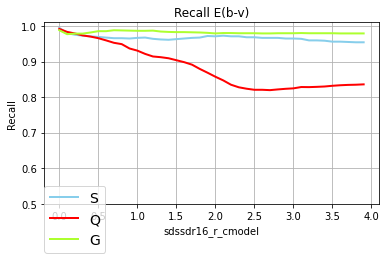

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9]


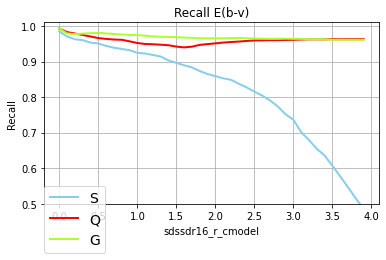

'\nF1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\')\nPrediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\')\nConfusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\')\nConfusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\', norm=True)\nacc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)\nacc = np.array(acc).T\naccuracy[overview] = acc\nbrightness[overview] = r\n\nnp.savetxt(f\'{path}/{overview}_{model}_on_{data}_r.txt\', brightness[overview])\nnp.savetxt(f\'{path}/{overview}_{model}_on_{data}_accuracy.txt\', accuracy[overview])\npath_on_15[model] = f\'{path}/{overview}_{model}_on_{data}_\'\n\nplt.figure(figsize=(15, 15))\nlines = []\nlabels = []\nclr = [\'skyblue\', \'aqua\', \'greenyellow\', \'lime\', \'yellow\', \'orange\', \'red\

In [270]:
accuracy = dict()
brightness = dict()
model = 'gb'

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

for overview in f.keys():
  path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{overview}"
  try:
      os.makedirs(path)
  except FileExistsError:
    print("Директория %s уже существует" % path)
  except OSError:
      print("Создать директорию %s не удалось" % path)
      exit()

  print(overview)

  X1, y1 = df1[[column]+f[overview]].values, df1['class'].values #.replace({'class':classes}, inplace = True)
  X2, y2 = df2[[column]+f[overview]].values, df2['class'].values

  
  '''
  m = globals()[f"For_one_{model[:2]}"]
  model1, robust1 = m(X1[:, 1:], y1, X2[:, 1:], y2)
  model2, robust2 = m(X2[:, 1:], y2, X1[:, 1:], y1)

  joblib.dump(model1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
  joblib.dump(robust1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')
  joblib.dump([X1, y1], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')


  joblib.dump(model2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
  joblib.dump(robust2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')
  joblib.dump([X2, y2], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')

  '''
  model1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
  robust1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')

  model2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
  robust2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')


  F1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Prediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', norm=True)
  acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)
  acc = np.array(acc).T
  accuracy[overview] = acc
  brightness[overview] = r

np.savetxt(f'{path}/{overview}_{model}_on_{data}_r.txt', brightness[overview])
np.savetxt(f'{path}/{overview}_{model}_on_{data}_accuracy.txt', accuracy[overview])
path_on_15[model] = f'{path}/{overview}_{model}_on_{data}_'

plt.figure(figsize=(15, 15))
lines = []
labels = []
clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']

j=0
for overview in f.keys():
  l, = plt.plot(brightness[overview], accuracy[overview], color=clr[j], lw=2)
  lines.append(l)
  labels.append(f"Model {overview}")
  j+=1

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlabel(column)
plt.xlim(15.5, 23)
plt.ylim(0.5, 1.01)
plt.ylabel('Acc')
plt.title('Acc')
plt.grid(True)
#plt.legend(lines, labels, loc=(0, -0.32), prop=dict(size=14))
#plt.savefig(f'/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}/{model}_accuracy.png')
plt.show()

##TN на сам себе

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn уже существует
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn/sdssdr16+psdr2+all_decals8tr уже существует
sdssdr16+psdr2+all_decals8tr


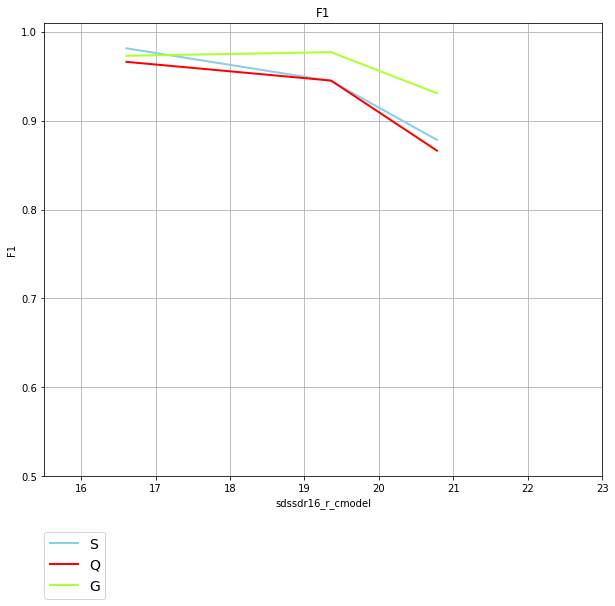

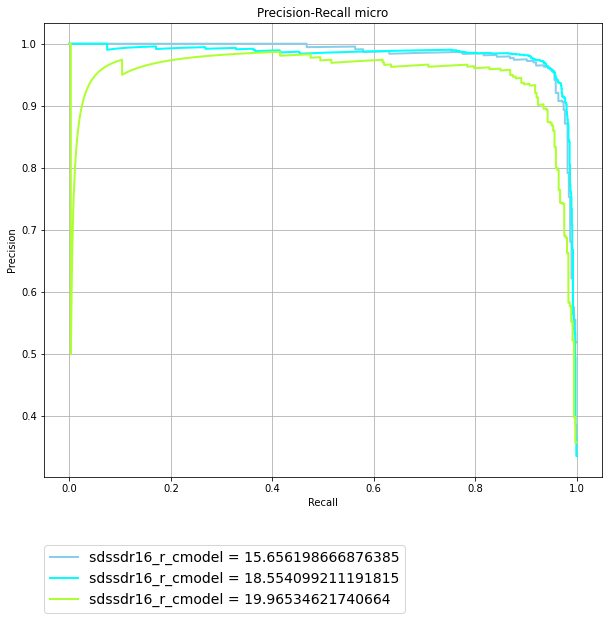

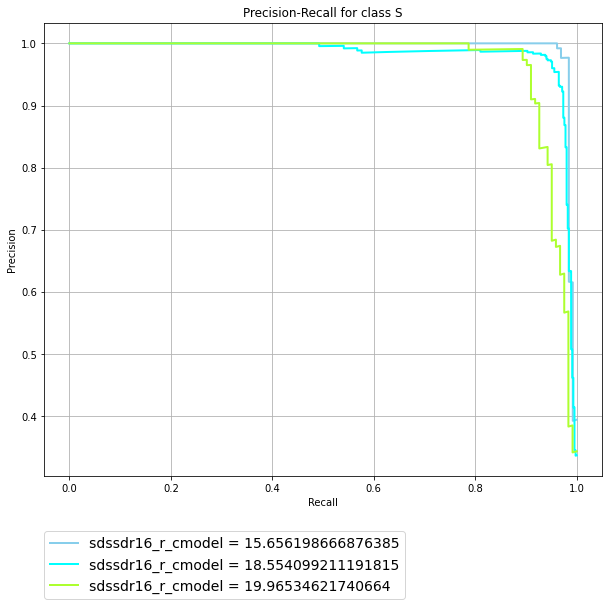

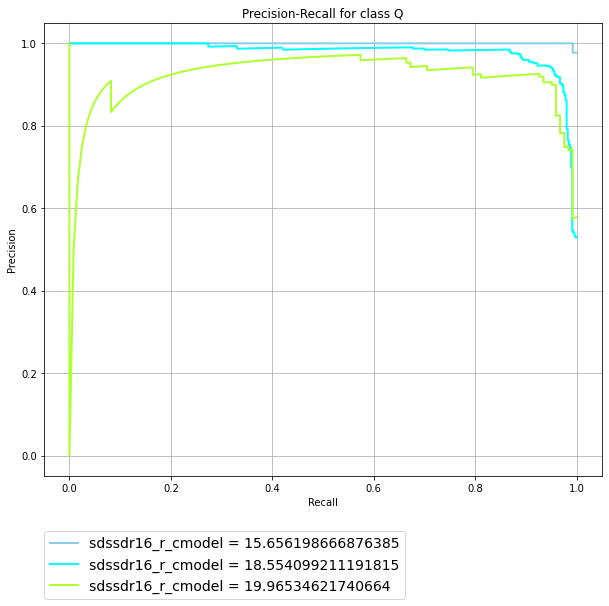

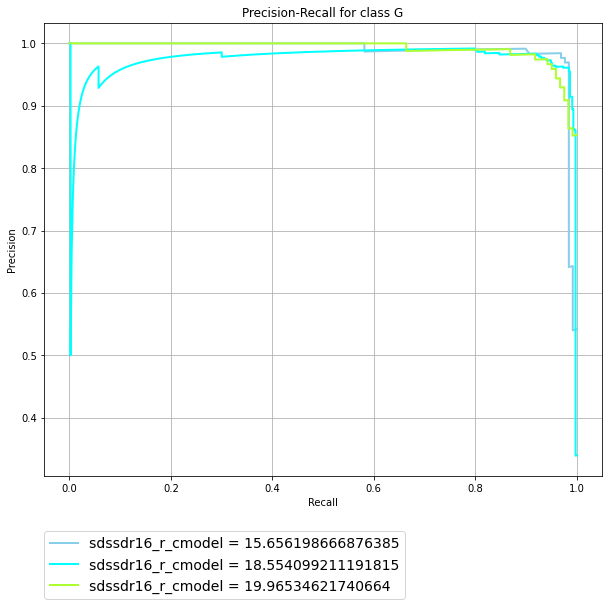

[[2235   47   24]
 [  51 7735  199]
 [  19  111 3669]]
saaaaaaaaaaaave


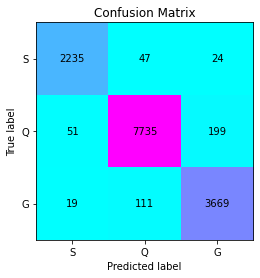

[[0.969 0.02  0.01 ]
 [0.006 0.969 0.025]
 [0.005 0.029 0.966]]
saaaaaaaaaaaave


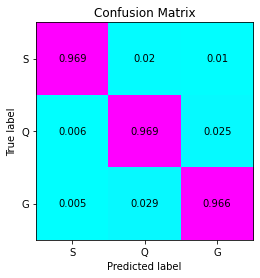

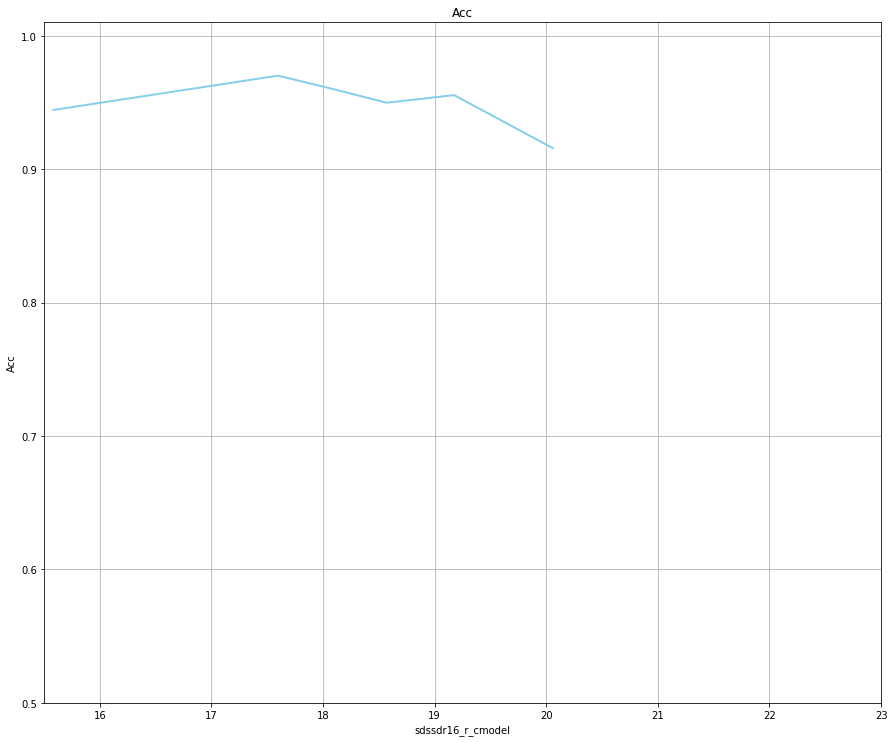

In [ ]:
accuracy = dict()
brightness = dict()
model = 'tn'

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

for overview in f.keys():
  path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}/{overview}"
  try:
      os.makedirs(path)
  except FileExistsError:
    print("Директория %s уже существует" % path)
  except OSError:
      print("Создать директорию %s не удалось" % path)
      exit()

  print(overview)

  #X1, y1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')
  #X2, y2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')


  #m = globals()[f"For_one_{model[:2]}"]
  #model1, robust1 = m(X1[:, 1:], y1, X2[:, 1:], y2)
  #model2, robust2 = m(X2[:, 1:], y2, X1[:, 1:], y1)

  #joblib.dump(model1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
  #joblib.dump(robust1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')


  #joblib.dump(model2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
  #joblib.dump(robust2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')

  model1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
  robust1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')

  model2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
  robust2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')

  F1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Prediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', norm=True)
  acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)
  acc = np.array(acc).T
  accuracy[overview] = acc
  brightness[overview] = r

np.savetxt(f'{path}/{overview}_{model}_on_{data}_r.txt', brightness[overview])
np.savetxt(f'{path}/{overview}_{model}_on_{data}_accuracy.txt', accuracy[overview])
path_on_15[model] = f'{path}/{overview}_{model}_on_{data}_'


plt.figure(figsize=(15, 15))
lines = []
labels = []
clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']

j=0
for overview in f.keys():
  l, = plt.plot(brightness[overview], accuracy[overview], color=clr[j], lw=2)
  lines.append(l)
  labels.append(f"Model {overview}")
  j+=1

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlabel(column)
plt.xlim(15.5, 23)
plt.ylim(0.5, 1.01)
plt.ylabel('Acc')
plt.title('Acc')
plt.grid(True)
#plt.legend(lines, labels, loc=(0, -0.32), prop=dict(size=14))
#plt.savefig(f'/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}/{model}_accuracy.png')
plt.show()

##GB на большой выборке тестим на маленькой

In [ ]:
#gb_big_big = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}.pkl')
#gb_big_big

In [ ]:
#tn_big = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/tn_big/model_{overview}.pkl')
#tn_big

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_big_big_on_little уже существует
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_big_big_on_little/sdssdr16+psdr2+all_decals8tr уже существует
sdssdr16+psdr2+all_decals8tr


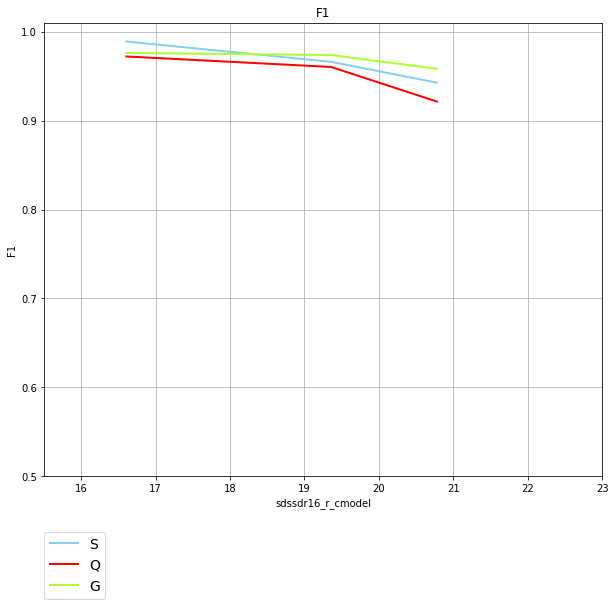

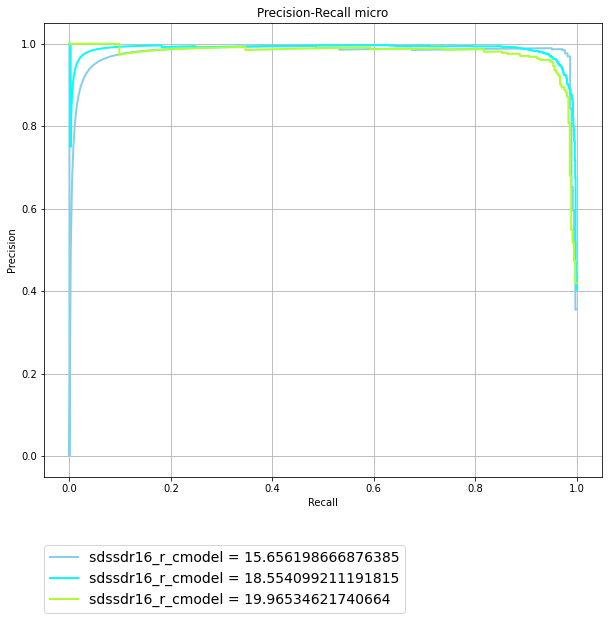

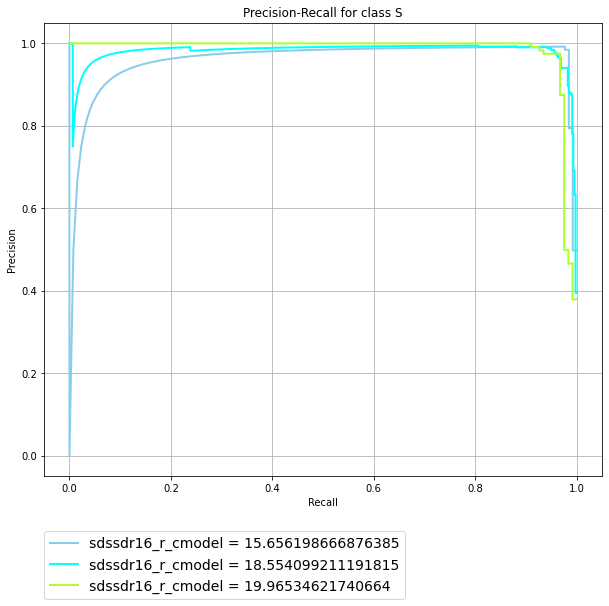

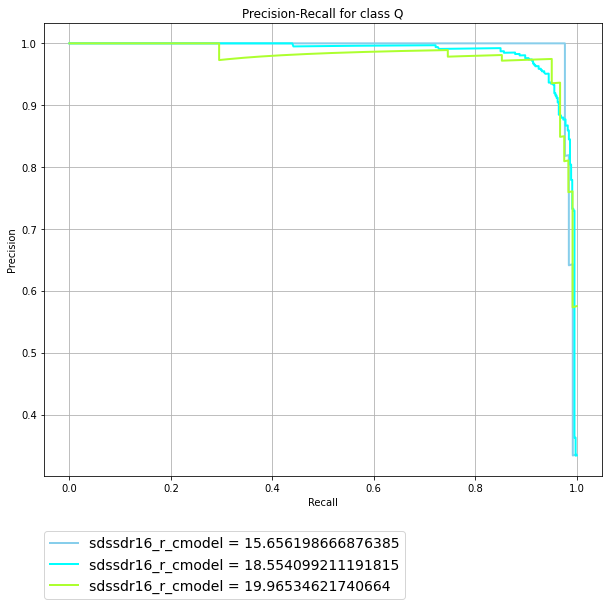

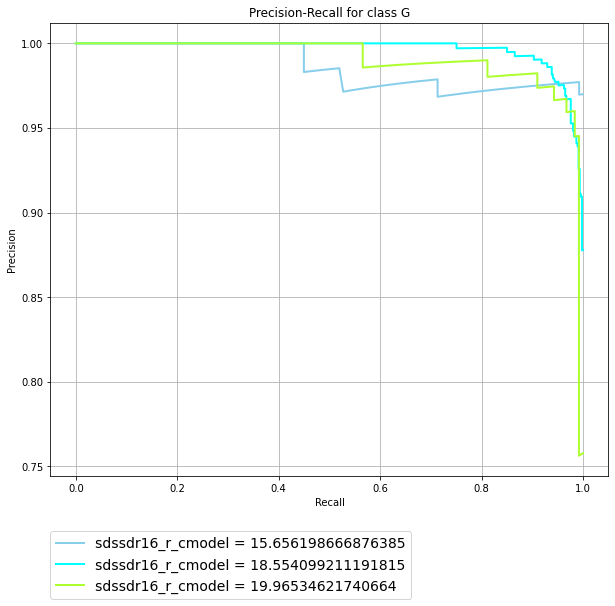

[[2250   38   18]
 [  64 7720  201]
 [  16   78 3705]]
saaaaaaaaaaaave


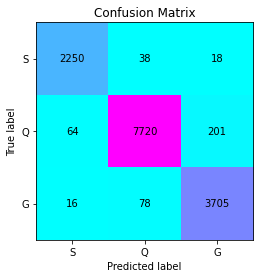

[[0.976 0.016 0.008]
 [0.008 0.967 0.025]
 [0.004 0.021 0.975]]
saaaaaaaaaaaave


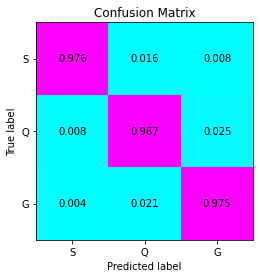

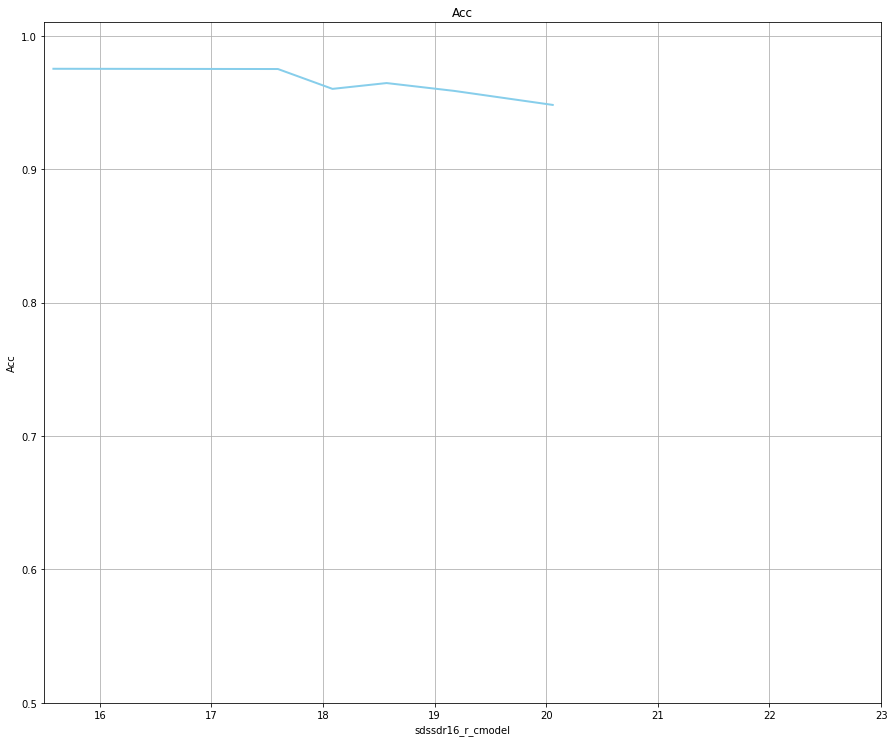

In [ ]:
accuracy = dict()
brightness = dict()
model = 'gb_big_big'

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

for overview in f.keys():
  path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{overview}"
  try:
      os.makedirs(path)
  except FileExistsError:
    print("Директория %s уже существует" % path)
  except OSError:
      print("Создать директорию %s не удалось" % path)
      exit()

  print(overview)

  #X1, y1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')
  #X2, y2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')


  model1 = model2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}.pkl')#были обучены на большом датасете 
  robust1 = robust2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_gb_big.pkl')


  F1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Prediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', norm=True)
  
  acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)
  acc = np.array(acc).T
  accuracy[overview] = acc
  brightness[overview] = r

np.savetxt(f'{path}/{overview}_{model}_on_{data}_r.txt', brightness[overview])
np.savetxt(f'{path}/{overview}_{model}_on_{data}_accuracy.txt', accuracy[overview])
path_on_15[model] = f'{path}/{overview}_{model}_on_{data}_'


plt.figure(figsize=(15, 15))
lines = []
labels = []
clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']

j=0
for overview in f.keys():
  l, = plt.plot(brightness[overview], accuracy[overview], color=clr[j], lw=2)
  lines.append(l)
  labels.append(f"Model {overview}")
  j+=1

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlabel(column)
plt.xlim(15.5, 23)
plt.ylim(0.5, 1.01)
plt.ylabel('Acc')
plt.title('Acc')
plt.grid(True)
#plt.legend(lines, labels, loc=(0, -0.32), prop=dict(size=14))
#plt.savefig(f'/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{model}_accuracy.png')
plt.show()

##TN на большой выборке тестим на маленькой

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big_on_little уже существует
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big_on_little/sdssdr16+psdr2+all_decals8tr уже существует
sdssdr16+psdr2+all_decals8tr


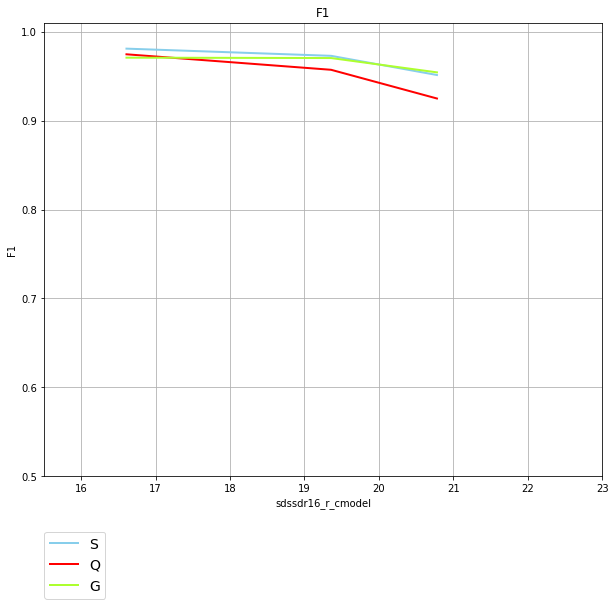

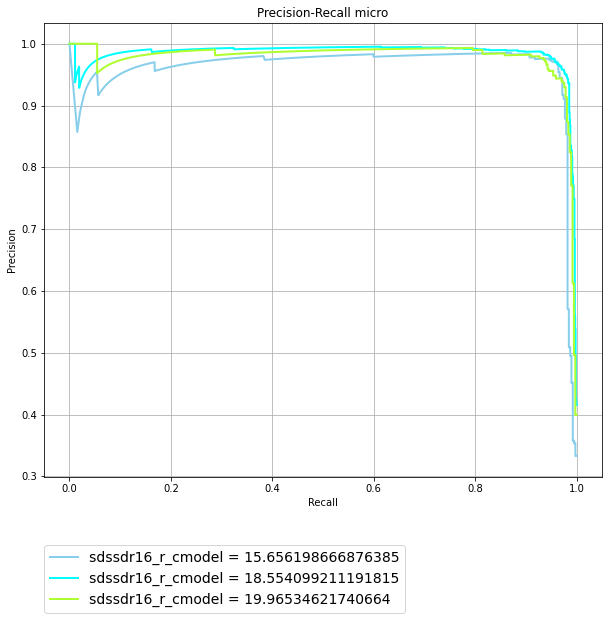

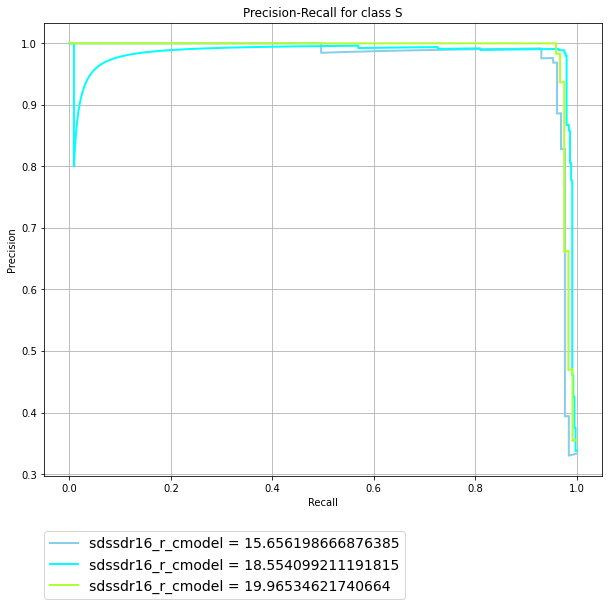

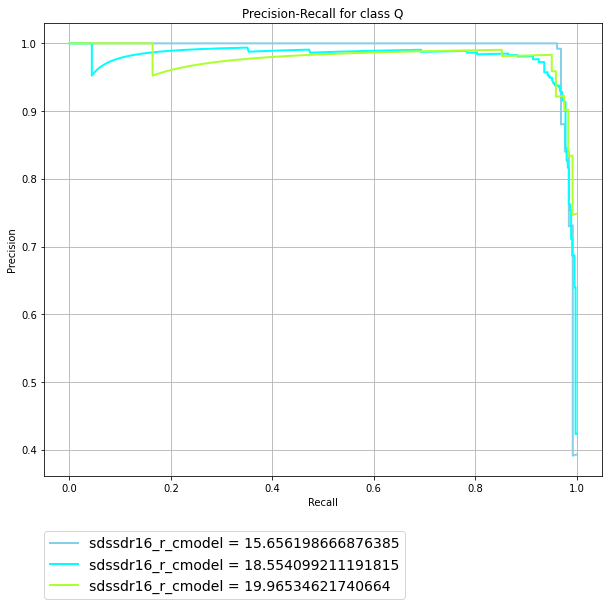

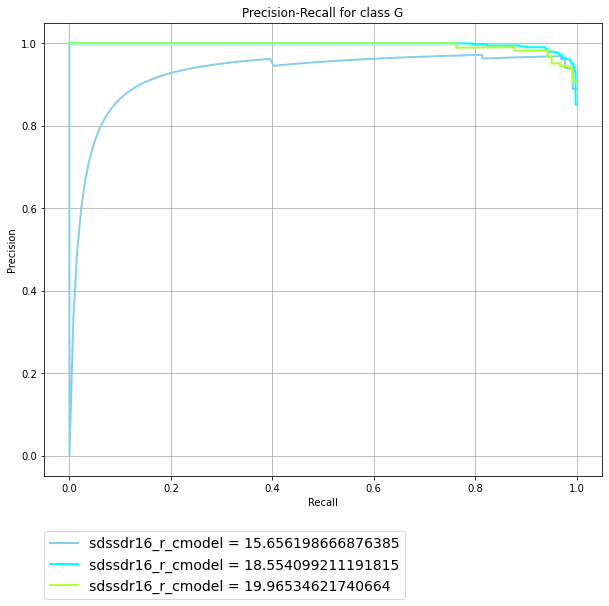

[[2235   39   32]
 [  63 7739  183]
 [  15   71 3713]]
saaaaaaaaaaaave


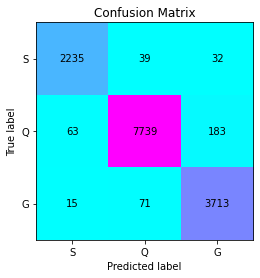

[[0.969 0.017 0.014]
 [0.008 0.969 0.023]
 [0.004 0.019 0.977]]
saaaaaaaaaaaave


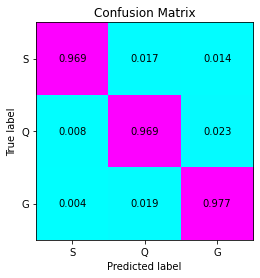

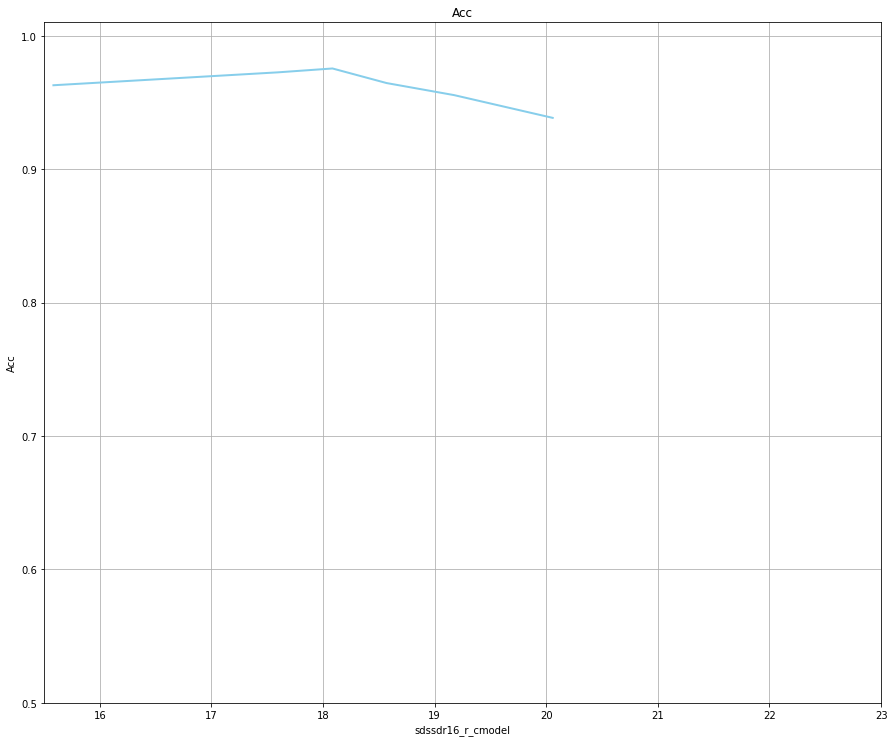

In [ ]:
accuracy = dict()
brightness = dict()
model = 'tn_big_big'

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

for overview in f.keys():
  path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{overview}"
  try:
      os.makedirs(path)
  except FileExistsError:
    print("Директория %s уже существует" % path)
  except OSError:
      print("Создать директорию %s не удалось" % path)
      exit()

  print(overview)

  #X1, y1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')
  #X2, y2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')


  model1 = model2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}.pkl')#были обучены на большом датасете 
  robust1 = robust2 = None#joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_gb_big.pkl')


  F1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Prediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', norm=True)
  
  acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)
  acc = np.array(acc).T
  accuracy[overview] = acc
  brightness[overview] = r

np.savetxt(f'{path}/{overview}_{model}_on_{data}_r.txt', brightness[overview])
np.savetxt(f'{path}/{overview}_{model}_on_{data}_accuracy.txt', accuracy[overview])
path_on_15[model] = f'{path}/{overview}_{model}_on_{data}_'


plt.figure(figsize=(15, 15))
lines = []
labels = []
clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']

j=0
for overview in f.keys():
  l, = plt.plot(brightness[overview], accuracy[overview], color=clr[j], lw=2)
  lines.append(l)
  labels.append(f"Model {overview}")
  j+=1

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlabel(column)
plt.xlim(15.5, 23)
plt.ylim(0.5, 1.01)
plt.ylabel('Acc')
plt.title('Acc')
plt.grid(True)
#plt.legend(lines, labels, loc=(0, -0.32), prop=dict(size=14))
#plt.savefig(f'/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{model}_accuracy.png')
plt.show()

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big2_on_little уже существует
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big2_on_little/sdssdr16+psdr2+all_decals8tr уже существует
sdssdr16+psdr2+all_decals8tr


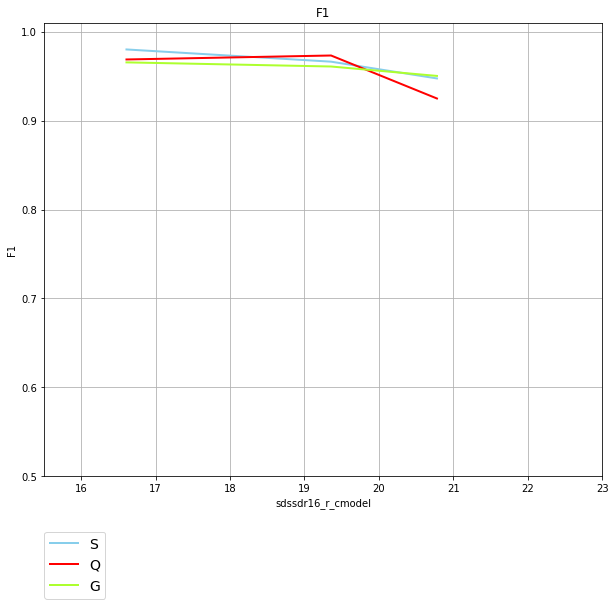

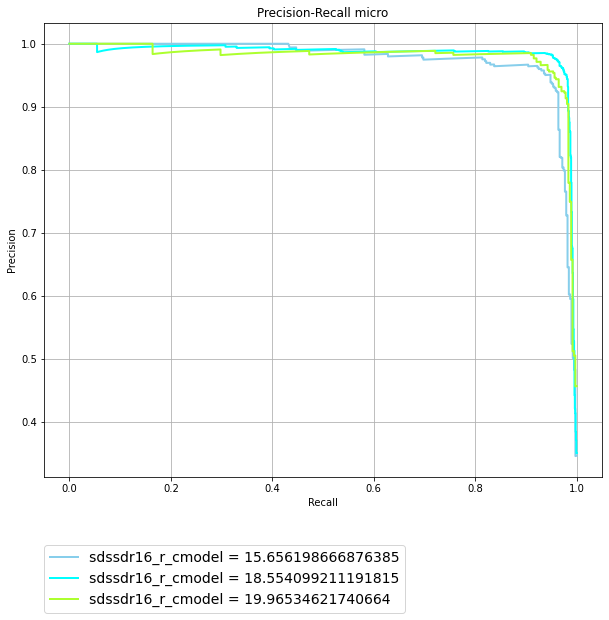

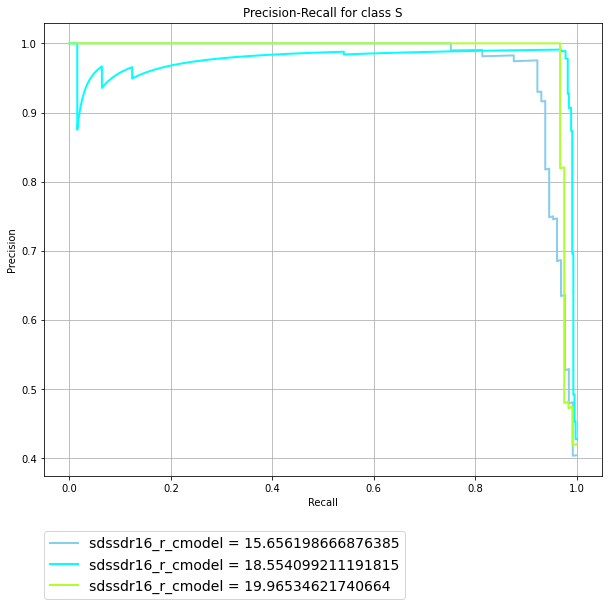

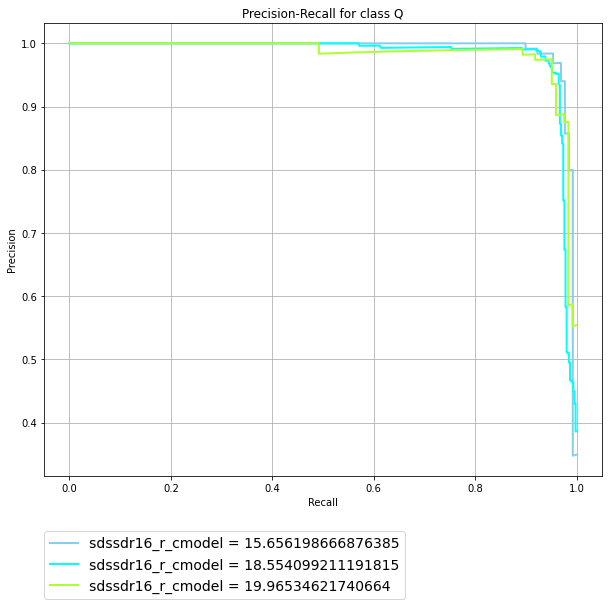

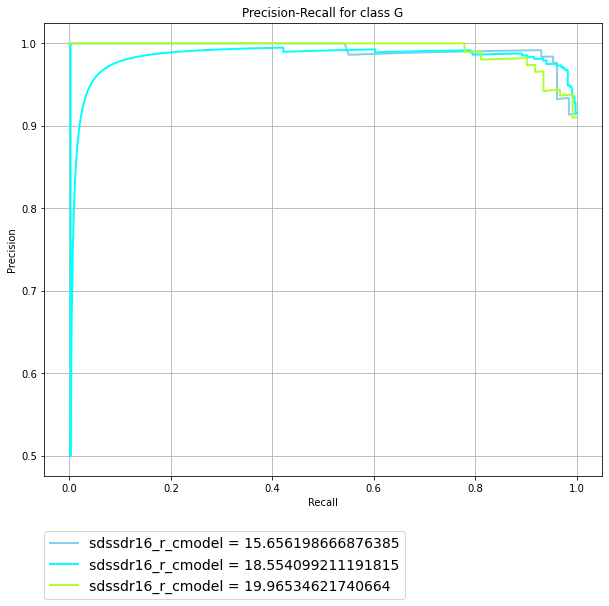

[[2242   23   41]
 [  57 7698  230]
 [  20   60 3719]]
saaaaaaaaaaaave


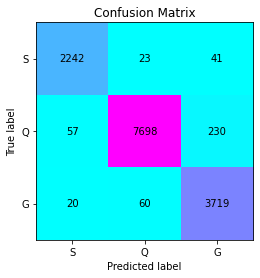

[[0.972 0.01  0.018]
 [0.007 0.964 0.029]
 [0.005 0.016 0.979]]
saaaaaaaaaaaave


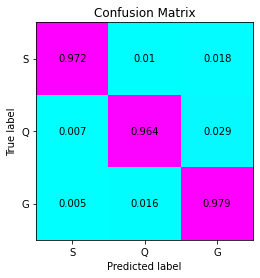

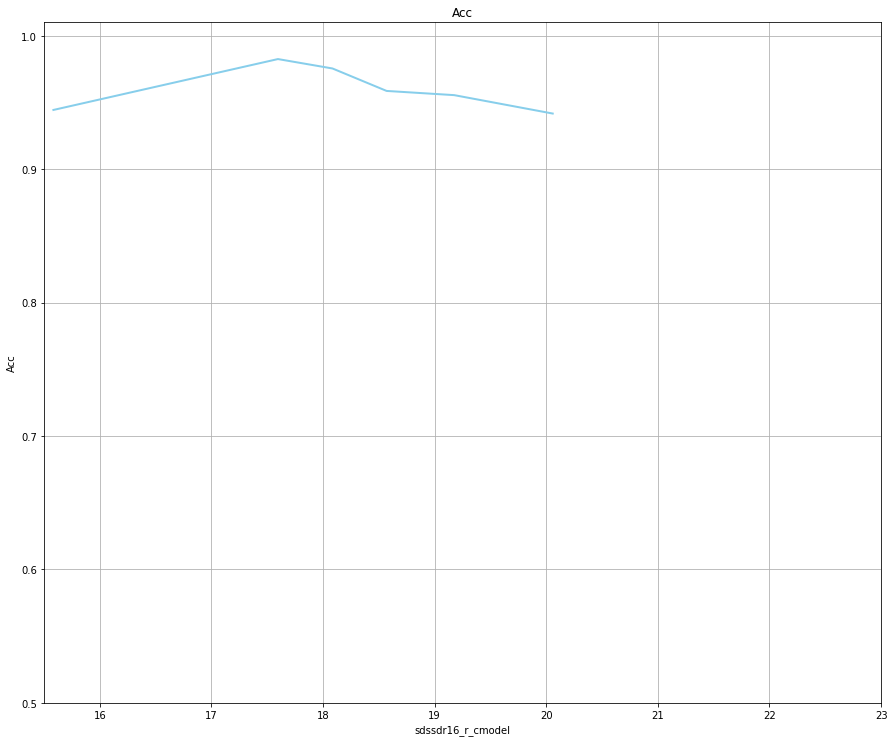

In [ ]:
accuracy = dict()
brightness = dict()
model = 'tn_big_big2'

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

for overview in f.keys():
  path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{overview}"
  try:
      os.makedirs(path)
  except FileExistsError:
    print("Директория %s уже существует" % path)
  except OSError:
      print("Создать директорию %s не удалось" % path)
      exit()

  print(overview)

  #X1, y1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')
  #X2, y2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')


  model1 = model2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}.pkl')#были обучены на большом датасете 
  robust1 = robust2 = None#joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_gb_big.pkl')


  F1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Prediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', norm=True)
  
  acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)
  acc = np.array(acc).T
  accuracy[overview] = acc
  brightness[overview] = r

np.savetxt(f'{path}/{overview}_{model}_on_{data}_r.txt', brightness[overview])
np.savetxt(f'{path}/{overview}_{model}_on_{data}_accuracy.txt', accuracy[overview])
path_on_15[model] = f'{path}/{overview}_{model}_on_{data}_'


plt.figure(figsize=(15, 15))
lines = []
labels = []
clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']

j=0
for overview in f.keys():
  l, = plt.plot(brightness[overview], accuracy[overview], color=clr[j], lw=2)
  lines.append(l)
  labels.append(f"Model {overview}")
  j+=1

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlabel(column)
plt.xlim(15.5, 23)
plt.ylim(0.5, 1.01)
plt.ylabel('Acc')
plt.title('Acc')
plt.grid(True)
#plt.legend(lines, labels, loc=(0, -0.32), prop=dict(size=14))
#plt.savefig(f'/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{model}_accuracy.png')
plt.show()

## Соединяем

In [ ]:
path_on_15

{'gb': '/content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_on_little/sdssdr16+psdr2+all_decals8tr/sdssdr16+psdr2+all_decals8tr_gb_on_little_',
 'gb_big_big': '/content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_big_big_on_little/sdssdr16+psdr2+all_decals8tr/sdssdr16+psdr2+all_decals8tr_gb_big_big_on_little_',
 'tn': '/content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn/sdssdr16+psdr2+all_decals8tr/sdssdr16+psdr2+all_decals8tr_tn_on_little_',
 'tn_big_big': '/content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big_on_little/sdssdr16+psdr2+all_decals8tr/sdssdr16+psdr2+all_decals8tr_tn_big_big_on_little_',
 'tn_big_big2': '/content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big2_on_little/sdssdr16+psdr2+all_decals8tr/sdssdr16+psdr2+all_decals8tr_tn_big_big2_on_little_'}

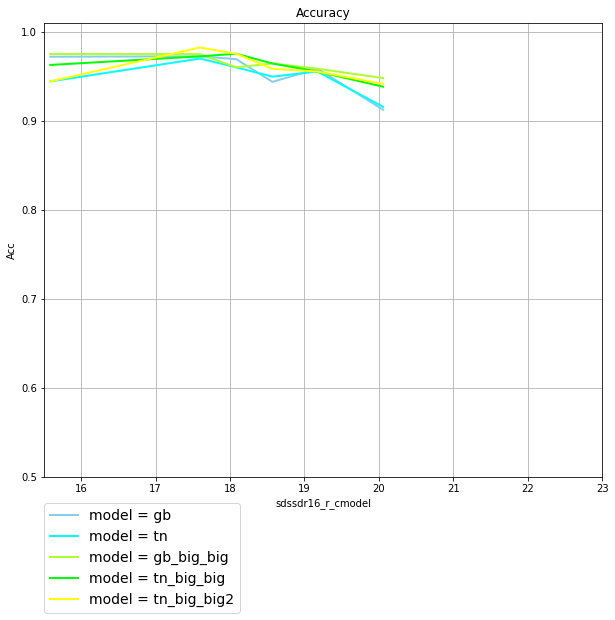

In [ ]:
plt.figure(figsize=(10, 10))
lab = path_on_15.keys()
lines = []
labels = []
#data = 'little'
clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']
j=0
for key in lab:
  file_name = path_on_15[key]
  acc = np.loadtxt(file_name+'accuracy.txt')
  r = np.loadtxt(file_name+'r.txt')
  l, = plt.plot(r, acc, color=clr[j], lw=2)
  lines.append(l)
  labels.append(f"model = {key}")
  j+=1

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlabel(column)
plt.xlim(15.5, 23)
plt.ylim(0.5, 1.01)
plt.grid(True)
plt.ylabel('Acc')
plt.title('Accuracy')
plt.savefig(f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_{data}/"+'Accuracy.png')
plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
plt.savefig(f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_{data}/"+'Accuracy_legend.png')

plt.show()

#На большой выборке

In [ ]:
path_on_big = dict()

In [ ]:
column = 'sdssdr16_r_cmodel'
data = 'big'

In [ ]:
import gzip
import pickle
classes = {'STAR': 1, 'QSO':2, 'GALAXY':3}


path = '/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_0/cv0.gz_pkl'
with gzip.open(path, 'rb') as fin:
    df1 = pickle.load(fin)
    df1 = df1[['zspec'] + [column] + features + ['class']].dropna()
    subclass1 = df1['zspec']
    df1 = df1[[column] + features + ['class']]


In [ ]:
path = '/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_1/cv1.gz_pkl'
with gzip.open(path, 'rb') as fin:
    df2 = pickle.load(fin)
    df2 = df2[['zspec'] + [column] + features + ['class']].dropna()
    subclass2 = df2['zspec']
    df2 = df2[[column] + features + ['class']]

In [ ]:
df1.replace({'class':classes}, inplace = True)
df2.replace({'class':classes}, inplace = True)

In [ ]:
df1

sdssdr16_r_cmodel  sdssdr16_u_psf  ...  sdssdr16_z_cmodel-decals8tr_z  class
0               16.824337       21.455454  ...                       0.245783      3
1               13.692711       18.601305  ...                      -0.000922      3
5               16.642016       19.744036  ...                       0.033045      3
6               15.300124       20.341056  ...                       0.919084      3
11              17.380912       19.755114  ...                      -0.168231      3
...                   ...             ...  ...                            ...    ...
586149          21.244578       24.451345  ...                       0.104750      2
586150          20.879663       21.326311  ...                      -0.449468      2
586164          22.844489       24.230143  ...                      -0.436247      2
586174          20.984400       22.151268  ...                      -0.187273      2
586175          21.667759       23.725394  ...                       0.371519      2

[286201 rows x 67 columns]

In [ ]:
np.sum(df1['class'] == 3)

66279

In [ ]:
subclass1

0         0.046132
1         0.021385
5         0.046178
6         0.025434
11        0.028537
            ...   
586149    6.476000
586150    6.578712
586164    6.795398
586174    6.949000
586175    6.968027
Name: zspec, Length: 286201, dtype: float64

##GB на самом себе

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_big_on_big уже существует
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_big_on_big/sdssdr16+psdr2+all_decals8tr уже существует
sdssdr16+psdr2+all_decals8tr
(17951, 43) (18147, 43)
(17500, 43) (17698, 43)
(19225, 43) (19487, 43)
(11588, 43) (11751, 43)


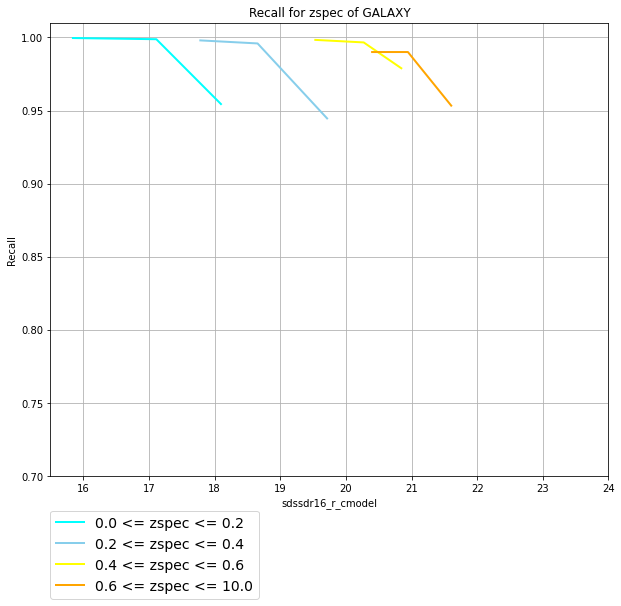

(38515, 43) (39252, 43)
(86878, 43) (88060, 43)
(78175, 43) (78996, 43)
(16496, 43) (16703, 43)


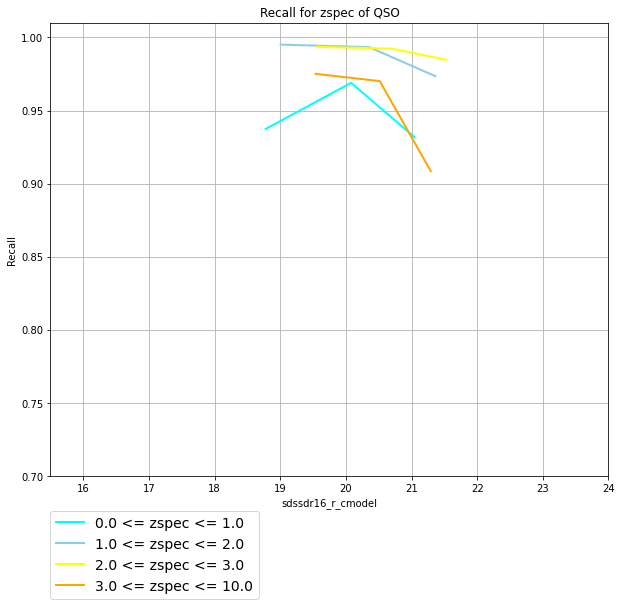

'\n  F1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\')\n  Prediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\')\n  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\')\n  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\', norm=True)\n  acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)\n  acc = np.array(acc).T\n  accuracy[overview] = acc\n  brightness[overview] = r\n\nnp.savetxt(f\'{path}/{overview}_{model}_on_{data}_r.txt\', brightness[overview])\nnp.savetxt(f\'{path}/{overview}_{model}_on_{data}_accuracy.txt\', accuracy[overview])\npath_on_big[model] = f\'{path}/{overview}_{model}_on_{data}_\'\n\nplt.figure(figsize=(15, 15))\nlines = []\nlabels = []\nclr = [\'skyblue\', \'aqua\', \'greenyellow\', \'lime\', \'yellow\', \

In [ ]:
accuracy = dict()
brightness = dict()
model = 'gb_big'

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

for overview in f.keys():
  path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{overview}"
  try:
      os.makedirs(path)
  except FileExistsError:
    print("Директория %s уже существует" % path)
  except OSError:
      print("Создать директорию %s не удалось" % path)
      exit()

  print(overview)

  X1, y1 = df1[[column]+f[overview]].values, df1['class'].values #.replace({'class':classes}, inplace = True)
  X2, y2 = df2[[column]+f[overview]].values, df2['class'].values

  '''
  m = globals()[f"For_one_{model[:2]}"]
  model1, robust1 = m(X1[:, 1:], y1, X2[:, 1:], y2)
  model2, robust2 = m(X2[:, 1:], y2, X1[:, 1:], y1)

  joblib.dump(model1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
  joblib.dump(robust1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')
  #joblib.dump([X1, y1], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')


  joblib.dump(model2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
  joblib.dump(robust2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')
  #joblib.dump([X2, y2], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')
  '''
  model1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')
  robust1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')

  model2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')
  robust2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')


  '''
  ZG_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=f'{path}/{overview}_{model}_', N=3)
  ZQ_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=f'{path}/{overview}_{model}_', N=3)

  SubClass_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=f'{path}/{overview}_{model}_', N=6)
  '''

  F1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Prediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', norm=True)
  
  acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)
  acc = np.array(acc).T
  accuracy[overview] = acc
  brightness[overview] = r

np.savetxt(f'{path}/{overview}_{model}_on_{data}_r.txt', brightness[overview])
np.savetxt(f'{path}/{overview}_{model}_on_{data}_accuracy.txt', accuracy[overview])
path_on_big[model] = f'{path}/{overview}_{model}_on_{data}_'


plt.figure(figsize=(15, 15))
lines = []
labels = []
clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']

j=0
for overview in f.keys():
  l, = plt.plot(brightness[overview], accuracy[overview], color=clr[j], lw=2)
  lines.append(l)
  labels.append(f"Model {overview}")
  j+=1

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlabel(column)
plt.xlim(15.5, 23)
plt.ylim(0.5, 1.01)
plt.ylabel('Acc')
plt.title('Acc')
plt.grid(True)
#plt.legend(lines, labels, loc=(0, -0.32), prop=dict(size=14))
#plt.savefig(f'/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{model}_accuracy.png')
plt.show()


## GB на маленькой тестим на большой

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_on_big уже существует
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_on_big/sdssdr16+psdr2+all_decals8tr уже существует
sdssdr16+psdr2+all_decals8tr
(17951, 43) (18147, 43)
(17500, 43) (17698, 43)
(19225, 43) (19487, 43)
(11588, 43) (11751, 43)


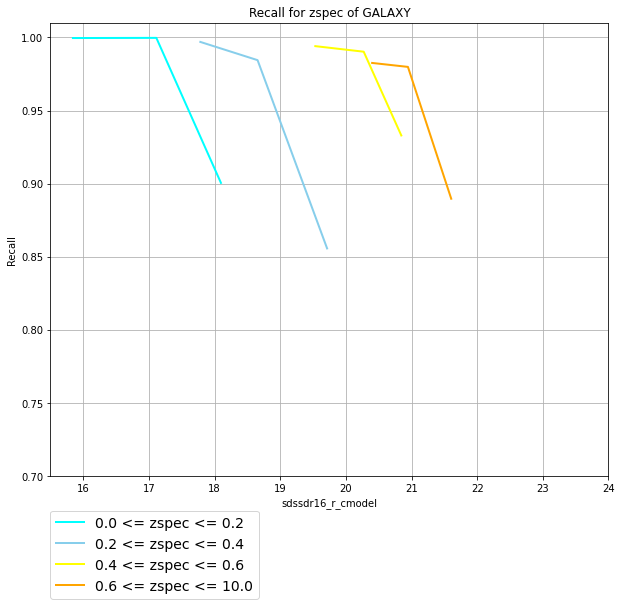

(38515, 43) (39252, 43)
(86878, 43) (88060, 43)
(78175, 43) (78996, 43)
(16496, 43) (16703, 43)


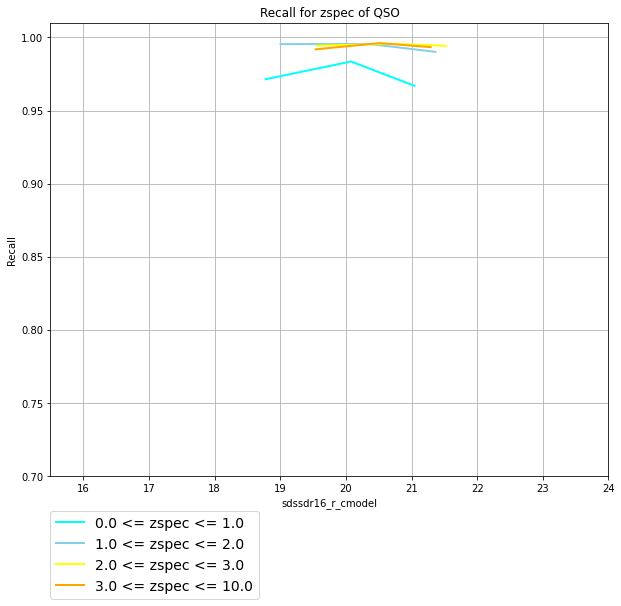

'\n  SubClass_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=f\'{path}/{overview}_{model}_\', N=6)\n\n  F1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\')\n  Prediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\')\n  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\')\n  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f\'{path}/{overview}_{model}_\', norm=True)\n  \n  acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)\n  acc = np.array(acc).T\n  accuracy[overview] = acc\n  brightness[overview] = r\n\nnp.savetxt(f\'{path}/{overview}_{model}_on_{data}_r.txt\', brightness[overview])\nnp.savetxt(f\'{path}/{overview}_{model}_on_{data}_accuracy.txt\', accuracy[overview])\npath_on_big[model] = f\'{path}/{overview

In [ ]:
accuracy = dict()
brightness = dict()
model = 'gb'

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

for overview in f.keys():
  path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{overview}"
  try:
      os.makedirs(path)
  except FileExistsError:
    print("Директория %s уже существует" % path)
  except OSError:
      print("Создать директорию %s не удалось" % path)
      exit()

  print(overview)

  #X1, y1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')
  #X2, y2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')


  model1 = model2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}.pkl')#были обучены на маленьком датасете 
  robust1 = robust2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}.pkl')
  '''
  ZG_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=f'{path}/{overview}_{model}_', N=3)
  ZQ_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=f'{path}/{overview}_{model}_', N=3)

  SubClass_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=f'{path}/{overview}_{model}_', N=6)
  '''

  F1_plot_class(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Prediction_Recall_plot(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_')
  Confusion_Matrix(X1, y1, X2, y2, model1, model2, robust1, robust2, column, f'{path}/{overview}_{model}_', norm=True)
  
  acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 100, robust1, robust2, accuracy_score)
  acc = np.array(acc).T
  accuracy[overview] = acc
  brightness[overview] = r

np.savetxt(f'{path}/{overview}_{model}_on_{data}_r.txt', brightness[overview])
np.savetxt(f'{path}/{overview}_{model}_on_{data}_accuracy.txt', accuracy[overview])
path_on_big[model] = f'{path}/{overview}_{model}_on_{data}_'


plt.figure(figsize=(15, 15))
lines = []
labels = []
clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']

j=0
for overview in f.keys():
  l, = plt.plot(brightness[overview], accuracy[overview], color=clr[j], lw=2)
  lines.append(l)
  labels.append(f"Model {overview}")
  j+=1

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlabel(column)
plt.xlim(15.5, 23)
plt.ylim(0.5, 1.01)
plt.ylabel('Acc')
plt.title('Acc')
plt.grid(True)
#plt.legend(lines, labels, loc=(0, -0.32), prop=dict(size=14))
#plt.savefig(f'/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{model}_accuracy.png')
plt.show()



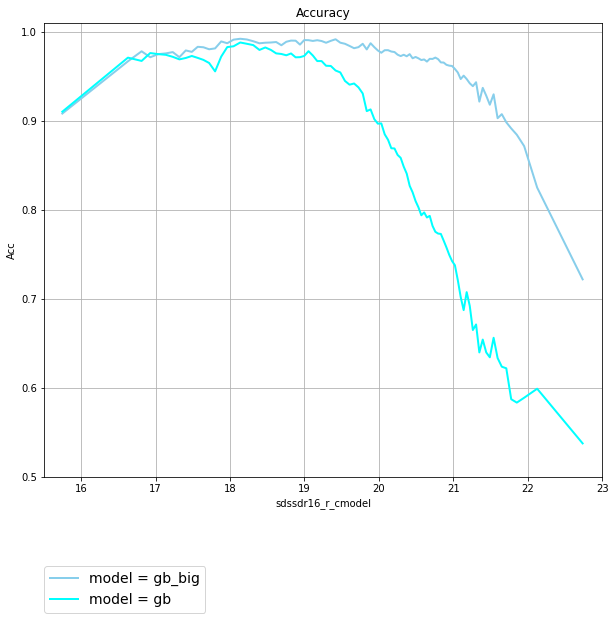

In [ ]:
plt.figure(figsize=(10, 10))
lab = path_on_big.keys()
lines = []
labels = []
clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']
j=0
for key in lab:
  file_name = path_on_big[key]
  acc = np.loadtxt(file_name+'accuracy.txt')
  r = np.loadtxt(file_name+'r.txt')
  l, = plt.plot(r, acc, color=clr[j], lw=2)
  lines.append(l)
  labels.append(f"model = {key}")
  j+=1

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlabel(column)
plt.xlim(15.5, 23)
plt.ylim(0.5, 1.01)
plt.grid(True)
plt.ylabel('Acc')
plt.title('Accuracy')
plt.savefig(f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_{data}/"+'Accuracy.png')
plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
plt.savefig(f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_{data}/"+'Accuracy_legend.png')

plt.show()

# Тест на целевой выборке рентгеновских звезд

## Обученные на рентгеновской выборке

In [78]:
path_for_all_model = dict()

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_on_target уже существует


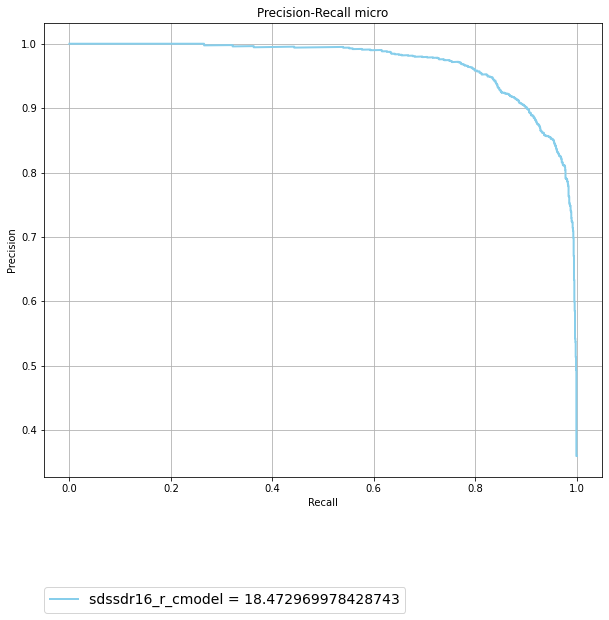

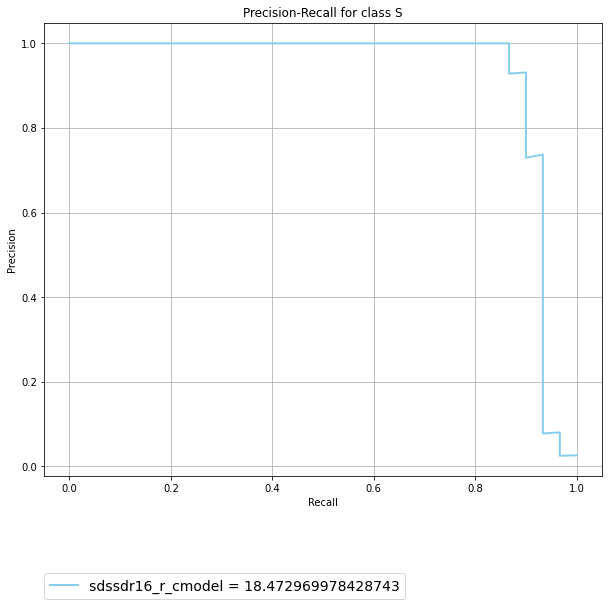

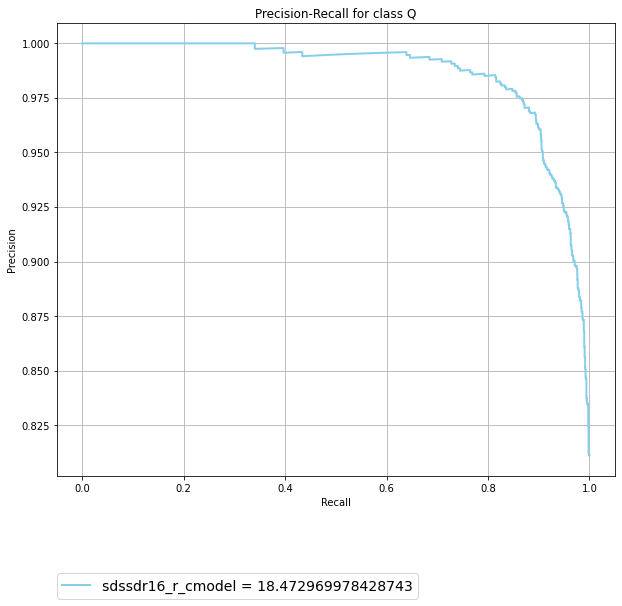

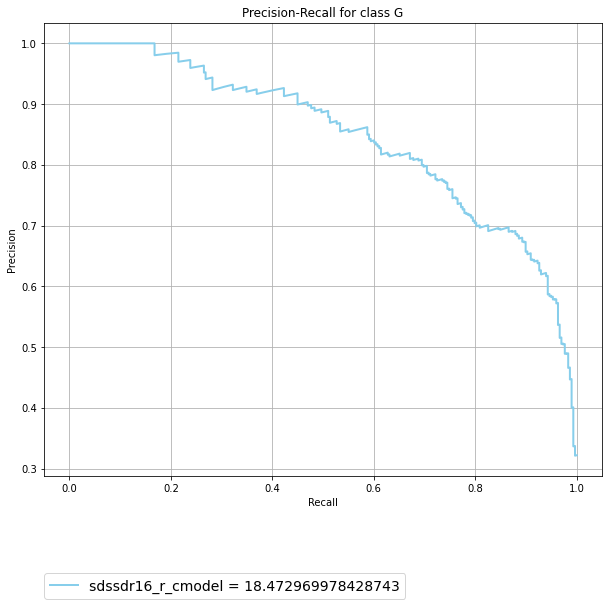

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.83      0.91        30
           2       0.93      0.95      0.94      1164
           3       0.78      0.73      0.76       298

    accuracy                           0.90      1492
   macro avg       0.90      0.84      0.87      1492
weighted avg       0.90      0.90      0.90      1492

[[0.833 0.167 0.   ]
 [0.    0.946 0.054]
 [0.    0.265 0.735]]
saaaaaaaaaaaave


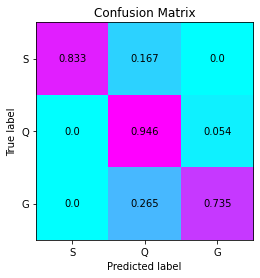

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.83      0.91        30
           2       0.93      0.95      0.94      1164
           3       0.78      0.73      0.76       298

    accuracy                           0.90      1492
   macro avg       0.90      0.84      0.87      1492
weighted avg       0.90      0.90      0.90      1492

[[  25    5    0]
 [   0 1101   63]
 [   0   79  219]]
saaaaaaaaaaaave


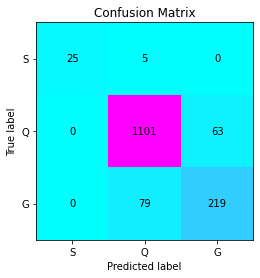

In [79]:
#accuracy = dict()
#brightness = dict()

overview = "sdssdr16+psdr2+all_decals8tr"
column = 'sdssdr16_r_cmodel'
model = 'gb'
folder = f'{model}_on_target'
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
df1 = df[[column]+f[overview]+[class_row]].dropna()

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"


try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

path = path + f'/{model}_'

X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1


gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')#были обучены на маленьком датасете 
robust = joblib.load(f'{model_path}/{overview}_robust_for_gb.pkl') if model[:2] == 'gb' else None
path_for_all_model[model] = path

  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_on_target уже существует


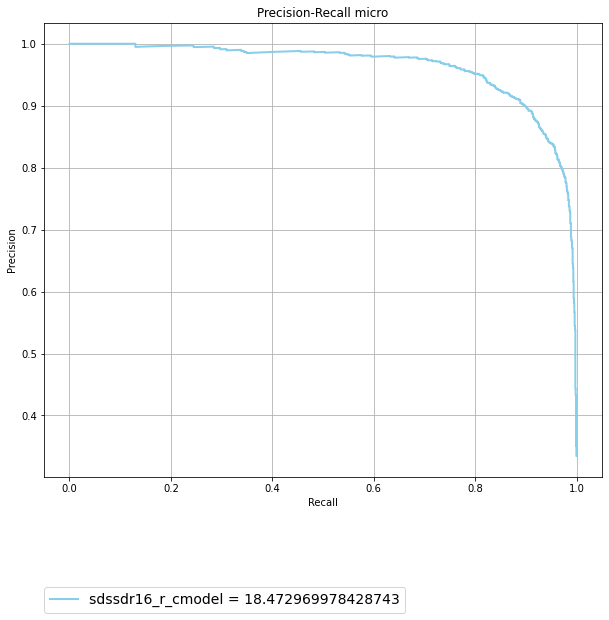

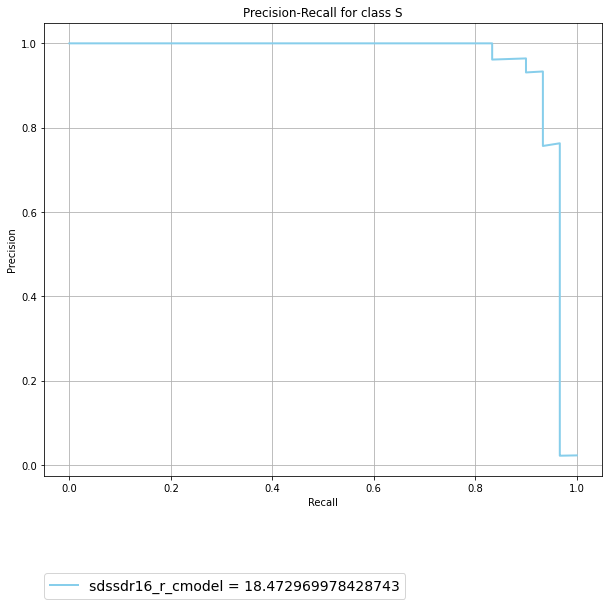

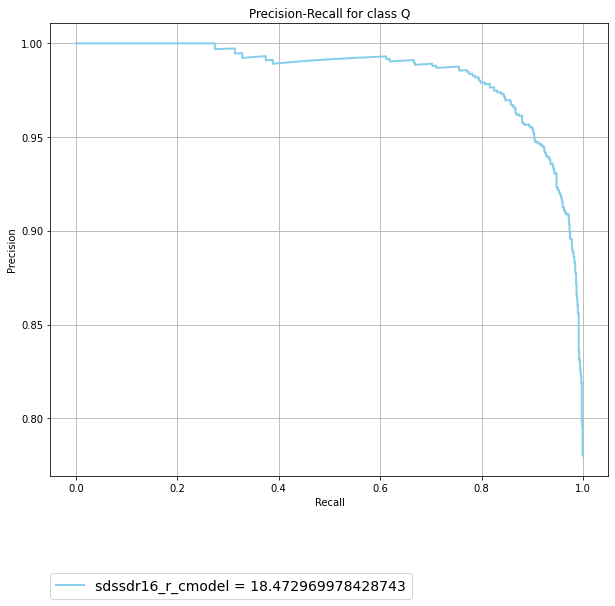

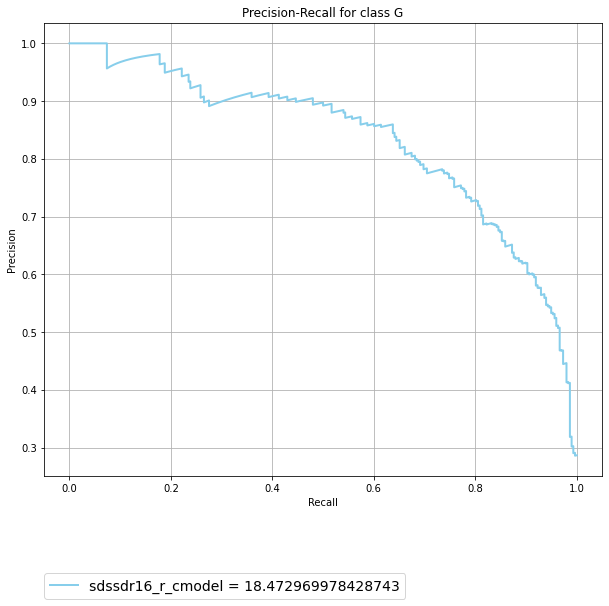

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.83      0.91        30
           2       0.94      0.93      0.94      1164
           3       0.74      0.78      0.76       298

    accuracy                           0.90      1492
   macro avg       0.89      0.85      0.87      1492
weighted avg       0.90      0.90      0.90      1492

[[0.833 0.133 0.033]
 [0.    0.931 0.069]
 [0.    0.221 0.779]]
saaaaaaaaaaaave


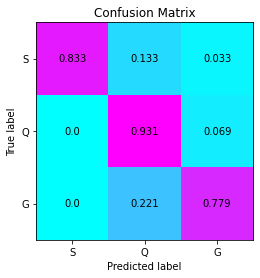

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.83      0.91        30
           2       0.94      0.93      0.94      1164
           3       0.74      0.78      0.76       298

    accuracy                           0.90      1492
   macro avg       0.89      0.85      0.87      1492
weighted avg       0.90      0.90      0.90      1492

[[  25    4    1]
 [   0 1084   80]
 [   0   66  232]]
saaaaaaaaaaaave


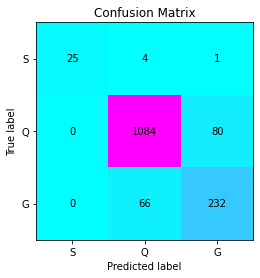

In [80]:
#accuracy = dict()
#brightness = dict()

#overview = 'sdssdr16+wise_decals8tr'
column = 'sdssdr16_r_cmodel'
model = 'tn'
folder = f'{model}_on_target'
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
df1 = df[[column]+f[overview]+[class_row]].dropna()

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

path = path + f'/{model}_'

X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1


gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')#были обучены на маленьком датасете 
robust = joblib.load(f'{model_path}/{overview}_robust_for_gb.pkl') if model[:2] == 'gb' else None
path_for_all_model[model] = path

  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

## Обученные на большой

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_big_big_on_target уже существует


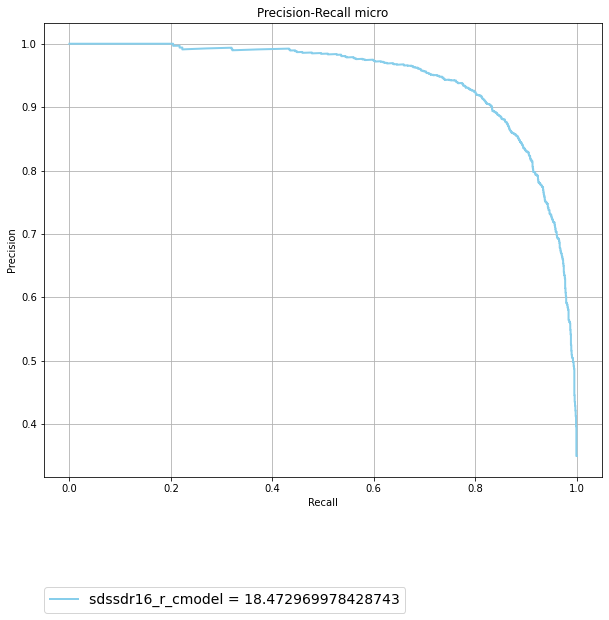

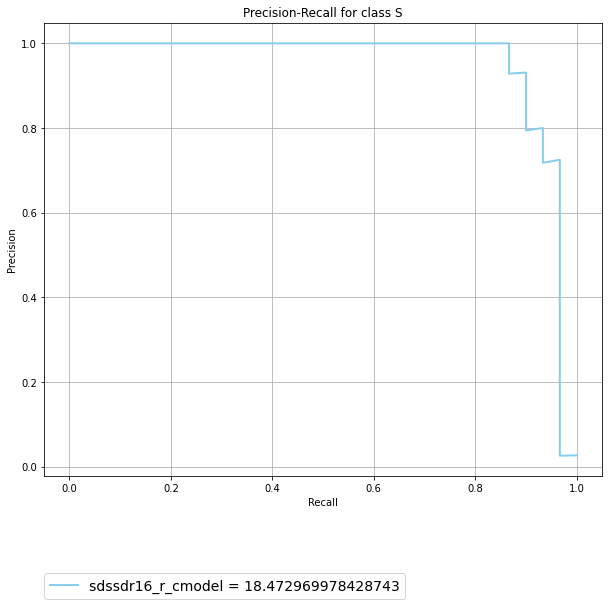

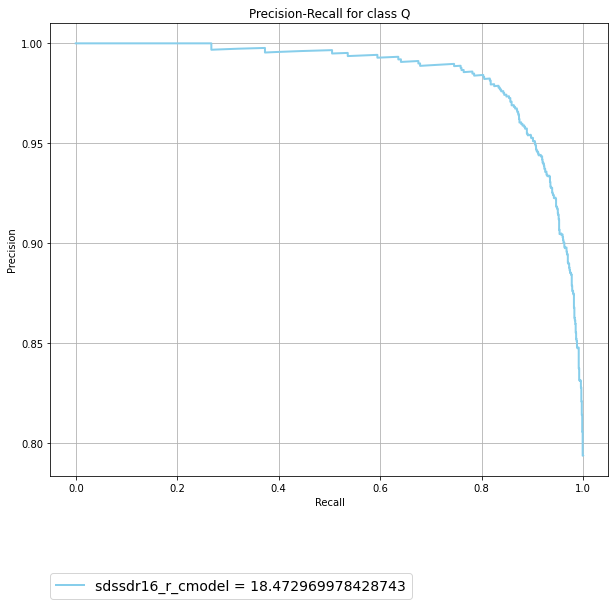

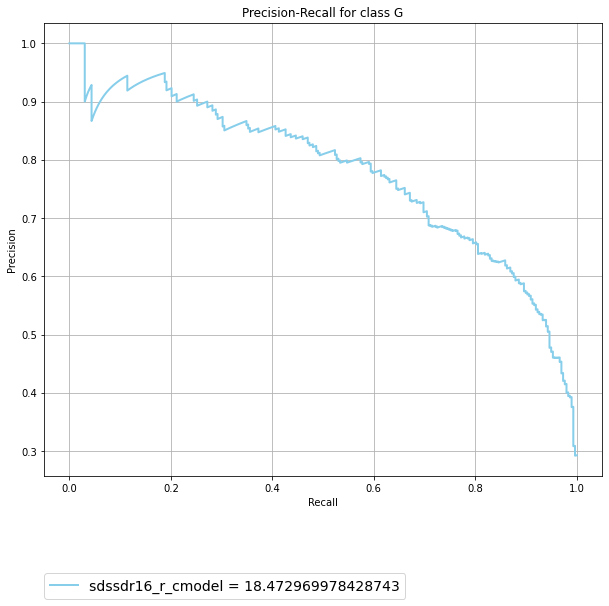

Classification Report: 
               precision    recall  f1-score   support

           1       0.36      0.97      0.53        30
           2       0.95      0.90      0.93      1164
           3       0.70      0.71      0.71       298

    accuracy                           0.87      1492
   macro avg       0.67      0.86      0.72      1492
weighted avg       0.89      0.87      0.87      1492

[[0.967 0.033 0.   ]
 [0.019 0.903 0.078]
 [0.097 0.188 0.715]]
saaaaaaaaaaaave


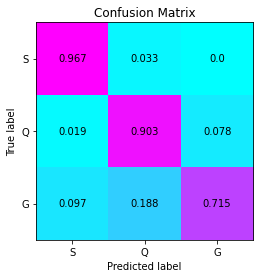

Classification Report: 
               precision    recall  f1-score   support

           1       0.36      0.97      0.53        30
           2       0.95      0.90      0.93      1164
           3       0.70      0.71      0.71       298

    accuracy                           0.87      1492
   macro avg       0.67      0.86      0.72      1492
weighted avg       0.89      0.87      0.87      1492

[[  29    1    0]
 [  22 1051   91]
 [  29   56  213]]
saaaaaaaaaaaave


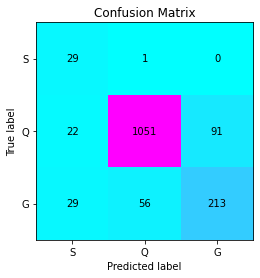

In [81]:
#accuracy = dict()
#brightness = dict()

#overview = 'sdssdr16+wise_decals8tr'
column = 'sdssdr16_r_cmodel'
model = 'gb_big_big'
folder = f'{model}_on_target'
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
df1 = df[[column]+f[overview]+[class_row]].dropna()

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()
path = path + f'/{model}'
X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1


gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')#были обучены на маленьком датасете 
robust = joblib.load(f'{model_path}/{overview}_robust_for_gb_big.pkl') if model[:2] == 'gb' else None
path_for_all_model[model] = path

  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big_on_target уже существует


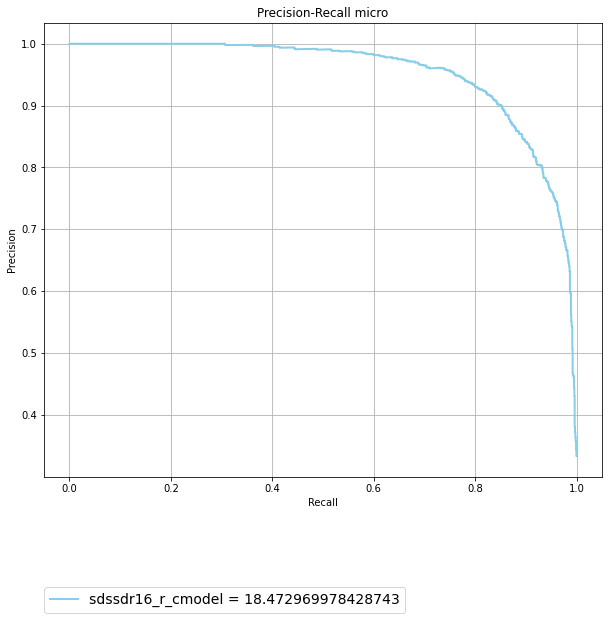

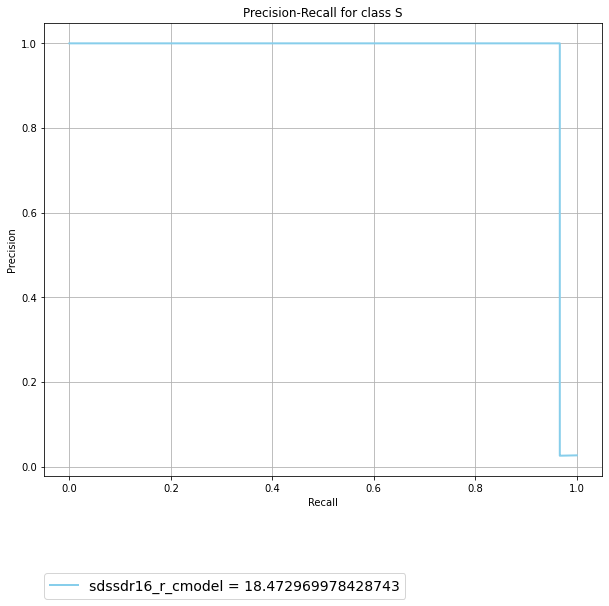

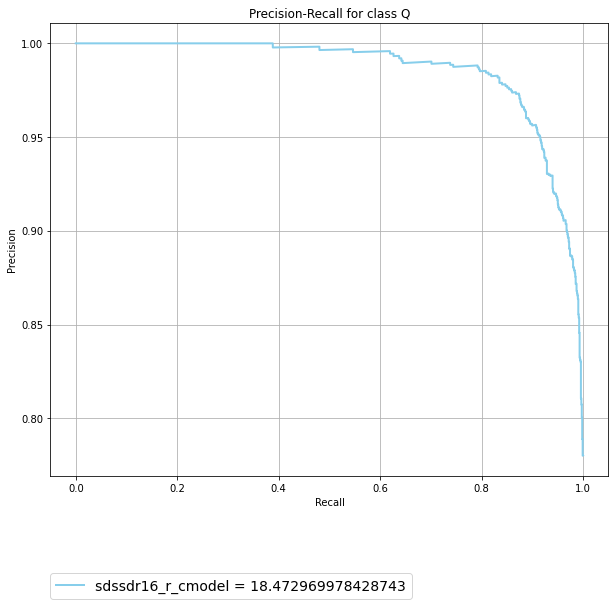

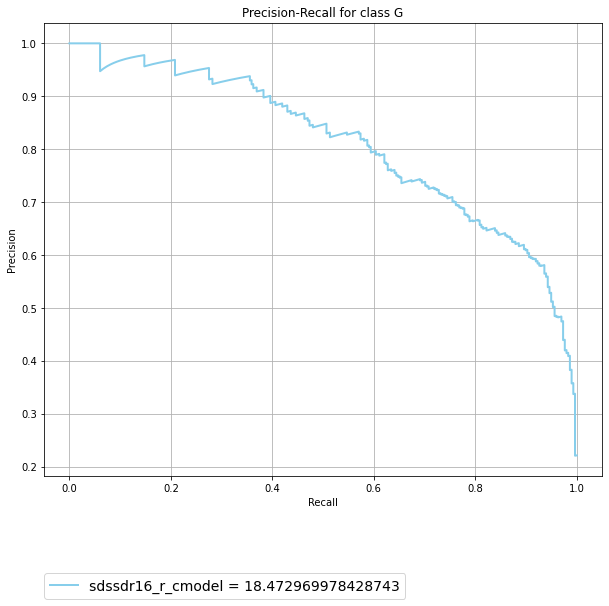

Classification Report: 
               precision    recall  f1-score   support

           1       0.45      0.97      0.61        30
           2       0.96      0.89      0.92      1164
           3       0.68      0.79      0.73       298

    accuracy                           0.87      1492
   macro avg       0.69      0.88      0.75      1492
weighted avg       0.89      0.87      0.88      1492

[[0.967 0.033 0.   ]
 [0.013 0.89  0.097]
 [0.07  0.138 0.792]]
saaaaaaaaaaaave


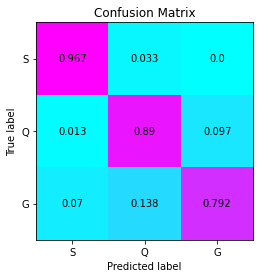

Classification Report: 
               precision    recall  f1-score   support

           1       0.45      0.97      0.61        30
           2       0.96      0.89      0.92      1164
           3       0.68      0.79      0.73       298

    accuracy                           0.87      1492
   macro avg       0.69      0.88      0.75      1492
weighted avg       0.89      0.87      0.88      1492

[[  29    1    0]
 [  15 1036  113]
 [  21   41  236]]
saaaaaaaaaaaave


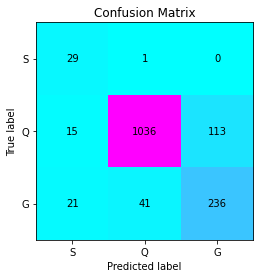

In [82]:
#accuracy = dict()
#brightness = dict()

#overview = 'sdssdr16+wise_decals8tr'
column = 'sdssdr16_r_cmodel'
model = 'tn_big_big'
folder = f'{model}_on_target'
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
df1 = df[[column]+f[overview]+[class_row]].dropna()

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()
path = path + f'/{model}'
X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1


gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')#были обучены на маленьком датасете 
robust = joblib.load(f'{model_path}/{overview}_robust_for_gb.pkl') if model[:2] == 'gb' else None
path_for_all_model[model] = path

  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big2_on_target уже существует


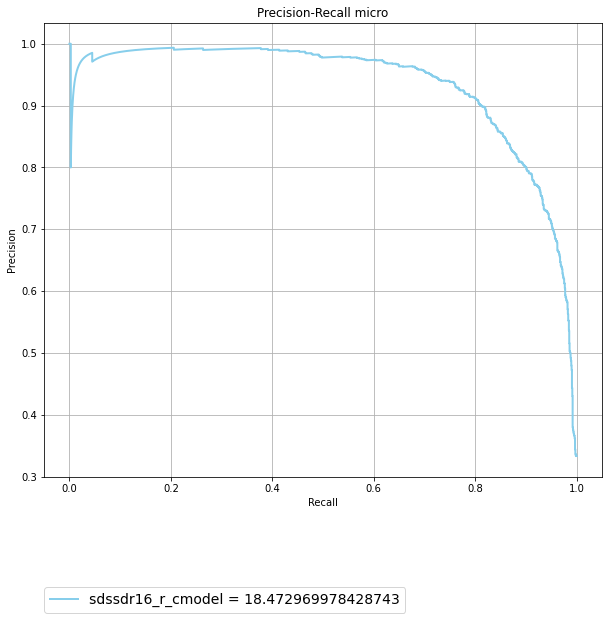

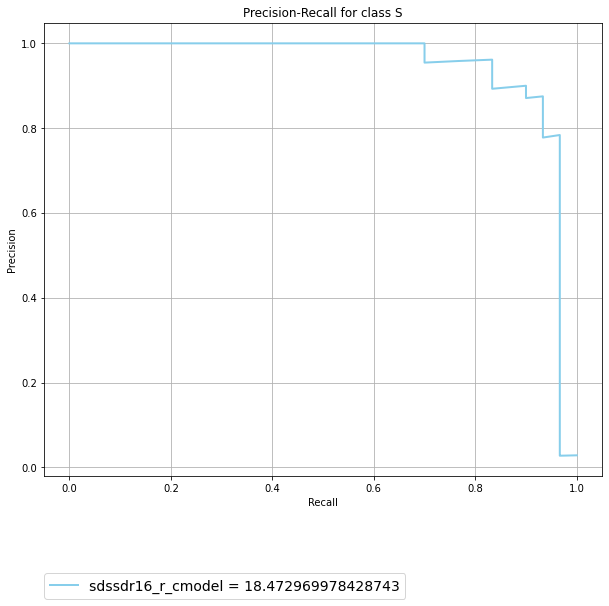

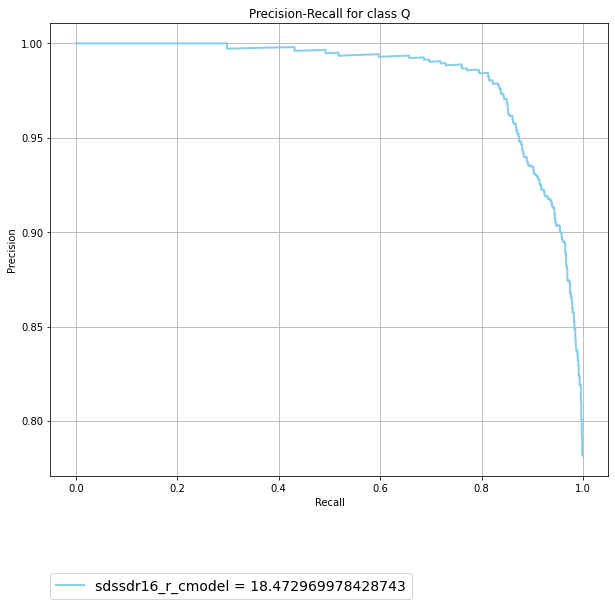

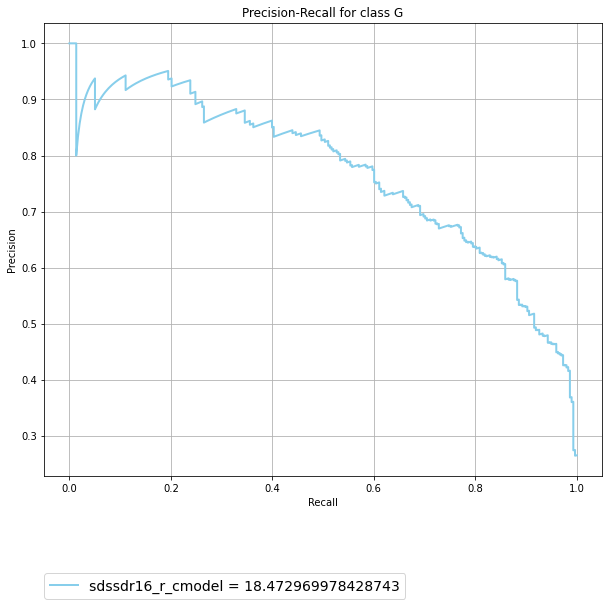

Classification Report: 
               precision    recall  f1-score   support

           1       0.34      0.97      0.50        30
           2       0.95      0.88      0.91      1164
           3       0.67      0.75      0.71       298

    accuracy                           0.85      1492
   macro avg       0.65      0.86      0.71      1492
weighted avg       0.88      0.85      0.86      1492

[[0.967 0.033 0.   ]
 [0.03  0.875 0.095]
 [0.07  0.178 0.752]]
saaaaaaaaaaaave


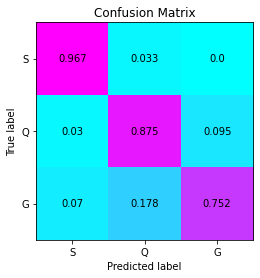

Classification Report: 
               precision    recall  f1-score   support

           1       0.34      0.97      0.50        30
           2       0.95      0.88      0.91      1164
           3       0.67      0.75      0.71       298

    accuracy                           0.85      1492
   macro avg       0.65      0.86      0.71      1492
weighted avg       0.88      0.85      0.86      1492

[[  29    1    0]
 [  35 1019  110]
 [  21   53  224]]
saaaaaaaaaaaave


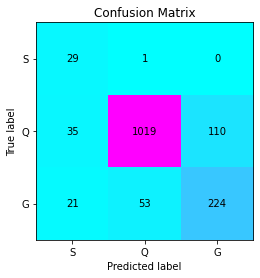

In [83]:
#accuracy = dict()
#brightness = dict()

#overview = 'sdssdr16+wise_decals8tr'
column = 'sdssdr16_r_cmodel'
model = 'tn_big_big2'
folder = f'{model}_on_target'
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
df1 = df[[column]+f[overview]+[class_row]].dropna()

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()
path = path + f'/{model}'
X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1


gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')#были обучены на маленьком датасете 
robust = joblib.load(f'{model_path}/{overview}_robust_for_gb.pkl') if model[:2] == 'gb' else None
path_for_all_model[model] = path

  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

In [84]:
tn = gb

In [85]:
tn

TabNetClassifier(n_d=32, n_a=32, n_steps=4, gamma=2.3696685979745844, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=3, n_shared=3, epsilon=1e-15, momentum=0.02, lambda_sparse=0.00837486406175253, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 200, 'gamma': 0.95}, mask_type='entmax', input_dim=42, output_dim=3, device_name='auto')

In [86]:
import gzip
import pickle
df_path = '/content/drive/MyDrive/Научная работа/Data/X-ray/x-ray_data.gz_pkl'#'/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_0/cv0.gz_pkl'
with gzip.open(df_path, 'rb') as fin:
    df_little = pickle.load(fin)
    df_little = df_little[[column] + features + ['Label', 'ra_x', 'dec_x']].dropna()

In [87]:
tabnet_fit_params1 = {
    'max_epochs' : 10, 
    'batch_size' : 1024,
    'patience' : 5,
    'virtual_batch_size' : 128,
    'num_workers' : 0,
    'weights' : 1,
    'drop_last' : False,
    #'from_unsupervised' : unsupervised_model
}

In [88]:
  data = df_little[[column]+f[overview]+['Label']].dropna()
  X = data.values
  np.random.shuffle(X)
  X_train = X_test = X[:, 1 : -1]
  y_train = y_test = X[:, -1].astype('int') + 1 

  t = time()
  tn.fit(X_train, y_train,  **tabnet_fit_params1)
  print(time()-t)
  tn_test_acc = accuracy_score(y_test[-500:], tn.predict(X_test[-500:]))
  print(tn_test_acc)


No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.11408 |  0:00:04s
epoch 1  | loss: 0.08545 |  0:00:10s
epoch 2  | loss: 0.07048 |  0:00:14s
epoch 3  | loss: 0.07318 |  0:00:19s
epoch 4  | loss: 0.06372 |  0:00:24s
epoch 5  | loss: 0.06237 |  0:00:28s
epoch 6  | loss: 0.06054 |  0:00:33s
epoch 7  | loss: 0.05485 |  0:00:37s
epoch 8  | loss: 0.05491 |  0:00:42s
epoch 9  | loss: 0.05508 |  0:00:46s
47.647433042526245
0.976


Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_and_little_on_target уже существует
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_and_little_on_target/tn_big_and_little уже существует


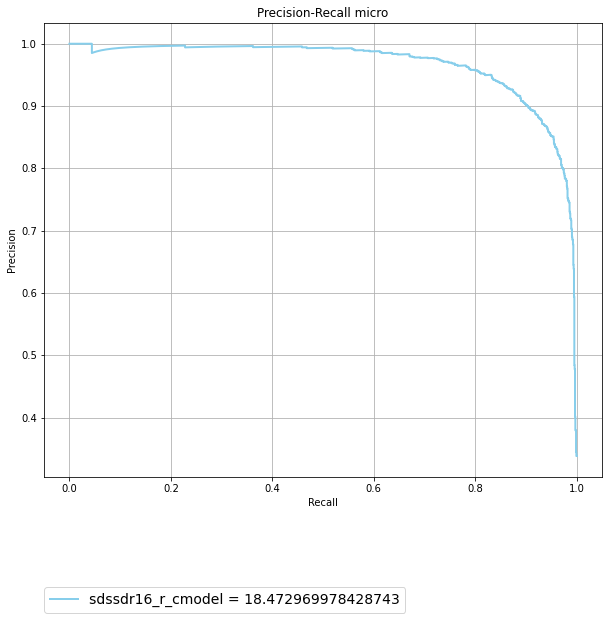

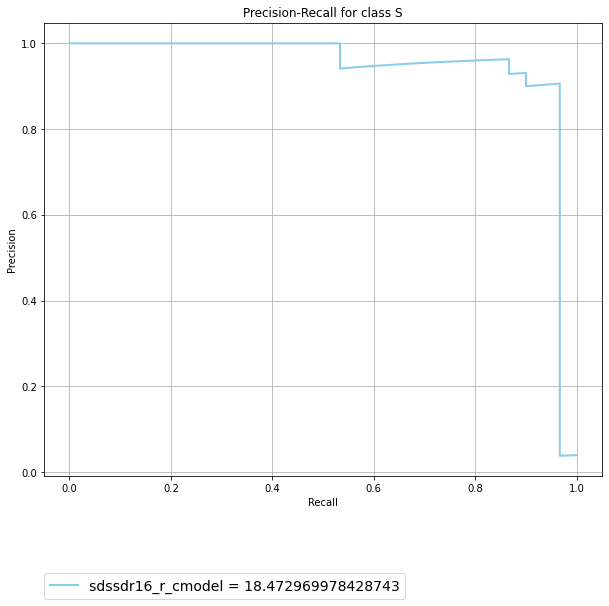

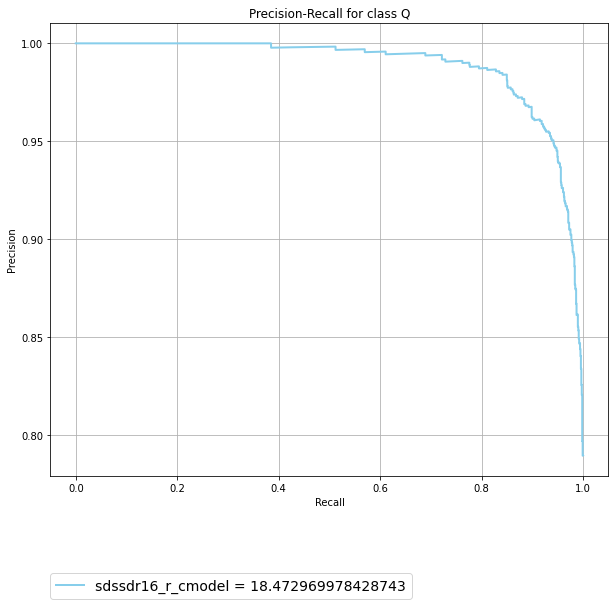

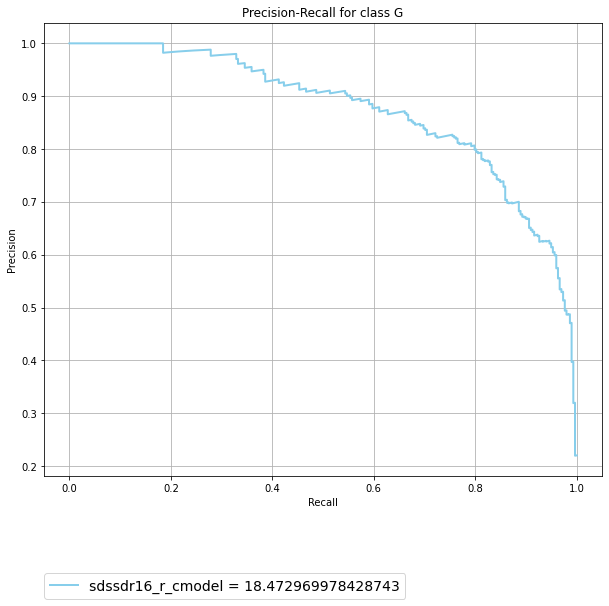

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.97      0.92        30
           2       0.96      0.91      0.93      1164
           3       0.72      0.86      0.78       298

    accuracy                           0.90      1492
   macro avg       0.85      0.91      0.88      1492
weighted avg       0.91      0.90      0.90      1492

[[0.967 0.033 0.   ]
 [0.003 0.91  0.087]
 [0.    0.141 0.859]]
saaaaaaaaaaaave


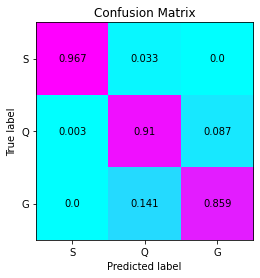

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.97      0.92        30
           2       0.96      0.91      0.93      1164
           3       0.72      0.86      0.78       298

    accuracy                           0.90      1492
   macro avg       0.85      0.91      0.88      1492
weighted avg       0.91      0.90      0.90      1492

[[  29    1    0]
 [   4 1059  101]
 [   0   42  256]]
saaaaaaaaaaaave


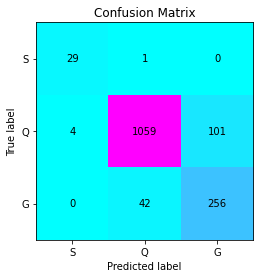

In [89]:
column = 'sdssdr16_r_cmodel'
model = 'tn_big_and_little'
folder = f'{model}_on_target'
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
df1 = df[[column]+f[overview]+[class_row]].dropna()

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()
path = path + f'/{model}'
X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1


gb = tn
try:
    os.makedirs(model_path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()
joblib.dump(tn, f'{model_path}/model_'+overview+'.pkl')
robust = None
path_for_all_model[model] = path

  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

In [90]:
path_for_all_model.keys()

dict_keys(['gb', 'tn', 'gb_big_big', 'tn_big_big', 'tn_big_big2', 'tn_big_and_little'])

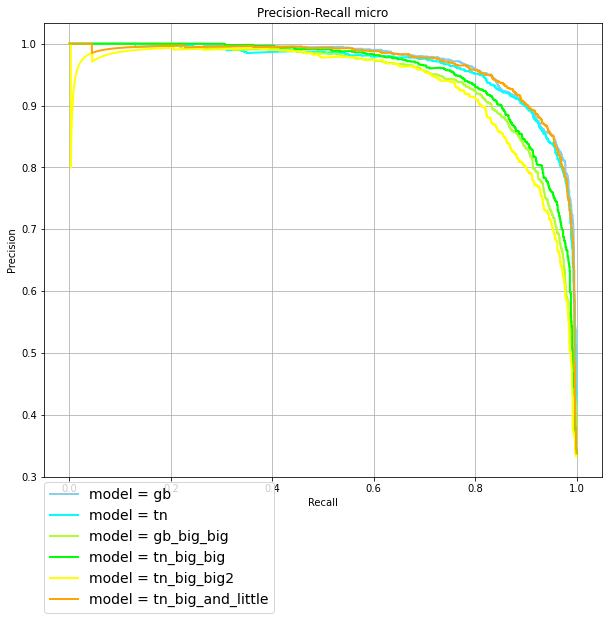

In [91]:
plt.figure(figsize=(10, 10))
lab = path_for_all_model.keys()
lines = []
labels = []
clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']
j=0
for key in lab:
  file_name = path_for_all_model[key]
  acc = np.loadtxt(file_name+'Precision_Recall_micro.txt')
  l, = plt.plot(acc[1], acc[0], color=clr[j], lw=2)
  lines.append(l)
  labels.append(f"model = {key}")
  j+=1



fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall micro')
plt.grid(True)
#plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
plt.savefig("/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_target/"+'Precision_Recall_micro.png')
plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
plt.savefig("/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_target/"+'Precision_Recall_micro_legend.png')

plt.show()

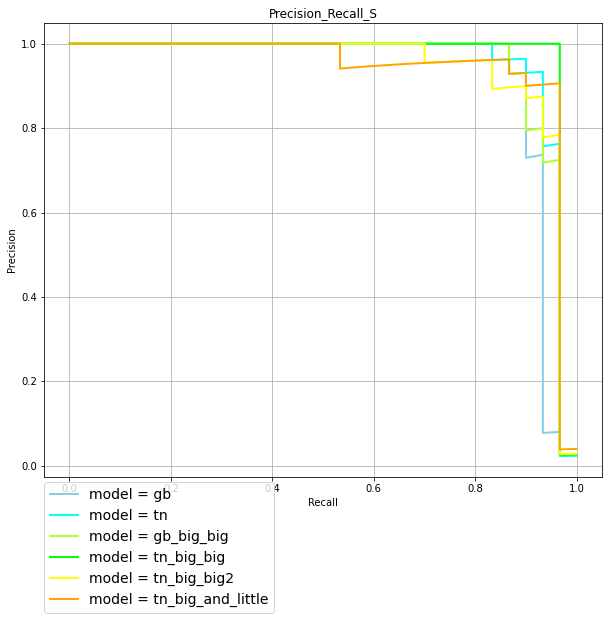

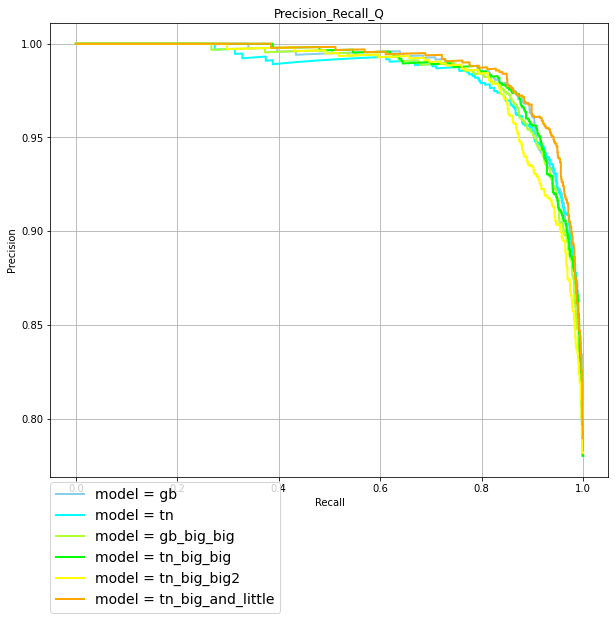

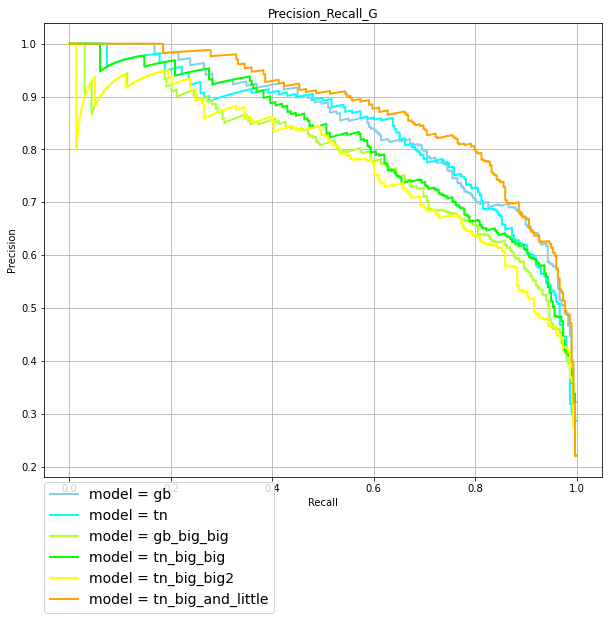

In [92]:
classes = {1: 'S', 2: 'Q', 3: 'G'}

for i in range(1, 4):
  plt.figure(figsize=(10, 10))
  lines = []
  labels = []
  j=0
  for key in lab:
    file_name = path_for_all_model[key]
    acc = np.loadtxt(file_name+f'Precision_Recall_{classes[i]}.txt')
    #print(acc.shape)
    l, = plt.plot(acc[:, 1], acc[:, 0], color=clr[j], lw=2)
    lines.append(l)
    labels.append(f"model = {key}")
    j+=1
    
  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(f'Precision_Recall_{classes[i]}')
  plt.grid(True)
  #plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
  plt.savefig("/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_target/"+f'Precision_Recall_{classes[i]}.png')
  plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
  plt.savefig("/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_target/"+f'Precision_Recall_{classes[i]}_legend.png')

  plt.show()

##В зависимости от рентгеновского потока

In [135]:
path_for_all_model = dict()

(20_or_less)
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_on_target_Fx(20_or_less) уже существует
gb
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.95      0.98        22
           2       0.95      0.92      0.93       295
           3       0.83      0.91      0.87       132

    accuracy                           0.92       449
   macro avg       0.93      0.93      0.93       449
weighted avg       0.92      0.92      0.92       449

[[0.955 0.045 0.   ]
 [0.    0.915 0.085]
 [0.    0.091 0.909]]
saaaaaaaaaaaave


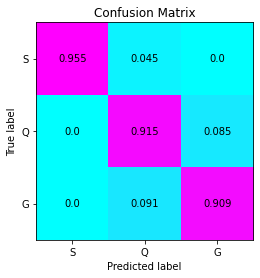

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.95      0.98        22
           2       0.95      0.92      0.93       295
           3       0.83      0.91      0.87       132

    accuracy                           0.92       449
   macro avg       0.93      0.93      0.93       449
weighted avg       0.92      0.92      0.92       449

[[ 21   1   0]
 [  0 270  25]
 [  0  12 120]]
saaaaaaaaaaaave


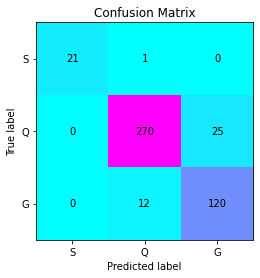

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_on_target_Fx(20_or_less) уже существует
tn
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.95      0.98        22
           2       0.97      0.88      0.92       295
           3       0.78      0.94      0.86       132

    accuracy                           0.90       449
   macro avg       0.92      0.93      0.92       449
weighted avg       0.91      0.90      0.91       449

[[0.955 0.045 0.   ]
 [0.    0.885 0.115]
 [0.    0.061 0.939]]
saaaaaaaaaaaave


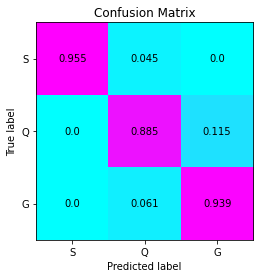

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.95      0.98        22
           2       0.97      0.88      0.92       295
           3       0.78      0.94      0.86       132

    accuracy                           0.90       449
   macro avg       0.92      0.93      0.92       449
weighted avg       0.91      0.90      0.91       449

[[ 21   1   0]
 [  0 261  34]
 [  0   8 124]]
saaaaaaaaaaaave


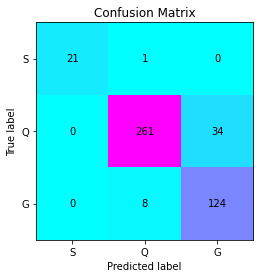

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_big_big_on_target_Fx(20_or_less) уже существует
gb_big_big
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        22
           2       0.98      0.88      0.93       295
           3       0.78      0.96      0.86       132

    accuracy                           0.91       449
   macro avg       0.92      0.95      0.93       449
weighted avg       0.92      0.91      0.91       449

[[1.    0.    0.   ]
 [0.    0.878 0.122]
 [0.    0.038 0.962]]
saaaaaaaaaaaave


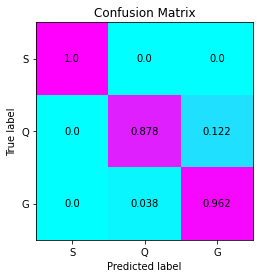

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        22
           2       0.98      0.88      0.93       295
           3       0.78      0.96      0.86       132

    accuracy                           0.91       449
   macro avg       0.92      0.95      0.93       449
weighted avg       0.92      0.91      0.91       449

[[ 22   0   0]
 [  0 259  36]
 [  0   5 127]]
saaaaaaaaaaaave


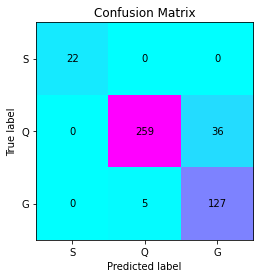

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big_on_target_Fx(20_or_less) уже существует
tn_big_big
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        22
           2       0.97      0.88      0.93       295
           3       0.78      0.94      0.86       132

    accuracy                           0.91       449
   macro avg       0.92      0.94      0.93       449
weighted avg       0.92      0.91      0.91       449

[[1.    0.    0.   ]
 [0.    0.885 0.115]
 [0.    0.061 0.939]]
saaaaaaaaaaaave


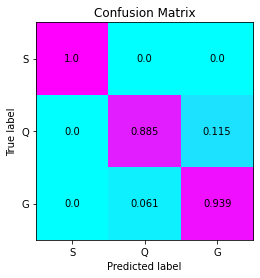

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        22
           2       0.97      0.88      0.93       295
           3       0.78      0.94      0.86       132

    accuracy                           0.91       449
   macro avg       0.92      0.94      0.93       449
weighted avg       0.92      0.91      0.91       449

[[ 22   0   0]
 [  0 261  34]
 [  0   8 124]]
saaaaaaaaaaaave


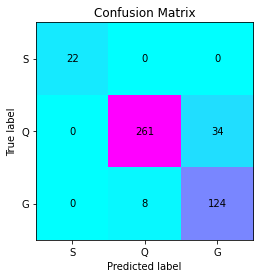

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big2_on_target_Fx(20_or_less) уже существует
tn_big_big2
Classification Report: 
               precision    recall  f1-score   support

           1       0.96      1.00      0.98        22
           2       0.98      0.86      0.91       295
           3       0.75      0.95      0.84       132

    accuracy                           0.89       449
   macro avg       0.90      0.94      0.91       449
weighted avg       0.91      0.89      0.90       449

[[1.    0.    0.   ]
 [0.003 0.858 0.139]
 [0.    0.045 0.955]]
saaaaaaaaaaaave


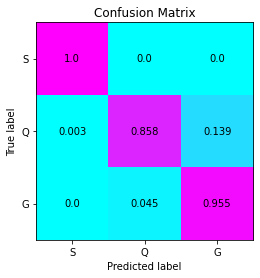

Classification Report: 
               precision    recall  f1-score   support

           1       0.96      1.00      0.98        22
           2       0.98      0.86      0.91       295
           3       0.75      0.95      0.84       132

    accuracy                           0.89       449
   macro avg       0.90      0.94      0.91       449
weighted avg       0.91      0.89      0.90       449

[[ 22   0   0]
 [  1 253  41]
 [  0   6 126]]
saaaaaaaaaaaave


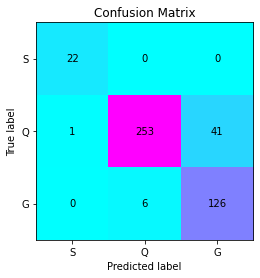

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_and_little_on_target_Fx(20_or_less) уже существует
tn_big_and_little
Classification Report: 
               precision    recall  f1-score   support

           1       0.85      1.00      0.92        22
           2       0.97      0.90      0.93       295
           3       0.83      0.94      0.88       132

    accuracy                           0.92       449
   macro avg       0.88      0.95      0.91       449
weighted avg       0.92      0.92      0.92       449

[[1.    0.    0.   ]
 [0.014 0.898 0.088]
 [0.    0.061 0.939]]
saaaaaaaaaaaave


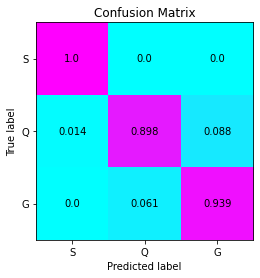

Classification Report: 
               precision    recall  f1-score   support

           1       0.85      1.00      0.92        22
           2       0.97      0.90      0.93       295
           3       0.83      0.94      0.88       132

    accuracy                           0.92       449
   macro avg       0.88      0.95      0.91       449
weighted avg       0.92      0.92      0.92       449

[[ 22   0   0]
 [  4 265  26]
 [  0   8 124]]
saaaaaaaaaaaave


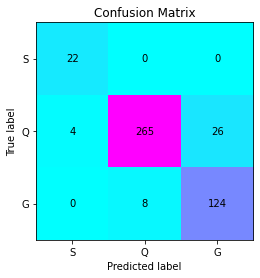

(20_to_21.3)
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_on_target_Fx(20_to_21.3) уже существует
gb
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.33      0.50         6
           2       0.95      0.94      0.95       475
           3       0.67      0.76      0.71        74

    accuracy                           0.91       555
   macro avg       0.88      0.68      0.72       555
weighted avg       0.92      0.91      0.91       555

[[0.333 0.667 0.   ]
 [0.    0.943 0.057]
 [0.    0.243 0.757]]
saaaaaaaaaaaave


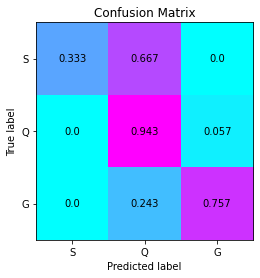

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.33      0.50         6
           2       0.95      0.94      0.95       475
           3       0.67      0.76      0.71        74

    accuracy                           0.91       555
   macro avg       0.88      0.68      0.72       555
weighted avg       0.92      0.91      0.91       555

[[  2   4   0]
 [  0 448  27]
 [  0  18  56]]
saaaaaaaaaaaave


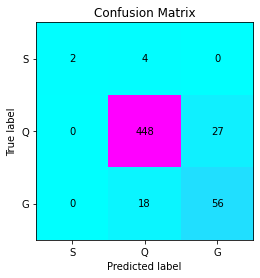

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_on_target_Fx(20_to_21.3) уже существует
tn
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.33      0.50         6
           2       0.96      0.94      0.95       475
           3       0.68      0.81      0.74        74

    accuracy                           0.92       555
   macro avg       0.88      0.70      0.73       555
weighted avg       0.93      0.92      0.92       555

[[0.333 0.5   0.167]
 [0.    0.943 0.057]
 [0.    0.189 0.811]]
saaaaaaaaaaaave


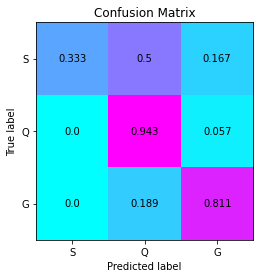

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.33      0.50         6
           2       0.96      0.94      0.95       475
           3       0.68      0.81      0.74        74

    accuracy                           0.92       555
   macro avg       0.88      0.70      0.73       555
weighted avg       0.93      0.92      0.92       555

[[  2   3   1]
 [  0 448  27]
 [  0  14  60]]
saaaaaaaaaaaave


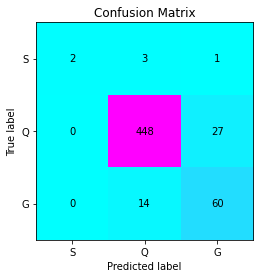

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_big_big_on_target_Fx(20_to_21.3) уже существует
gb_big_big
Classification Report: 
               precision    recall  f1-score   support

           1       0.71      0.83      0.77         6
           2       0.97      0.94      0.95       475
           3       0.68      0.80      0.73        74

    accuracy                           0.92       555
   macro avg       0.79      0.86      0.82       555
weighted avg       0.93      0.92      0.92       555

[[0.833 0.167 0.   ]
 [0.002 0.939 0.059]
 [0.014 0.189 0.797]]
saaaaaaaaaaaave


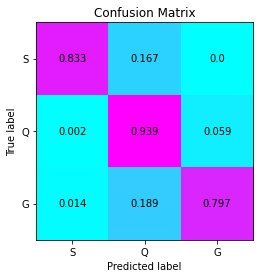

Classification Report: 
               precision    recall  f1-score   support

           1       0.71      0.83      0.77         6
           2       0.97      0.94      0.95       475
           3       0.68      0.80      0.73        74

    accuracy                           0.92       555
   macro avg       0.79      0.86      0.82       555
weighted avg       0.93      0.92      0.92       555

[[  5   1   0]
 [  1 446  28]
 [  1  14  59]]
saaaaaaaaaaaave


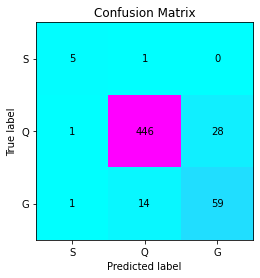

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big_on_target_Fx(20_to_21.3) уже существует
tn_big_big
Classification Report: 
               precision    recall  f1-score   support

           1       0.83      0.83      0.83         6
           2       0.98      0.93      0.96       475
           3       0.67      0.89      0.77        74

    accuracy                           0.93       555
   macro avg       0.83      0.89      0.85       555
weighted avg       0.94      0.93      0.93       555

[[0.833 0.167 0.   ]
 [0.    0.933 0.067]
 [0.014 0.095 0.892]]
saaaaaaaaaaaave


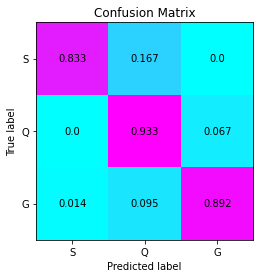

Classification Report: 
               precision    recall  f1-score   support

           1       0.83      0.83      0.83         6
           2       0.98      0.93      0.96       475
           3       0.67      0.89      0.77        74

    accuracy                           0.93       555
   macro avg       0.83      0.89      0.85       555
weighted avg       0.94      0.93      0.93       555

[[  5   1   0]
 [  0 443  32]
 [  1   7  66]]
saaaaaaaaaaaave


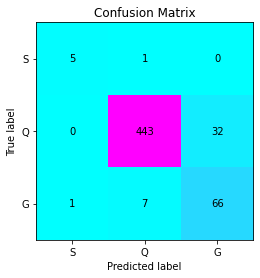

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big2_on_target_Fx(20_to_21.3) уже существует
tn_big_big2
Classification Report: 
               precision    recall  f1-score   support

           1       0.71      0.83      0.77         6
           2       0.97      0.92      0.95       475
           3       0.65      0.85      0.74        74

    accuracy                           0.91       555
   macro avg       0.78      0.87      0.82       555
weighted avg       0.93      0.91      0.92       555

[[0.833 0.167 0.   ]
 [0.004 0.924 0.072]
 [0.    0.149 0.851]]
saaaaaaaaaaaave


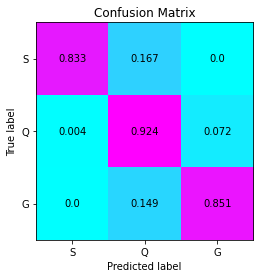

Classification Report: 
               precision    recall  f1-score   support

           1       0.71      0.83      0.77         6
           2       0.97      0.92      0.95       475
           3       0.65      0.85      0.74        74

    accuracy                           0.91       555
   macro avg       0.78      0.87      0.82       555
weighted avg       0.93      0.91      0.92       555

[[  5   1   0]
 [  2 439  34]
 [  0  11  63]]
saaaaaaaaaaaave


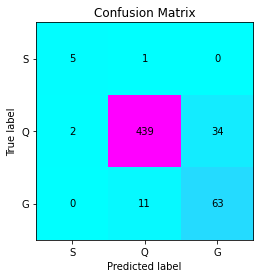

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_and_little_on_target_Fx(20_to_21.3) уже существует
tn_big_and_little
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.83      0.91         6
           2       0.97      0.93      0.95       475
           3       0.64      0.84      0.73        74

    accuracy                           0.91       555
   macro avg       0.87      0.87      0.86       555
weighted avg       0.93      0.91      0.92       555

[[0.833 0.167 0.   ]
 [0.    0.926 0.074]
 [0.    0.162 0.838]]
saaaaaaaaaaaave


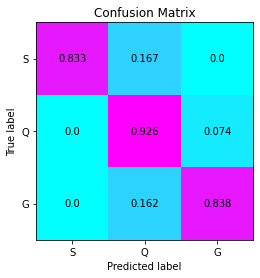

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.83      0.91         6
           2       0.97      0.93      0.95       475
           3       0.64      0.84      0.73        74

    accuracy                           0.91       555
   macro avg       0.87      0.87      0.86       555
weighted avg       0.93      0.91      0.92       555

[[  5   1   0]
 [  0 440  35]
 [  0  12  62]]
saaaaaaaaaaaave


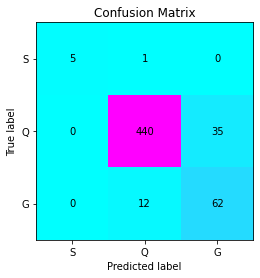

(21.3_and_more)
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_on_target_Fx(21.3_and_more) уже существует
gb
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.89      0.97      0.93       394
           3       0.80      0.47      0.59        92

    accuracy                           0.88       488
   macro avg       0.89      0.81      0.84       488
weighted avg       0.87      0.88      0.86       488

[[1.    0.    0.   ]
 [0.    0.972 0.028]
 [0.    0.533 0.467]]
saaaaaaaaaaaave


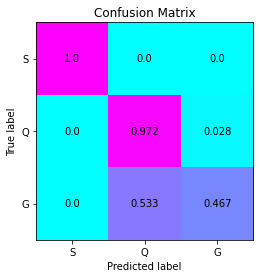

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.89      0.97      0.93       394
           3       0.80      0.47      0.59        92

    accuracy                           0.88       488
   macro avg       0.89      0.81      0.84       488
weighted avg       0.87      0.88      0.86       488

[[  2   0   0]
 [  0 383  11]
 [  0  49  43]]
saaaaaaaaaaaave


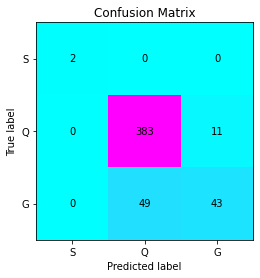

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_on_target_Fx(21.3_and_more) уже существует
tn
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.89      0.95      0.92       394
           3       0.72      0.52      0.60        92

    accuracy                           0.87       488
   macro avg       0.87      0.82      0.84       488
weighted avg       0.86      0.87      0.86       488

[[1.    0.    0.   ]
 [0.    0.952 0.048]
 [0.    0.478 0.522]]
saaaaaaaaaaaave


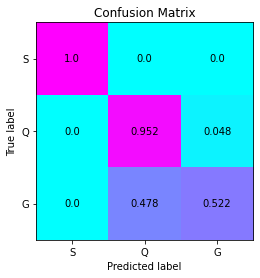

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.89      0.95      0.92       394
           3       0.72      0.52      0.60        92

    accuracy                           0.87       488
   macro avg       0.87      0.82      0.84       488
weighted avg       0.86      0.87      0.86       488

[[  2   0   0]
 [  0 375  19]
 [  0  44  48]]
saaaaaaaaaaaave


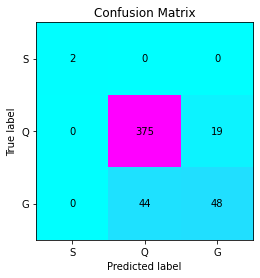

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_big_big_on_target_Fx(21.3_and_more) уже существует
gb_big_big
Classification Report: 
               precision    recall  f1-score   support

           1       0.04      1.00      0.08         2
           2       0.90      0.88      0.89       394
           3       0.50      0.29      0.37        92

    accuracy                           0.77       488
   macro avg       0.48      0.72      0.45       488
weighted avg       0.82      0.77      0.79       488

[[1.    0.    0.   ]
 [0.053 0.878 0.069]
 [0.304 0.402 0.293]]
saaaaaaaaaaaave


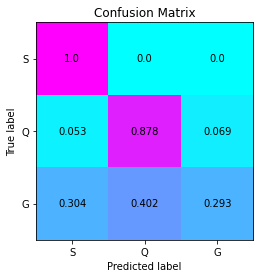

Classification Report: 
               precision    recall  f1-score   support

           1       0.04      1.00      0.08         2
           2       0.90      0.88      0.89       394
           3       0.50      0.29      0.37        92

    accuracy                           0.77       488
   macro avg       0.48      0.72      0.45       488
weighted avg       0.82      0.77      0.79       488

[[  2   0   0]
 [ 21 346  27]
 [ 28  37  27]]
saaaaaaaaaaaave


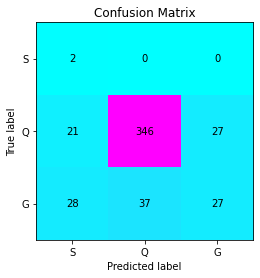

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big_on_target_Fx(21.3_and_more) уже существует
tn_big_big
Classification Report: 
               precision    recall  f1-score   support

           1       0.05      1.00      0.10         2
           2       0.93      0.84      0.88       394
           3       0.49      0.50      0.50        92

    accuracy                           0.78       488
   macro avg       0.49      0.78      0.49       488
weighted avg       0.84      0.78      0.81       488

[[1.    0.    0.   ]
 [0.038 0.843 0.119]
 [0.217 0.283 0.5  ]]
saaaaaaaaaaaave


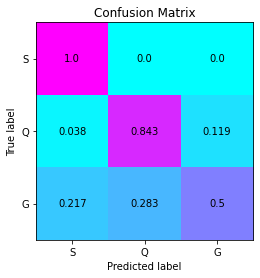

Classification Report: 
               precision    recall  f1-score   support

           1       0.05      1.00      0.10         2
           2       0.93      0.84      0.88       394
           3       0.49      0.50      0.50        92

    accuracy                           0.78       488
   macro avg       0.49      0.78      0.49       488
weighted avg       0.84      0.78      0.81       488

[[  2   0   0]
 [ 15 332  47]
 [ 20  26  46]]
saaaaaaaaaaaave


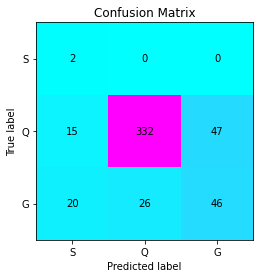

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big2_on_target_Fx(21.3_and_more) уже существует
tn_big_big2
Classification Report: 
               precision    recall  f1-score   support

           1       0.04      1.00      0.07         2
           2       0.90      0.83      0.86       394
           3       0.50      0.38      0.43        92

    accuracy                           0.75       488
   macro avg       0.48      0.74      0.46       488
weighted avg       0.82      0.75      0.78       488

[[1.    0.    0.   ]
 [0.081 0.83  0.089]
 [0.228 0.391 0.38 ]]
saaaaaaaaaaaave


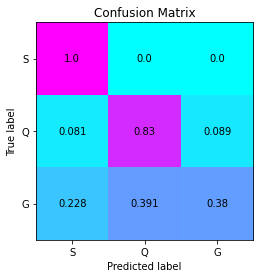

Classification Report: 
               precision    recall  f1-score   support

           1       0.04      1.00      0.07         2
           2       0.90      0.83      0.86       394
           3       0.50      0.38      0.43        92

    accuracy                           0.75       488
   macro avg       0.48      0.74      0.46       488
weighted avg       0.82      0.75      0.78       488

[[  2   0   0]
 [ 32 327  35]
 [ 21  36  35]]
saaaaaaaaaaaave


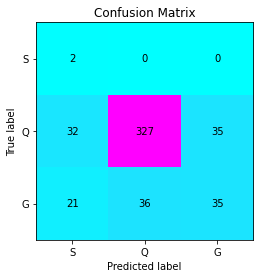

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_and_little_on_target_Fx(21.3_and_more) уже существует
tn_big_and_little
Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.94      0.90      0.92       394
           3       0.64      0.76      0.69        92

    accuracy                           0.87       488
   macro avg       0.86      0.89      0.87       488
weighted avg       0.88      0.87      0.88       488

[[1.    0.    0.   ]
 [0.    0.898 0.102]
 [0.    0.239 0.761]]
saaaaaaaaaaaave


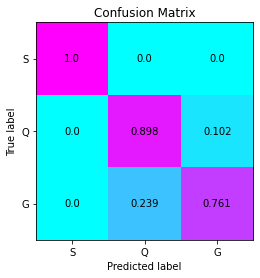

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.94      0.90      0.92       394
           3       0.64      0.76      0.69        92

    accuracy                           0.87       488
   macro avg       0.86      0.89      0.87       488
weighted avg       0.88      0.87      0.88       488

[[  2   0   0]
 [  0 354  40]
 [  0  22  70]]
saaaaaaaaaaaave


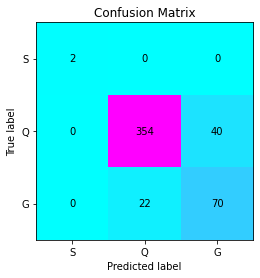

In [171]:
overview = "sdssdr16+psdr2+all_decals8tr"
column = 'sdssdr16_r_cmodel'
vol_mat = [0, 20, 21.3, 200]
model_mat = ['gb', 'tn', 'gb_big_big', 'tn_big_big', 'tn_big_big2', 'tn_big_and_little']
for i in range(len(vol_mat)-1):
  vol_max = vol_mat[i+1]
  vol_min = vol_mat[i]
  if vol_min > 0:
    if vol_max<200:
      vol = f'({vol_min}_to_{vol_max})'
    else:
      vol = f'({vol_min}_and_more)'
  else:
    if vol_max<200:
      vol = f'({vol_max}_or_less)'
    else:
      vol = f'(all)'
  print('\033[1m' + vol + '\033[0m')
  df1 = df[[column]+f[overview]+[class_row]].dropna()
  df1 = df1[(df1[column] >= vol_min) & (df1[column] <= vol_max)]
  for model in model_mat:
    folder = f'{model}_on_target_Fx{vol}'#folder = f'{model}_on_target_Fx{vol1}<{vol2}'
    model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
    class_row = 'Label'
    import os
    path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

    try:
        os.makedirs(path)
    except FileExistsError:
      print("Директория %s уже существует" % path) 
    except OSError:
        print ("Создать директорию %s не удалось" % path)
        exit()

    X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
    X2, y2 = X1, y1
    path = path + f'/{model}'

    gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')
    rob_mod = 'gb_big' if 'big_big' in model else 'gb' 
    robust = joblib.load(f'{model_path}/{overview}_robust_for_{rob_mod}.pkl') if 'gb' in model else None
    path_for_all_model[model] = path
    #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
    #Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
    print('\033[91m' + model + '\033[0m')
    Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
    Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)
  

In [159]:
mod = 'gb'
'big_big' in mod

False

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_on_target_Fx3e-15 уже существует


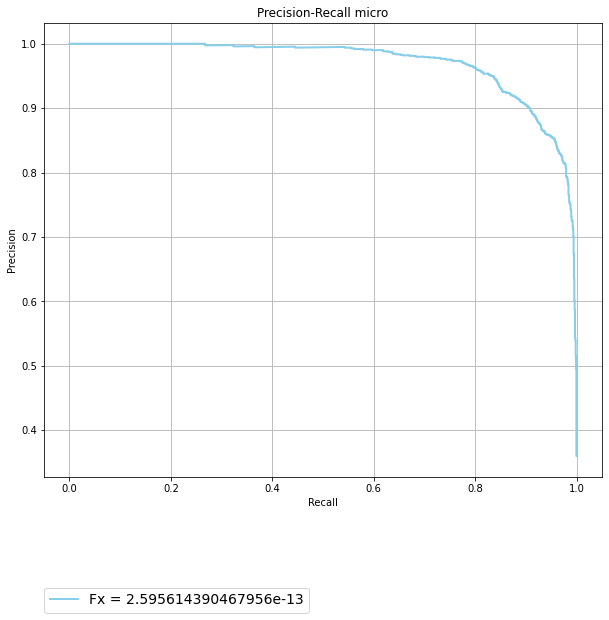

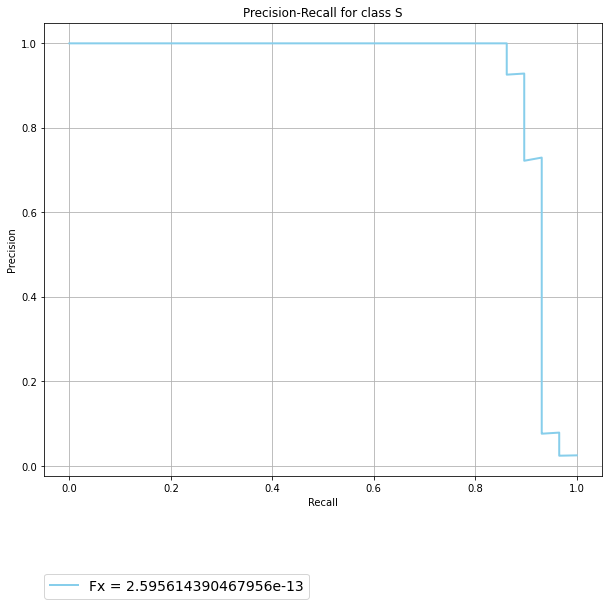

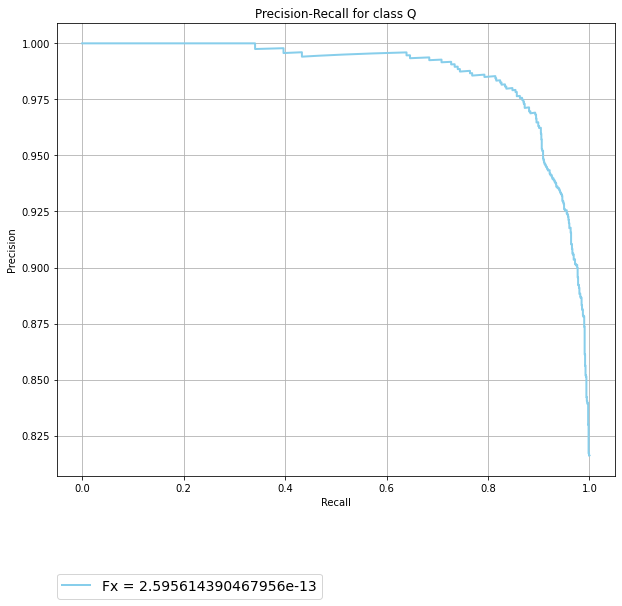

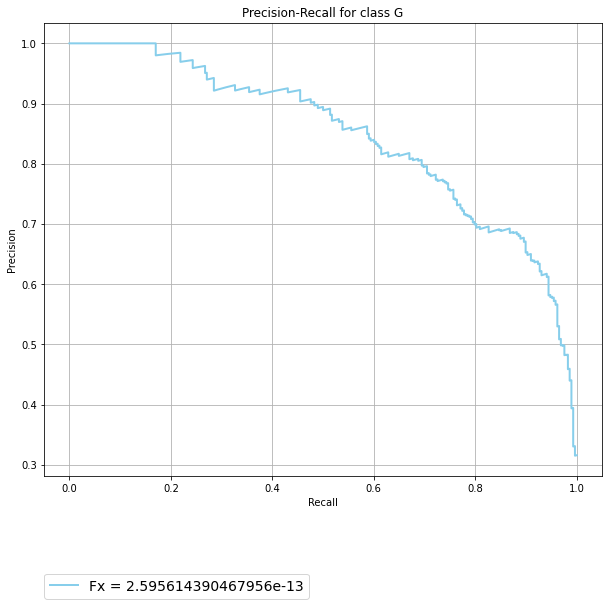

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.86      0.93        29
           2       0.93      0.95      0.94      1159
           3       0.77      0.74      0.75       288

    accuracy                           0.90      1476
   macro avg       0.90      0.85      0.87      1476
weighted avg       0.90      0.90      0.90      1476

[[0.862 0.138 0.   ]
 [0.    0.947 0.053]
 [0.    0.264 0.736]]
saaaaaaaaaaaave


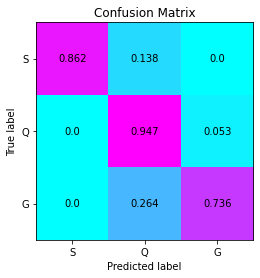

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.86      0.93        29
           2       0.93      0.95      0.94      1159
           3       0.77      0.74      0.75       288

    accuracy                           0.90      1476
   macro avg       0.90      0.85      0.87      1476
weighted avg       0.90      0.90      0.90      1476

[[  25    4    0]
 [   0 1097   62]
 [   0   76  212]]
saaaaaaaaaaaave


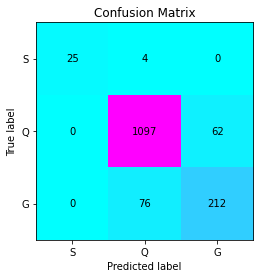

In [149]:
overview = "sdssdr16+psdr2+all_decals8tr"
column = 'Fx'
vol = 3e-15
vol1 = 1e-14
vol2 = 4e-14
model = 'gb'
folder = f'{model}_on_target_Fx{vol}'#folder = f'{model}_on_target_Fx{vol1}<{vol2}'
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
df1 = df[[column]+f[overview]+[class_row]].dropna()
df1 = df1[(df1[column] >= vol)]

#df1 = df1[(df1[column] >= vol1) & (df1[column] <= vol2)]
import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1
path = path + f'/{model}'

gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')#были обучены на маленьком датасете 
robust = joblib.load(f'{model_path}/{overview}_robust_for_gb.pkl') if model[:2] == 'gb' else None
path_for_all_model[model] = path

  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
#Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
print(model)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_on_target_Fx3e-15 уже существует


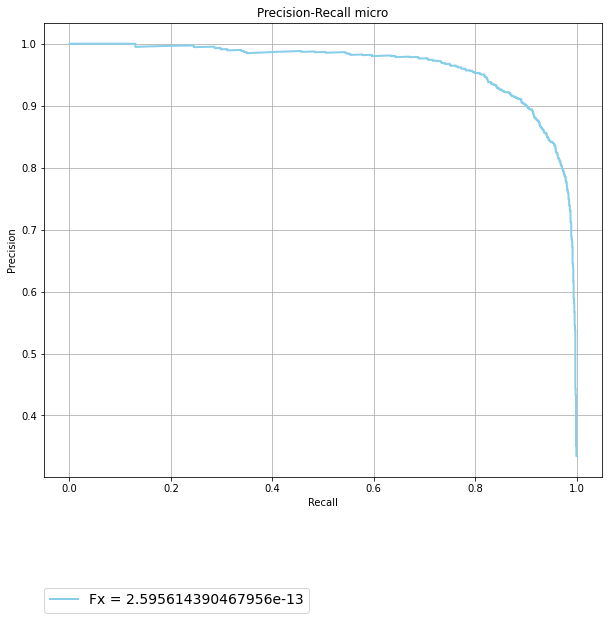

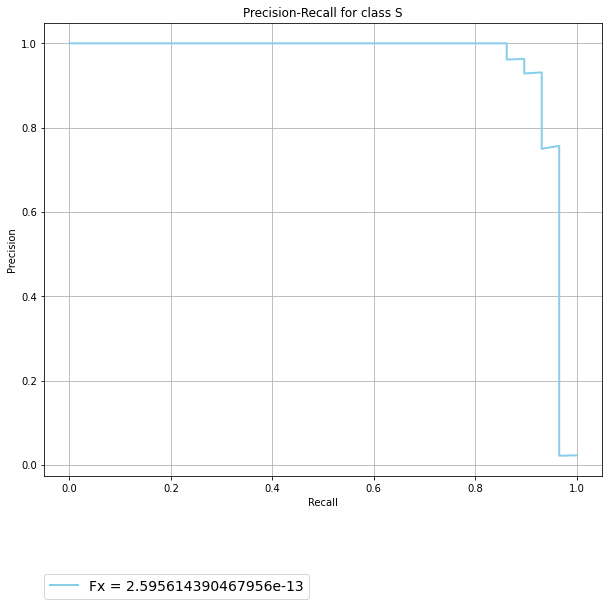

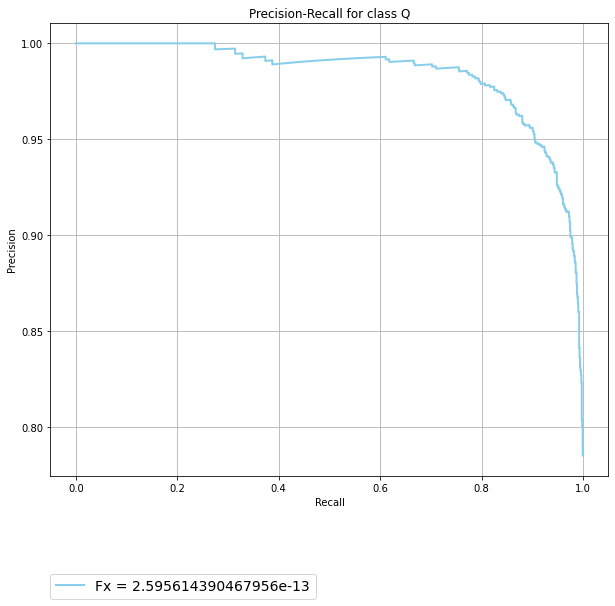

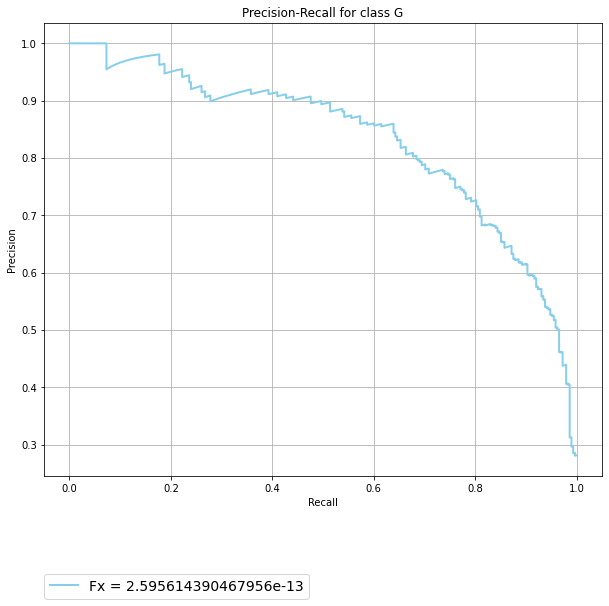

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.86      0.93        29
           2       0.94      0.93      0.94      1159
           3       0.74      0.78      0.76       288

    accuracy                           0.90      1476
   macro avg       0.89      0.86      0.87      1476
weighted avg       0.90      0.90      0.90      1476

[[0.862 0.138 0.   ]
 [0.    0.932 0.068]
 [0.    0.222 0.778]]
saaaaaaaaaaaave


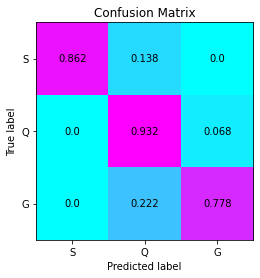

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.86      0.93        29
           2       0.94      0.93      0.94      1159
           3       0.74      0.78      0.76       288

    accuracy                           0.90      1476
   macro avg       0.89      0.86      0.87      1476
weighted avg       0.90      0.90      0.90      1476

[[  25    4    0]
 [   0 1080   79]
 [   0   64  224]]
saaaaaaaaaaaave


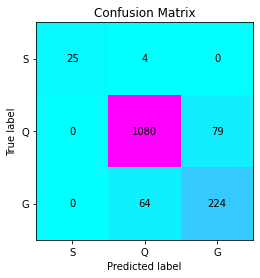

In [150]:
#accuracy = dict()
#brightness = dict()

overview = "sdssdr16+psdr2+all_decals8tr"
column = 'Fx'
#vol = 4e-14
model = 'tn'
folder = f'{model}_on_target_Fx{vol}'#folder = f'{model}_on_target_Fx{vol1}<{vol2}'#
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
#df1 = df[[column]+f[overview]+[class_row]].dropna()
#df1 = df1[df1[column] >= vol]
import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1
path = path + f'/{model}'

gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')#были обучены на маленьком датасете 
robust = joblib.load(f'{model_path}/{overview}_robust_for_gb.pkl') if model[:2] == 'gb' else None

path_for_all_model[model] = path


  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_big_big_on_target_Fx3e-15 уже существует


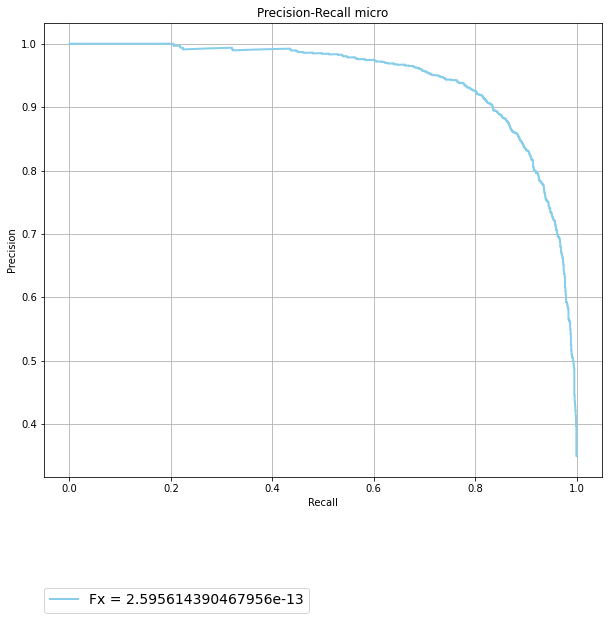

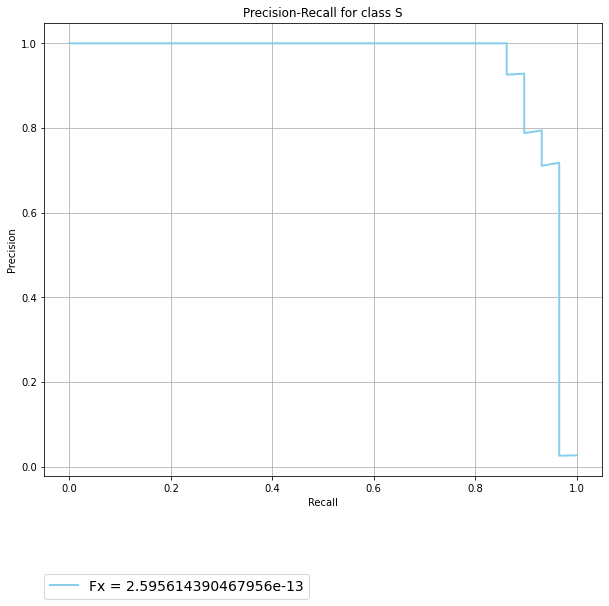

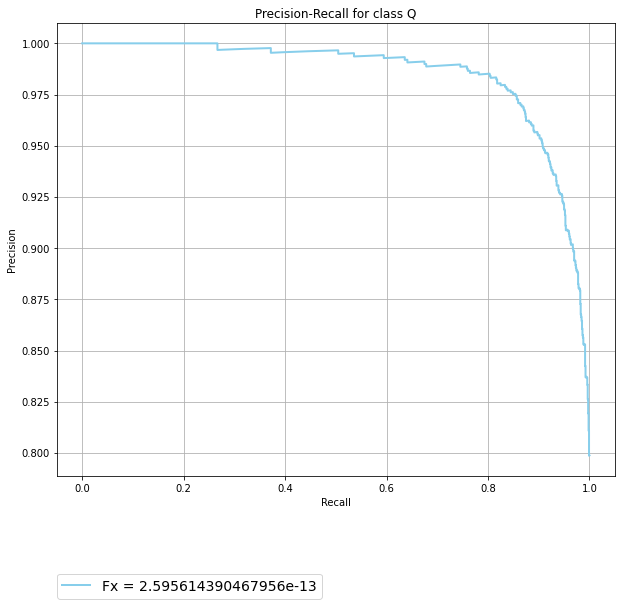

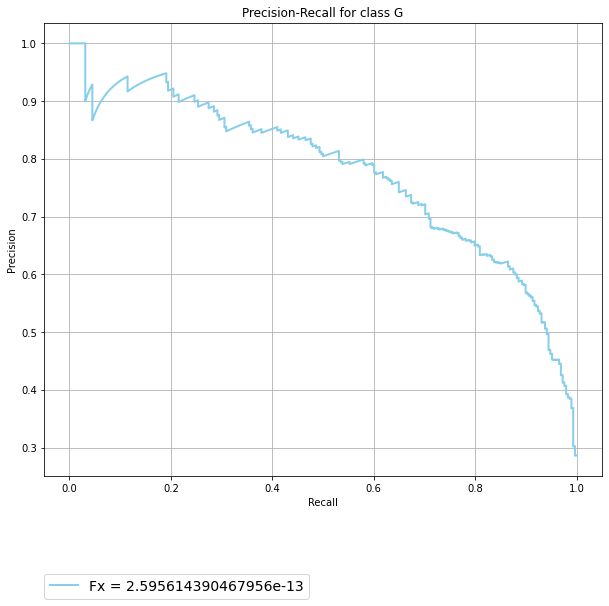

Classification Report: 
               precision    recall  f1-score   support

           1       0.36      0.97      0.53        29
           2       0.95      0.90      0.93      1159
           3       0.69      0.72      0.71       288

    accuracy                           0.87      1476
   macro avg       0.67      0.86      0.72      1476
weighted avg       0.89      0.87      0.88      1476

[[0.966 0.034 0.   ]
 [0.018 0.903 0.079]
 [0.097 0.184 0.719]]
saaaaaaaaaaaave


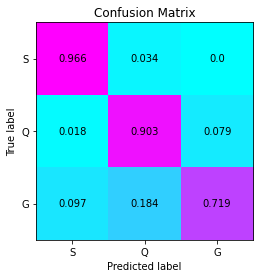

Classification Report: 
               precision    recall  f1-score   support

           1       0.36      0.97      0.53        29
           2       0.95      0.90      0.93      1159
           3       0.69      0.72      0.71       288

    accuracy                           0.87      1476
   macro avg       0.67      0.86      0.72      1476
weighted avg       0.89      0.87      0.88      1476

[[  28    1    0]
 [  21 1047   91]
 [  28   53  207]]
saaaaaaaaaaaave


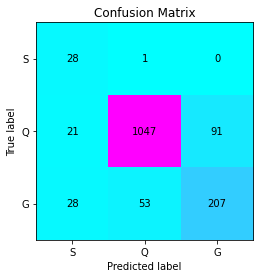

In [151]:
#accuracy = dict()
#brightness = dict()

overview = "sdssdr16+psdr2+all_decals8tr"
column = 'Fx'
#vol = 4e-14
model = 'gb_big_big'
folder = f'{model}_on_target_Fx{vol}'#folder = f'{model}_on_target_Fx{vol1}<{vol2}'#
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
#df1 = df[[column]+f[overview]+[class_row]].dropna()
#df1 = df1[df1[column] >= vol ]
import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()
path = path + f'/{model}'
X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1


gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')#были обучены на маленьком датасете 
robust = joblib.load(f'{model_path}/{overview}_robust_for_gb_big.pkl') if model[:2] == 'gb' else None

path_for_all_model[model] = path


  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big_on_target_Fx3e-15 уже существует


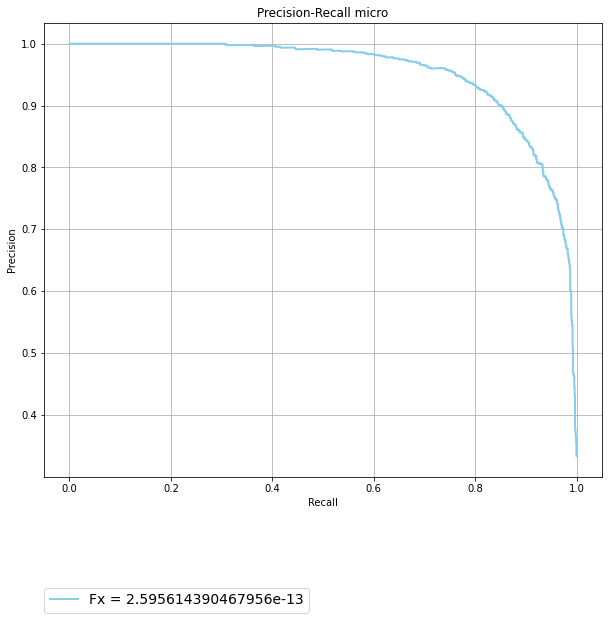

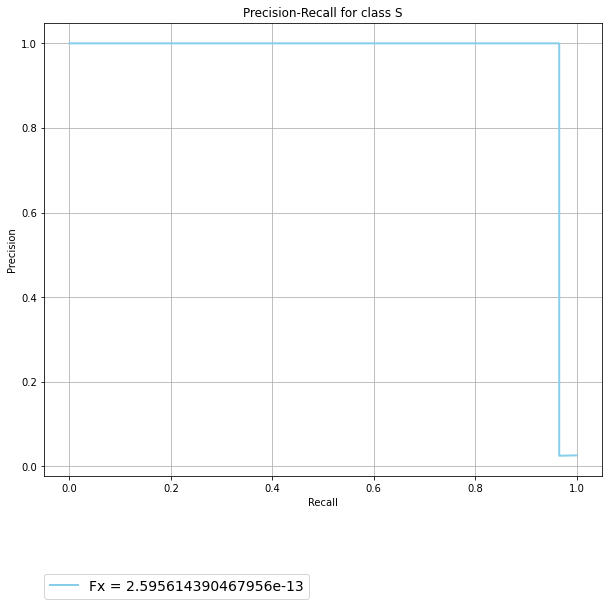

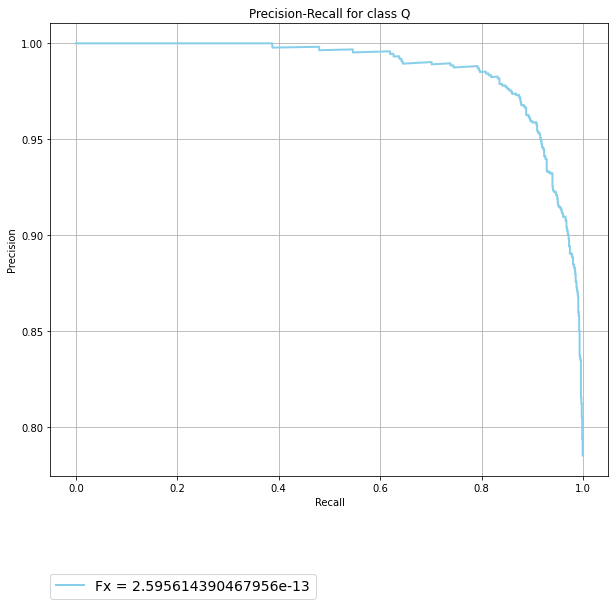

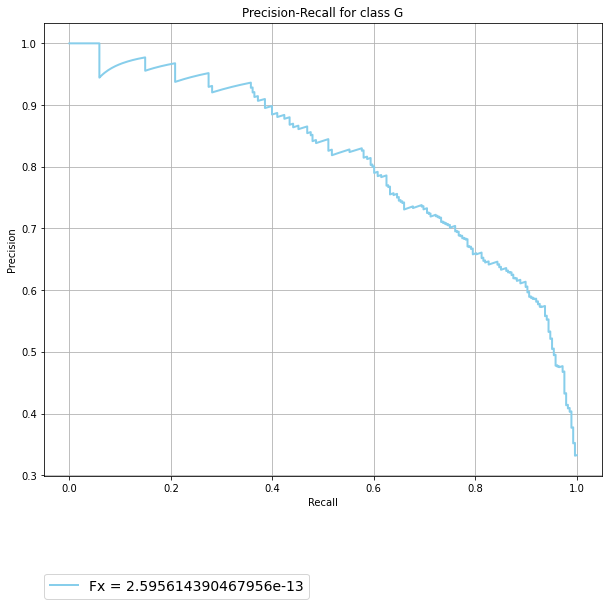

Classification Report: 
               precision    recall  f1-score   support

           1       0.44      0.97      0.61        29
           2       0.96      0.89      0.93      1159
           3       0.67      0.80      0.73       288

    accuracy                           0.87      1476
   macro avg       0.69      0.88      0.75      1476
weighted avg       0.90      0.87      0.88      1476

[[0.966 0.034 0.   ]
 [0.013 0.89  0.097]
 [0.069 0.132 0.799]]
saaaaaaaaaaaave


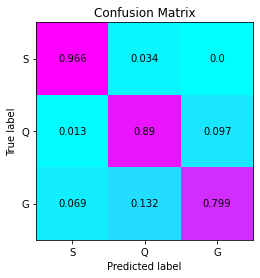

Classification Report: 
               precision    recall  f1-score   support

           1       0.44      0.97      0.61        29
           2       0.96      0.89      0.93      1159
           3       0.67      0.80      0.73       288

    accuracy                           0.87      1476
   macro avg       0.69      0.88      0.75      1476
weighted avg       0.90      0.87      0.88      1476

[[  28    1    0]
 [  15 1032  112]
 [  20   38  230]]
saaaaaaaaaaaave


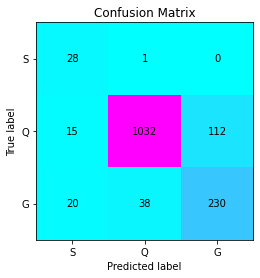

In [152]:
#accuracy = dict()
#brightness = dict()

overview = "sdssdr16+psdr2+all_decals8tr"
column = 'Fx'
#vol = 3e-15
model = 'tn_big_big'
folder = f'{model}_on_target_Fx{vol}'#folder = f'{model}_on_target_Fx{vol1}<{vol2}'#
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
#df1 = df[[column]+f[overview]+[class_row]].dropna()
#df1 = df1[df1[column] >= vol]
import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1
path = path + f'/{model}'

gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')#были обучены на маленьком датасете 
robust = joblib.load(f'{model_path}/{overview}_robust_for_gb.pkl') if model[:2] == 'gb' else None

path_for_all_model[model] = path


  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big2_on_target_Fx3e-15 уже существует


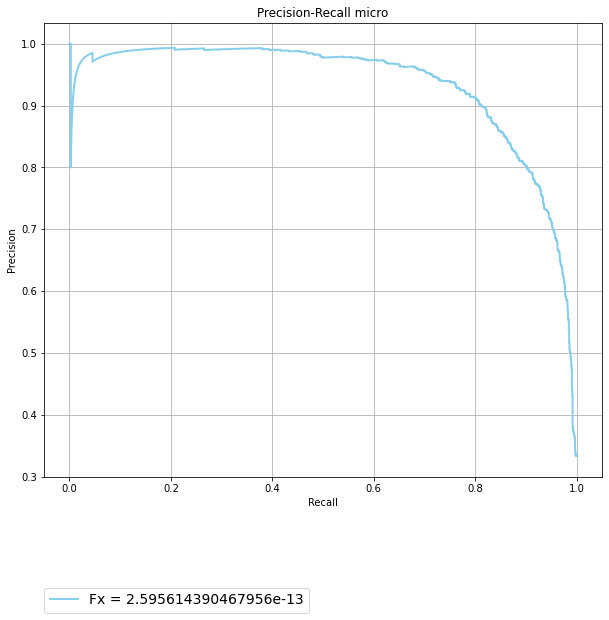

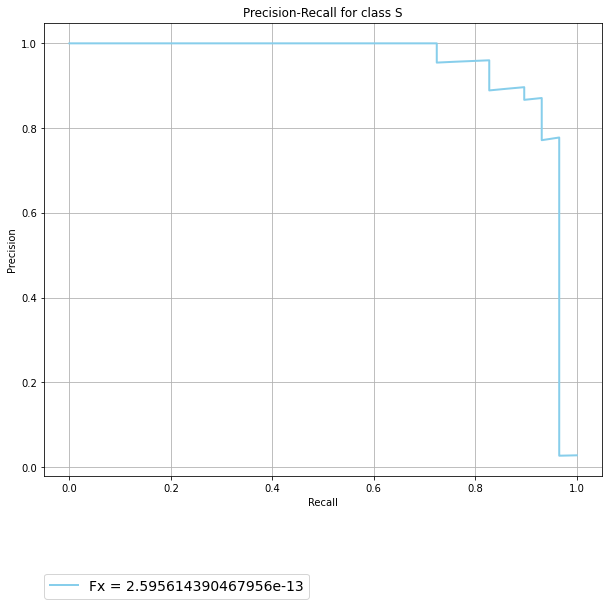

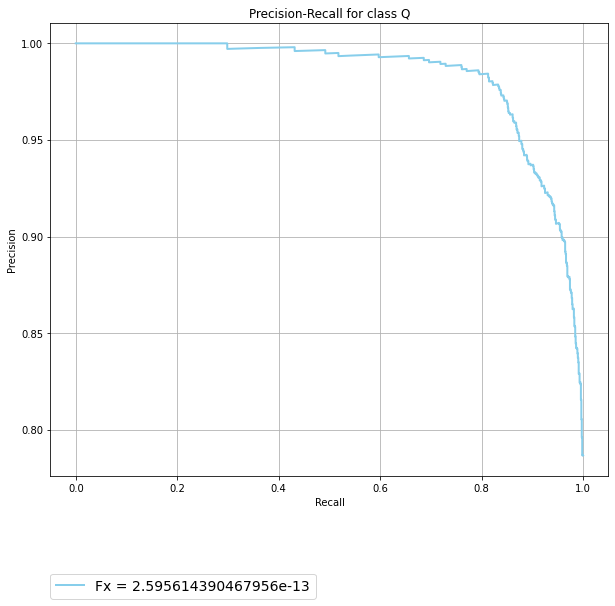

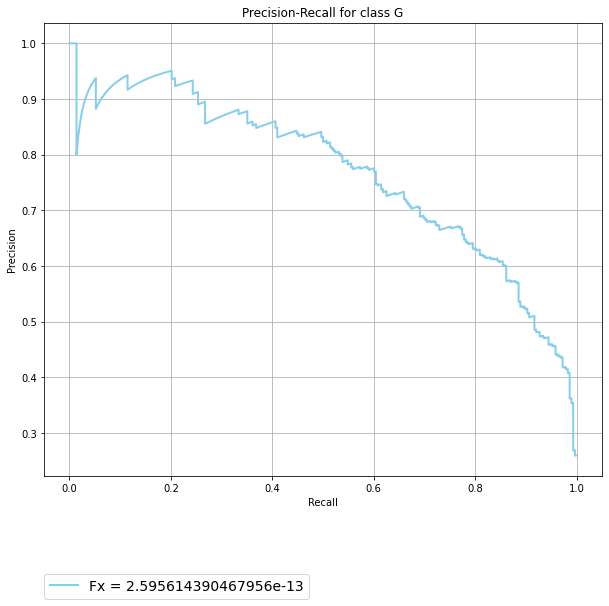

Classification Report: 
               precision    recall  f1-score   support

           1       0.34      0.97      0.50        29
           2       0.95      0.88      0.91      1159
           3       0.67      0.75      0.71       288

    accuracy                           0.85      1476
   macro avg       0.65      0.86      0.71      1476
weighted avg       0.88      0.85      0.86      1476

[[0.966 0.034 0.   ]
 [0.03  0.876 0.094]
 [0.069 0.177 0.753]]
saaaaaaaaaaaave


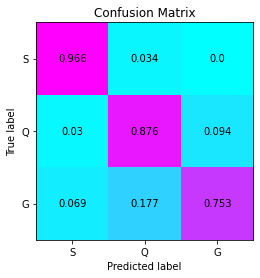

Classification Report: 
               precision    recall  f1-score   support

           1       0.34      0.97      0.50        29
           2       0.95      0.88      0.91      1159
           3       0.67      0.75      0.71       288

    accuracy                           0.85      1476
   macro avg       0.65      0.86      0.71      1476
weighted avg       0.88      0.85      0.86      1476

[[  28    1    0]
 [  35 1015  109]
 [  20   51  217]]
saaaaaaaaaaaave


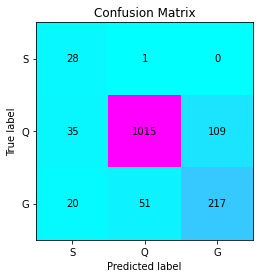

In [153]:
#accuracy = dict()
#brightness = dict()

overview = "sdssdr16+psdr2+all_decals8tr"
column = 'Fx'
#vol = 3e-15
model = 'tn_big_big2'
folder = f'{model}_on_target_Fx{vol}'#folder = f'{model}_on_target_Fx{vol1}<{vol2}'#
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
#df1 = df[[column]+f[overview]+[class_row]].dropna()
#df1 = df1[df1[column] >= vol]
import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1
path = path + f'/{model}'

gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')#были обучены на маленьком датасете 
robust = joblib.load(f'{model_path}/{overview}_robust_for_gb.pkl') if model[:2] == 'gb' else None

path_for_all_model[model] = path


  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_and_little_on_target_Fx3e-15 уже существует


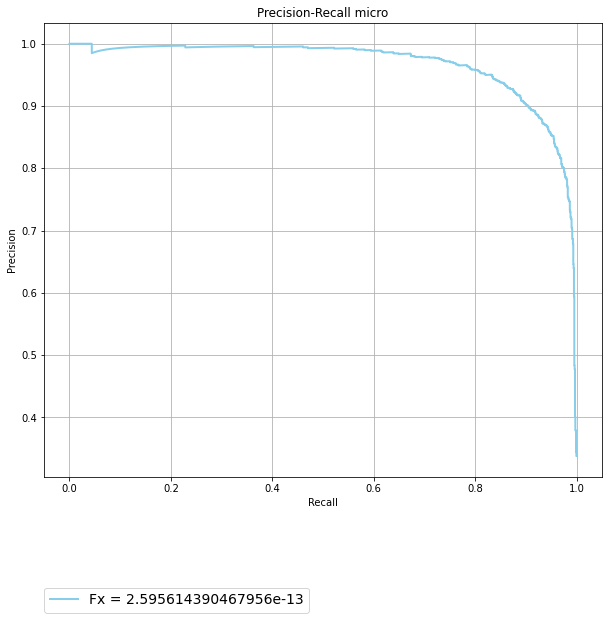

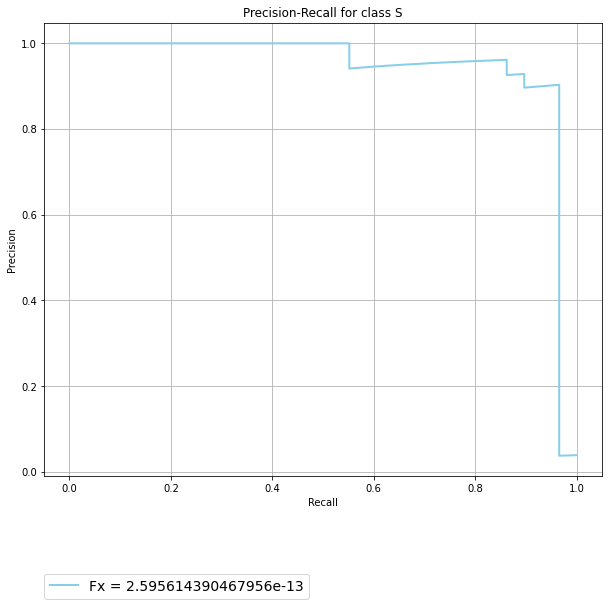

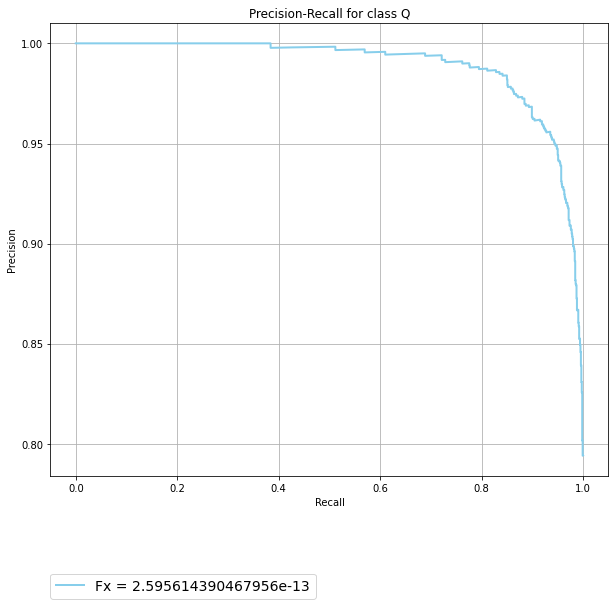

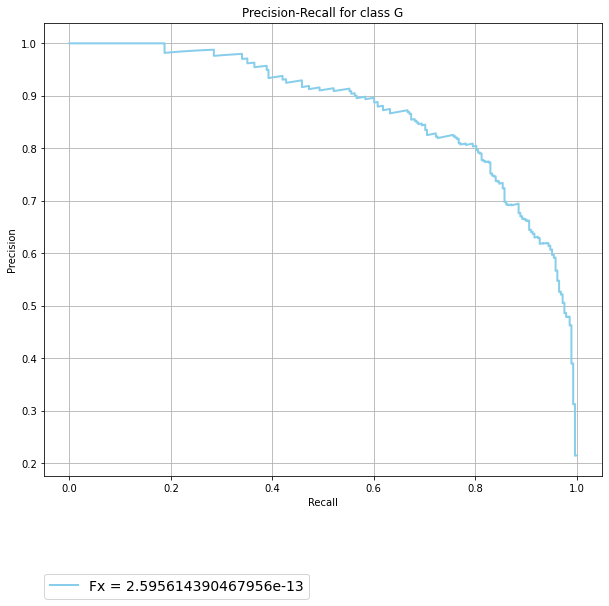

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.97      0.92        29
           2       0.96      0.91      0.94      1159
           3       0.71      0.86      0.78       288

    accuracy                           0.90      1476
   macro avg       0.85      0.91      0.88      1476
weighted avg       0.91      0.90      0.90      1476

[[0.966 0.034 0.   ]
 [0.003 0.91  0.086]
 [0.    0.142 0.858]]
saaaaaaaaaaaave


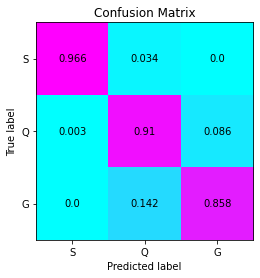

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.97      0.92        29
           2       0.96      0.91      0.94      1159
           3       0.71      0.86      0.78       288

    accuracy                           0.90      1476
   macro avg       0.85      0.91      0.88      1476
weighted avg       0.91      0.90      0.90      1476

[[  28    1    0]
 [   4 1055  100]
 [   0   41  247]]
saaaaaaaaaaaave


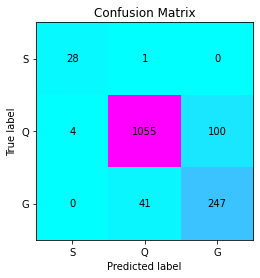

In [154]:
#accuracy = dict()
#brightness = dict()

overview = "sdssdr16+psdr2+all_decals8tr"
column = 'Fx'
#vol = 3e-15
model = 'tn_big_and_little'
folder = f'{model}_on_target_Fx{vol}'#folder = f'{model}_on_target_Fx{vol1}<{vol2}'#
model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
class_row = 'Label'
#df1 = df[[column]+f[overview]+[class_row]].dropna()
#df1 = df1[df1[column] >= vol]
import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

X1, y1 = df1[[column]+f[overview]].values, df1[class_row].values + 1
X2, y2 = X1, y1
path = path + f'/{model}'

gb = joblib.load(f'{model_path}/model_'+overview+'.pkl')#были обучены на маленьком датасете 
robust = joblib.load(f'{model_path}/{overview}_robust_for_gb.pkl') if model[:2] == 'gb' else None

path_for_all_model[model] = path


  #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Prediction_Recall_plot(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=True)
Confusion_Matrix(X1, y1, X2, y2, gb, gb, robust, robust, file_name=path, one=True, norm=False)

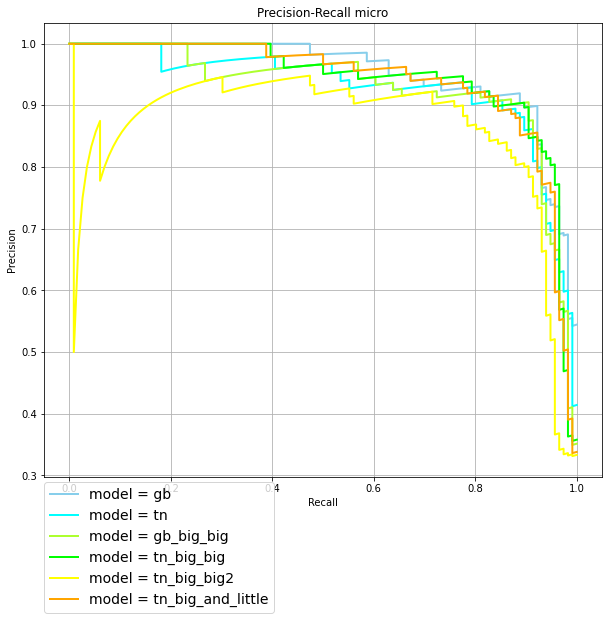

In [142]:
plt.figure(figsize=(10, 10))
lab = path_for_all_model.keys()
lines = []
labels = []
clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']
j=0
for key in lab:
  file_name = path_for_all_model[key]
  acc = np.loadtxt(file_name+'Precision_Recall_micro.txt')
  l, = plt.plot(acc[1], acc[0], color=clr[j], lw=2)
  lines.append(l)
  labels.append(f"model = {key}")
  j+=1



fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall micro')
plt.grid(True)
#plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
plt.savefig("/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_target/"+f'{vol1}<{vol2}_Precision_Recall_micro.png')
plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
plt.savefig("/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_target/"+f'{vol1}<{vol2}_Precision_Recall_micro_legend.png')

plt.show()

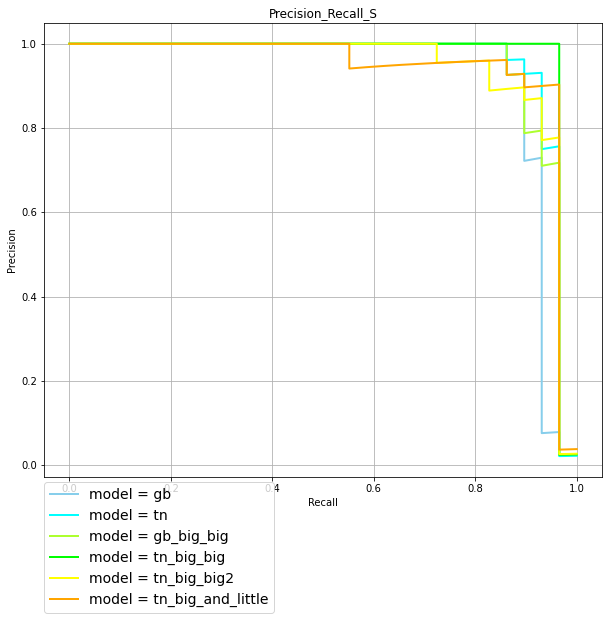

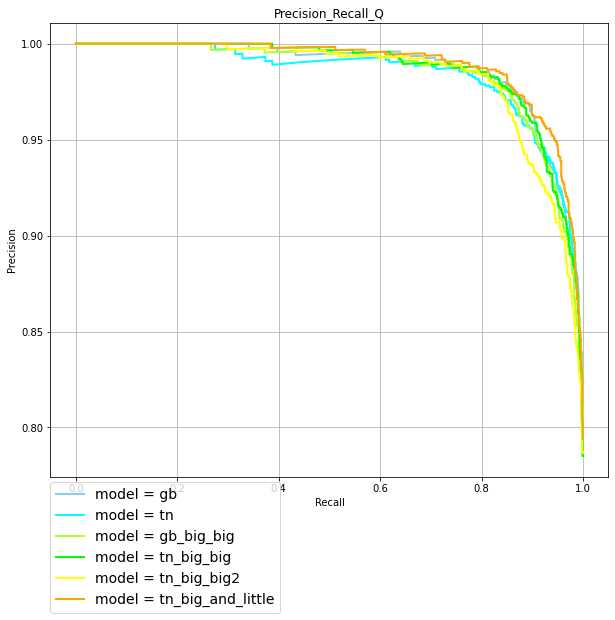

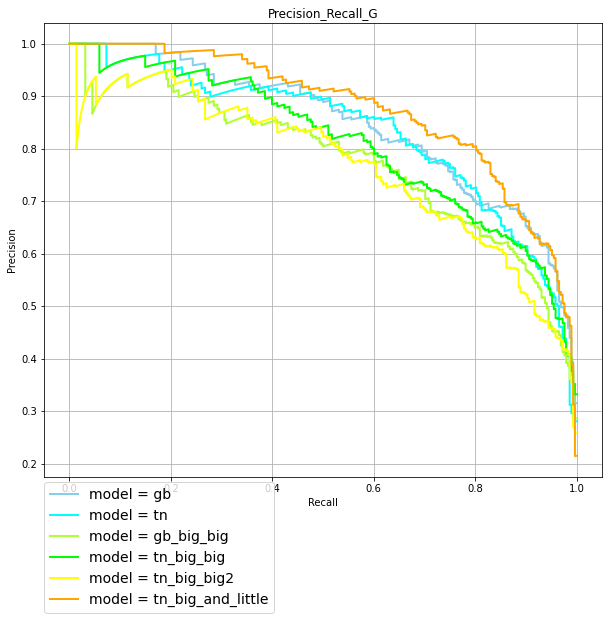

In [126]:
classes = {1: 'S', 2: 'Q', 3: 'G'}

for i in range(1, 4):
  plt.figure(figsize=(10, 10))
  lines = []
  labels = []
  j=0
  for key in lab:
    file_name = path_for_all_model[key]
    acc = np.loadtxt(file_name+f'Precision_Recall_{classes[i]}.txt')
    #print(acc.shape)
    l, = plt.plot(acc[:, 1], acc[:, 0], color=clr[j], lw=2)
    lines.append(l)
    labels.append(f"model = {key}")
    j+=1
    
  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(f'Precision_Recall_{classes[i]}')
  plt.grid(True)
  #plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
  plt.savefig("/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_target/"+f'{vol1}<{vol2}_Precision_Recall_{classes[i]}.png')
  plt.legend(lines, labels, loc=(0, -0.3), prop=dict(size=14))
  plt.savefig("/content/drive/MyDrive/Научная работа/Data/X-ray/plots/on_target/"+f'{vol1}<{vol2}_Precision_Recall_{classes[i]}_legend.png')

  plt.show()

# Влияние поглощения

Будем проверять влияние поглощения на выборке APOGEE_DR16_StarHorse

In [29]:
import gzip
import pickle
from glob import glob
from os.path import join
dataset = glob('/content/drive/MyDrive/Научная работа/Data/Main/data/STAR/*_StarHorse')

In [30]:
dataset

['/content/drive/MyDrive/Научная работа/Data/Main/data/STAR/33_LAMOST_DR5_StarHorse',
 '/content/drive/MyDrive/Научная работа/Data/Main/data/STAR/32_GES_DR3_StarHorse',
 '/content/drive/MyDrive/Научная работа/Data/Main/data/STAR/34_RAVE_DR6_StarHorse',
 '/content/drive/MyDrive/Научная работа/Data/Main/data/STAR/30_APOGEE_DR16_StarHorse',
 '/content/drive/MyDrive/Научная работа/Data/Main/data/STAR/31_GALAH_DR2_StarHorse']

In [31]:
eAPOGEE_DR16_StarHorse = glob(join(dataset[3], 'part-*.features.gz_pkl'))
print(len(eAPOGEE_DR16_StarHorse))
APOGEE_DR16_StarHorse = pd.DataFrame()
for i in eAPOGEE_DR16_StarHorse:
  with gzip.open(i, 'rb') as file:
    frame = pickle.load(file)
    APOGEE_DR16_StarHorse = pd.concat([APOGEE_DR16_StarHorse, frame])

print(APOGEE_DR16_StarHorse.shape)
APOGEE_DR16_StarHorse

16
(404481, 415)


APOGEE_ID    GaiaDR2_source_id  ...  phot_test_field  __nrow__
0      b'2M02503969+6031010'   464857130930206208  ...                -         1
1      b'2M02503973+6015225'   464570983032257920  ...                -         2
2      b'2M02504050+5950163'   464544113717093248  ...                -         3
3      b'2M02504052+5419149'   453500069168308480  ...                -         4
4      b'2M02504065+3624368'   141349473952479744  ...                -         5
...                      ...                  ...  ...              ...       ...
14245  b'2M02503756-0107303'  2497473901521542016  ...             S82X    404477
14246  b'2M02503771+5610534'   460515056432357632  ...                -    404478
14247  b'2M02503853-0120245'  2497460157626547200  ...             S82X    404479
14248  b'2M02503892-1706393'  5153598779651854976  ...                -    404480
14249  b'2M02503954+0009117'  2498190237642658432  ...             S82X    404481

[404481 rows x 415 columns]

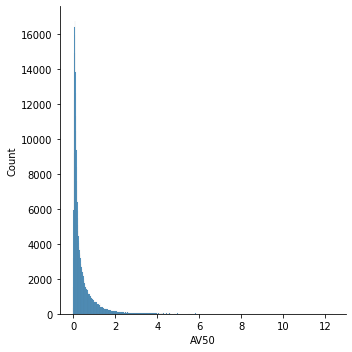

In [62]:
sns.displot(APOGEE_DR16_StarHorse.AV50 / 3.1)

In [63]:
column

'sdssdr16_r_cmodel'

In [64]:
for i in APOGEE_DR16_StarHorse.columns:
  print(i)

APOGEE_ID
GaiaDR2_source_id
GLON
GLAT
mass16
mass50
mass84
teff16
teff50
teff84
logg16
logg50
logg84
met16
met50
met84
dist16
dist50
dist84
AV16
AV50
AV84
StarHorse_INPUTFLAGS
StarHorse_OUTPUTFLAGS
RA
DEC
__workxid__
ps_sep_input
ps_objID
ps_raBest
ps_decBest
ps_raStack
ps_decStack
ps_raStackErr
ps_decStackErr
ps_raMean
ps_decMean
ps_raMeanErr
ps_decMeanErr
ps_objInfoFlag
ps_qualityFlag
ps_primaryDetection
ps_bestDetection
ps_duplicat
ps_d_to
ps_fitext
ps_devaucou
ps_star
ps_w1fit
ps_w1bad
ps_w1mag
ps_dw1mag
ps_w2fit
ps_w2bad
ps_w2mag
ps_dw2mag
ps___workcid__
ps_healpix_id_log2nside17
ps_gKronFlux
ps_gKronFluxErr
ps_rKronFlux
ps_rKronFluxErr
ps_iKronFlux
ps_iKronFluxErr
ps_zKronFlux
ps_zKronFluxErr
ps_yKronFlux
ps_yKronFluxErr
ps_gPSFFlux
ps_gPSFFluxErr
ps_rPSFFlux
ps_rPSFFluxErr
ps_iPSFFlux
ps_iPSFFluxErr
ps_zPSFFlux
ps_zPSFFluxErr
ps_yPSFFlux
ps_yPSFFluxErr
ps_w1flux
ps_dw1flux
ps_w2flux
ps_dw2flux
ps_counterparts_number
ps_single_counterpart
ps_counterparts_type
sdss_sep_input
sdss_

In [65]:
f

{'decals8tr': ['decals8tr_Lw1-Lw2',
  'decals8tr_Lw1',
  'decals8tr_Lw2',
  'decals8tr_g',
  'decals8tr_r',
  'decals8tr_z',
  'decals8tr_g-r',
  'decals8tr_g-z',
  'decals8tr_r-z'],
 'psdr2+all_decals8tr': ['psdr2_i_kron',
  'psdr2_y_kron',
  'psdr2_g_psf',
  'psdr2_r_psf',
  'psdr2_i_psf',
  'psdr2_z_psf',
  'psdr2_y_psf',
  'psdr2_g-i_psf',
  'psdr2_g-y_psf',
  'psdr2_r-i_psf',
  'psdr2_r-y_psf',
  'psdr2_i-z_psf',
  'psdr2_i-y_psf',
  'psdr2_i_psf-kron',
  'psdr2_z-y_psf',
  'psdr2_y_psf-kron',
  'decals8tr_Lw1-Lw2',
  'decals8tr_Lw1',
  'decals8tr_Lw2',
  'decals8tr_g',
  'decals8tr_r',
  'decals8tr_z',
  'decals8tr_g-r',
  'decals8tr_g-z',
  'decals8tr_r-z'],
 'psdr2+wise_decals8tr': ['psdr2_i_kron',
  'psdr2_y_kron',
  'psdr2_g_psf',
  'psdr2_r_psf',
  'psdr2_i_psf',
  'psdr2_z_psf',
  'psdr2_y_psf',
  'psdr2_g-i_psf',
  'psdr2_g-y_psf',
  'psdr2_r-i_psf',
  'psdr2_r-y_psf',
  'psdr2_i-z_psf',
  'psdr2_i-y_psf',
  'psdr2_i_psf-kron',
  'psdr2_z-y_psf',
  'psdr2_y_psf-kron',
  'd

(404481, 419)
sdssdr16+wise_decals8tr


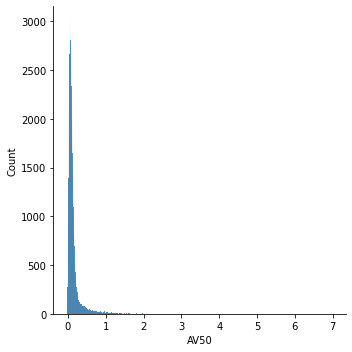

psdr2+wise_decals8tr


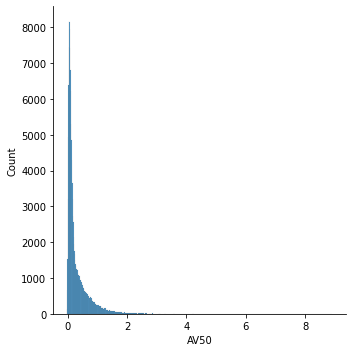

sdssdr16+all_decals8tr


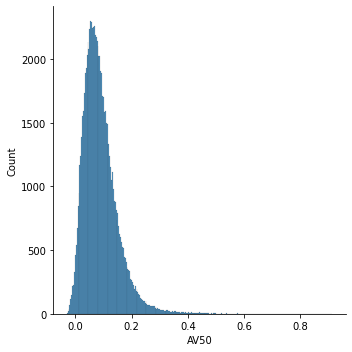

psdr2+all_decals8tr


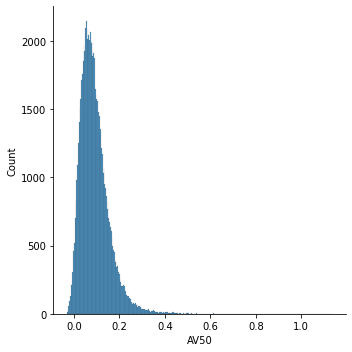

decals8tr


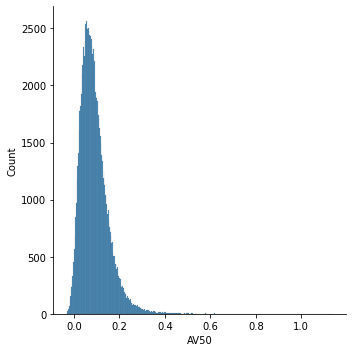

sdssdr16+psdr2+wise_decals8tr


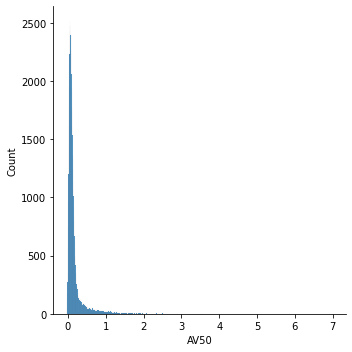

sdssdr16+psdr2+all_decals8tr


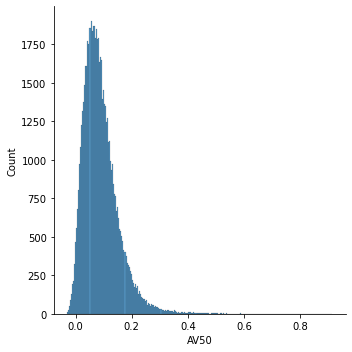

In [71]:
  '''
  for i in range(1, len(dataset)):
  print(dataset[i])
  eAPOGEE_DR16_StarHorse = glob(join(dataset[i], 'part-*.features.gz_pkl'))
  print(len(eAPOGEE_DR16_StarHorse))
  APOGEE_DR16_StarHorse = pd.DataFrame()
  for i in eAPOGEE_DR16_StarHorse:
    with gzip.open(i, 'rb') as file:
      frame = pickle.load(file)
      APOGEE_DR16_StarHorse = pd.concat([APOGEE_DR16_StarHorse, frame])
  sns.displot(APOGEE_DR16_StarHorse.AV50 / 3.1)
  plt.show()
  '''

  print(APOGEE_DR16_StarHorse.shape)
  for overview in f.keys():
    print(overview)
    df_ap = APOGEE_DR16_StarHorse[f[overview]+['AV50']].dropna()
    sns.displot(df_ap.AV50 / 3.1)
    plt.show()


In [67]:
APOGEE_DR16_StarHorse['decals8tr_Lw1'], APOGEE_DR16_StarHorse['decals8tr_Lw2'], APOGEE_DR16_StarHorse.shape, APOGEE_DR16_StarHorse[['decals8tr_Lw1']].dropna().shape

(0              NaN
 1              NaN
 2              NaN
 3              NaN
 4              NaN
            ...    
 14245    13.489233
 14246          NaN
 14247    13.662578
 14248    14.557765
 14249    14.029939
 Name: decals8tr_Lw1, Length: 404481, dtype: float64, 0              NaN
 1              NaN
 2              NaN
 3              NaN
 4              NaN
            ...    
 14245    14.154316
 14246          NaN
 14247    14.338025
 14248    15.247398
 14249    14.725367
 Name: decals8tr_Lw2, Length: 404481, dtype: float64, (404481, 415), (105721,
  1))

In [32]:
import re
def asinhmag_dm(flux, flux_err=None, flux_ivar=None, dm=0):
    """
    Calculate asinh mognitude with dm shift.
    ::flux      - flux in [nanomaggies]
    ::flux_ivar - inverse variance of flux in [1/nanomaggies**2]
    ::flux_err  - flux error in [nanomaggies]
    ::dm        - magnitude shift
    """
    assert (flux_err is not None) ^ (
                flux_ivar is not None), 'specify only flux_err or flux_ivar'
    f = flux / 1e9 * np.power(10, 0.4 * dm)
    if flux_ivar is not None:
        b = np.power(flux_ivar, -0.5) / 1e9 * np.power(10, 0.4 * dm)
    else:
        b = flux_err / 1e9 * np.power(10, 0.4 * dm)

    f, b = f.astype(np.float64), b.astype(
        np.float64)  # otherwise type error like
    # TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable arcsinh method

    return (np.arcsinh(f / (2 * b)) + np.log(b)) * (-2.5 / np.log(10))


def flux2mag(flux, err, columns, dms=None):
    """
    ::flux - pandas.DataFrame with fluxes
    ::err - pandas.DataFrame with corresponding errors. Columns must be in the same order
        (e.g. flux_r, flux_u, flux_w2 => err_r, err_u, ivar_w2)
        if "ivar" or "Ivar" is substring of error column name, then numbers in this columns are interperted
        as inverse variance of flux in [1/nanomaggies**2], else as flux error in [nanomaggies]
    ::columns - dict where keys are columns names from flux param and values are result columns names
        (e.g. {"flux_z":"mag_z"})
    """
    result = pd.DataFrame()
    if dms is None:
        dms = np.zeros(len(columns))

    for f, i, dm in zip(flux.columns, err.columns, dms):
        if dm is None:
            dm = 0

        if 'ivar' in i or 'Ivar' in i:
            print(i, 'ivar')
            result[columns[f]] = asinhmag_dm(flux[f], flux_ivar=err[i], dm=dm)
        elif re.findall('^ps_dw\dflux_ab$', i):
            print(i, 'err')
            result[columns[f]] = asinhmag_dm(
                flux[f].replace(-999, np.NaN),
                flux_err=err[i].replace(-999, np.NaN),
                dm=dm
            )
        else:
            print(i, 'err')
            result[columns[f]] = asinhmag_dm(
                flux[f].replace(-999, np.NaN) / 3621e-9,
                flux_err=err[i].replace(-999, np.NaN) / 3621e-9,
                dm=dm
            )

    result.index = flux.index
    return result


def calculate_panstarrs_wise_features(catalog: pd.DataFrame) -> pd.DataFrame:
    assert 'ps_w1flux' in catalog.columns
    assert 'ps_dw1flux' in catalog.columns
    assert 'ps_w2flux' in catalog.columns
    assert 'ps_dw2flux' in catalog.columns

    catalog[['ps_w1flux_ab', 'ps_dw1flux_ab']] = catalog[['ps_w1flux', 'ps_dw1flux']] * 10 ** (-2.699 / 2.5)
    catalog[['ps_w2flux_ab', 'ps_dw2flux_ab']] = catalog[['ps_w2flux', 'ps_dw2flux']] * 10 ** (-3.339 / 2.5)

    flux_cols = ['ps_w1flux_ab', 'ps_w2flux_ab']
    err_cols = ['ps_dw1flux_ab', 'ps_dw2flux_ab']
    mag_columns = {'ps_w1flux_ab': 'decals8tr_Lw1',
                   'ps_w2flux_ab': 'decals8tr_Lw2'}

    fluxes, errors = catalog[flux_cols].astype(np.float), catalog[err_cols].astype(np.float)

    errors[errors <= 0] = np.nan
    mags = flux2mag(fluxes, errors, mag_columns)
    catalog[mags.columns] = mags
    catalog['decals8tr_Lw1-Lw2'] = catalog['decals8tr_Lw1'] - catalog['decals8tr_Lw2']
    return catalog

In [33]:
AP_Lw = calculate_panstarrs_wise_features(APOGEE_DR16_StarHorse)

ps_dw1flux_ab err
ps_dw2flux_ab err


In [70]:
AP_Lw['decals8tr_Lw1'], AP_Lw['decals8tr_Lw2'], AP_Lw.shape, AP_Lw[['decals8tr_Lw1']].dropna().shape

(0        24.385158
 1        24.385158
 2              NaN
 3        24.560062
 4        13.962211
            ...    
 14245    13.622539
 14246          NaN
 14247    13.745600
 14248    14.571640
 14249    14.014831
 Name: decals8tr_Lw1, Length: 404481, dtype: float64, 0        23.903586
 1        23.903586
 2              NaN
 3        23.946609
 4        14.683282
            ...    
 14245    14.185398
 14246    15.012085
 14247    14.371601
 14248    15.252729
 14249    14.723308
 Name: decals8tr_Lw2, Length: 404481, dtype: float64, (404481, 419), (202730,
  1))

In [34]:
overview = 'psdr2+wise_decals8tr'
df_ap =APOGEE_DR16_StarHorse[f[overview]+['AV50']].dropna()
ebv = df_ap['AV50'].values / 3.1
df_ap['ebv'] = ebv

In [135]:
df_ap[(df_ap.ebv >= 4.0) & (df_ap.ebv <= 4.0115)]

psdr2_i_kron  psdr2_y_kron  ...       AV50       ebv
11148     18.474084     14.146879  ...  12.434311  4.011068

[1 rows x 21 columns]

In [124]:
def rec(y_true, y_pred):
    from sklearn.metrics import recall_score

    y_pred = (y_pred != 1)*1 + 1
    return recall_score(y_true, y_pred)

In [144]:
overview = 'sdssdr16_r_cmodel'

In [147]:
model_mat = ['tn','tn_big_big', 'tn_big_big2', 'tn_big_and_little']

for model in model_mat:
    
    model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'

    model1 = joblib.load(f'{model_path}/model_'+overview+'.pkl')
    print(model, model1.get_params(), sum([param.nelement() for param in model1.network.parameters()]))

tn {'cat_dims': [], 'cat_emb_dim': 1, 'cat_idxs': [], 'clip_value': 1, 'device_name': 'auto', 'epsilon': 1e-15, 'gamma': 1.579251159204144, 'input_dim': 42, 'lambda_sparse': 0.0033725020591721076, 'mask_type': 'entmax', 'momentum': 0.02, 'n_a': 8, 'n_d': 8, 'n_independent': 2, 'n_shared': 1, 'n_steps': 4, 'optimizer_fn': <class 'torch.optim.adam.Adam'>, 'optimizer_params': {'lr': 0.02}, 'output_dim': 3, 'scheduler_fn': <class 'torch.optim.lr_scheduler.StepLR'>, 'scheduler_params': {'step_size': 200, 'gamma': 0.95}, 'seed': 0, 'verbose': 1} 9296
tn_big_big {'cat_dims': [], 'cat_emb_dim': 1, 'cat_idxs': [], 'clip_value': 1, 'device_name': 'auto', 'epsilon': 1e-15, 'gamma': 2.3696685979745844, 'input_dim': 42, 'lambda_sparse': 0.00837486406175253, 'mask_type': 'entmax', 'momentum': 0.02, 'n_a': 8, 'n_d': 8, 'n_independent': 2, 'n_shared': 2, 'n_steps': 4, 'optimizer_fn': <class 'torch.optim.adam.Adam'>, 'optimizer_params': {'lr': 0.02}, 'output_dim': 3, 'scheduler_fn': <class 'torch.optim

In [123]:
model_mat = ['tn','tn_big_big', 'tn_big_big2', 'tn_big_and_little']

for model in model_mat:
    
    model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'

    model1 = joblib.load(f'{model_path}/model_'+overview+'.pkl')
    print(model, model1.get_params(), sum([param.nelement() for param in model1.network.parameters()]))

gb {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7287958151148961, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 49, 'min_child_weight': 0.471460620399453, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 93, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
tn {'cat_dims': [], 'cat_emb_dim': 1, 'cat_idxs': [], 'clip_value': 1, 'device_name': 'auto', 'epsilon': 1e-15, 'gamma': 1.579251159204144, 'input_dim': 42, 'lambda_sparse': 0.0033725020591721076, 'mask_type': 'entmax', 'momentum': 0.02, 'n_a': 8, 'n_d': 8, 'n_independent': 2, 'n_shared': 1, 'n_steps': 4, 'optimizer_fn': <class 'torch.optim.adam.Adam'>, 'optimizer_params': {'lr': 0.02}, 'output_dim': 3, 'scheduler_fn': <class 'torch.optim.lr_scheduler.StepLR'>, 'scheduler_params': {'step_size': 200, 'gamma': 0.95}, 'seed': 0, 'verbos

gb
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_on_StarHorse уже существует
(155714, 20) 155714 [1. 1. 1. ... 1. 1. 1.]
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.40679304923323745, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 13, 'min_child_weight': 0.08230398930467149, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 23, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
QQQQ [7.04503691e-07 7.39859715e-02 1.44843780e-01 3.92207414e-01
 8.90917873e+00]
7.045036909403279e-07 0.07398597151041031
1.0
(250, 19)
(250, 19)
250 250
0.07398597151041031 0.14484377950429916
1.0
(250, 19)
(250, 19)
250 250
0.14484377950429916 0.39220741391181946
1.0
(250, 19)
(250, 19)
250 250
0.39220741391181946 8.909178733825684
1.0
(250, 19)
(250, 19)
250 250


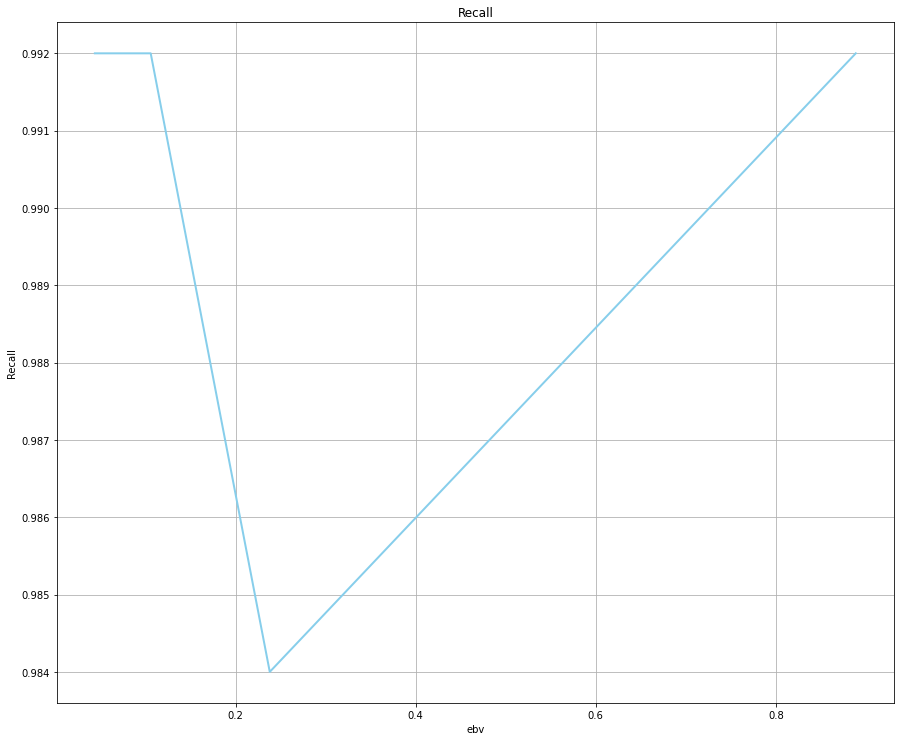

tn
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_on_StarHorse уже существует
(155714, 20) 155714 [1. 1. 1. ... 1. 1. 1.]
{'cat_dims': [], 'cat_emb_dim': 1, 'cat_idxs': [], 'clip_value': 1, 'device_name': 'auto', 'epsilon': 1e-15, 'gamma': 2.0529642554071534, 'input_dim': 19, 'lambda_sparse': 0.006352953901985262, 'mask_type': 'entmax', 'momentum': 0.02, 'n_a': 8, 'n_d': 8, 'n_independent': 3, 'n_shared': 2, 'n_steps': 3, 'optimizer_fn': <class 'torch.optim.adam.Adam'>, 'optimizer_params': {'lr': 0.02}, 'output_dim': 3, 'scheduler_fn': <class 'torch.optim.lr_scheduler.StepLR'>, 'scheduler_params': {'step_size': 200, 'gamma': 0.95}, 'seed': 0, 'verbose': 1}
QQQQ [7.04503691e-07 7.39859715e-02 1.44843780e-01 3.92207414e-01
 8.90917873e+00]
7.045036909403279e-07 0.07398597151041031
1.0
(250, 19)
(250, 19)
250 250
0.07398597151041031 0.14484377950429916
1.0
(250, 19)
(250, 19)
250 250
0.14484377950429916 0.39220741391181946
1.0
(250, 19)
(250, 19)
250 250
0.3922074139

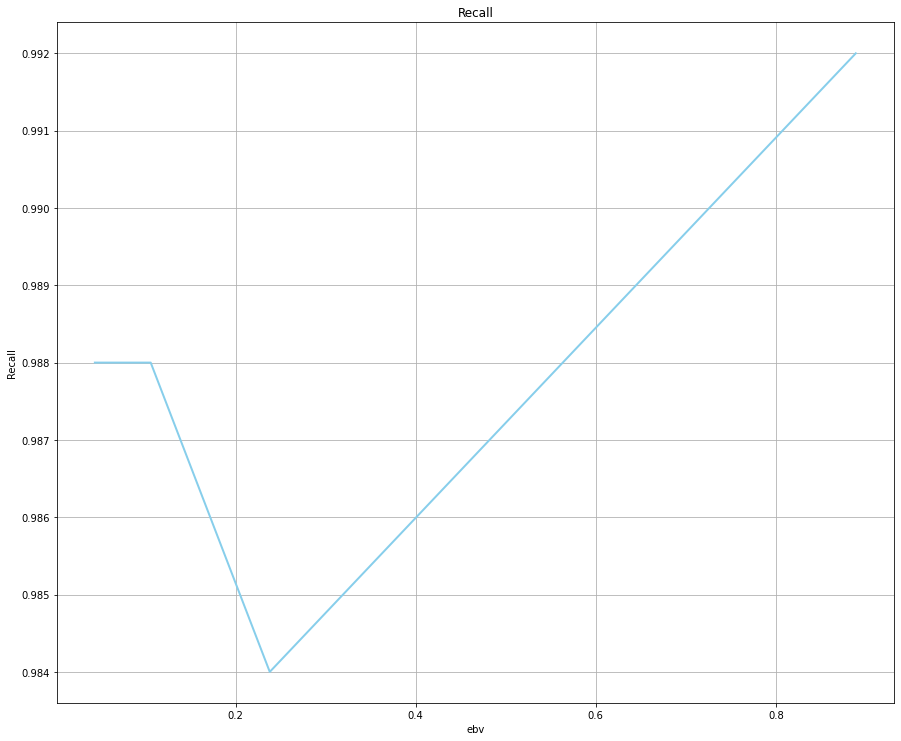

gb_big_big
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/gb_big_big_on_StarHorse уже существует
(155714, 20) 155714 [1. 1. 1. ... 1. 1. 1.]
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.6361751860249435, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 28, 'min_child_weight': 0.4214330886991654, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 41, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
QQQQ [7.04503691e-07 7.39859715e-02 1.44843780e-01 3.92207414e-01
 8.90917873e+00]
7.045036909403279e-07 0.07398597151041031
1.0
(250, 19)
(250, 19)
250 250
0.07398597151041031 0.14484377950429916
1.0
(250, 19)
(250, 19)
250 250
0.14484377950429916 0.39220741391181946
1.0
(250, 19)
(250, 19)
250 250
0.39220741391181946 8.909178733825684
1.0
(250, 19)
(250, 19)
250 250


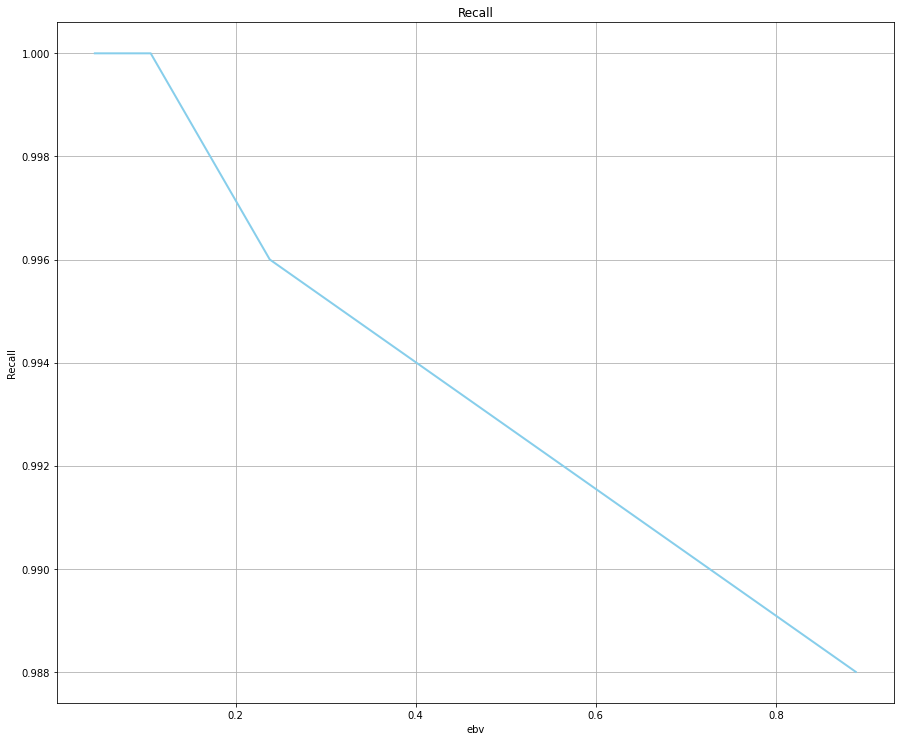

tn_big_big
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_big_on_StarHorse уже существует
(155714, 20) 155714 [1. 1. 1. ... 1. 1. 1.]
{'cat_dims': [], 'cat_emb_dim': 1, 'cat_idxs': [], 'clip_value': 1, 'device_name': 'auto', 'epsilon': 1e-15, 'gamma': 1.983170970162808, 'input_dim': 19, 'lambda_sparse': 0.0023508823871117492, 'mask_type': 'entmax', 'momentum': 0.02, 'n_a': 8, 'n_d': 8, 'n_independent': 3, 'n_shared': 1, 'n_steps': 5, 'optimizer_fn': <class 'torch.optim.adam.Adam'>, 'optimizer_params': {'lr': 0.02}, 'output_dim': 3, 'scheduler_fn': <class 'torch.optim.lr_scheduler.StepLR'>, 'scheduler_params': {'step_size': 200, 'gamma': 0.95}, 'seed': 0, 'verbose': 1}
QQQQ [7.04503691e-07 7.39859715e-02 1.44843780e-01 3.92207414e-01
 8.90917873e+00]
7.045036909403279e-07 0.07398597151041031
1.0
(250, 19)
(250, 19)
250 250
0.07398597151041031 0.14484377950429916
1.0
(250, 19)
(250, 19)
250 250
0.14484377950429916 0.39220741391181946
1.0
(250, 19)
(250, 19)
250 

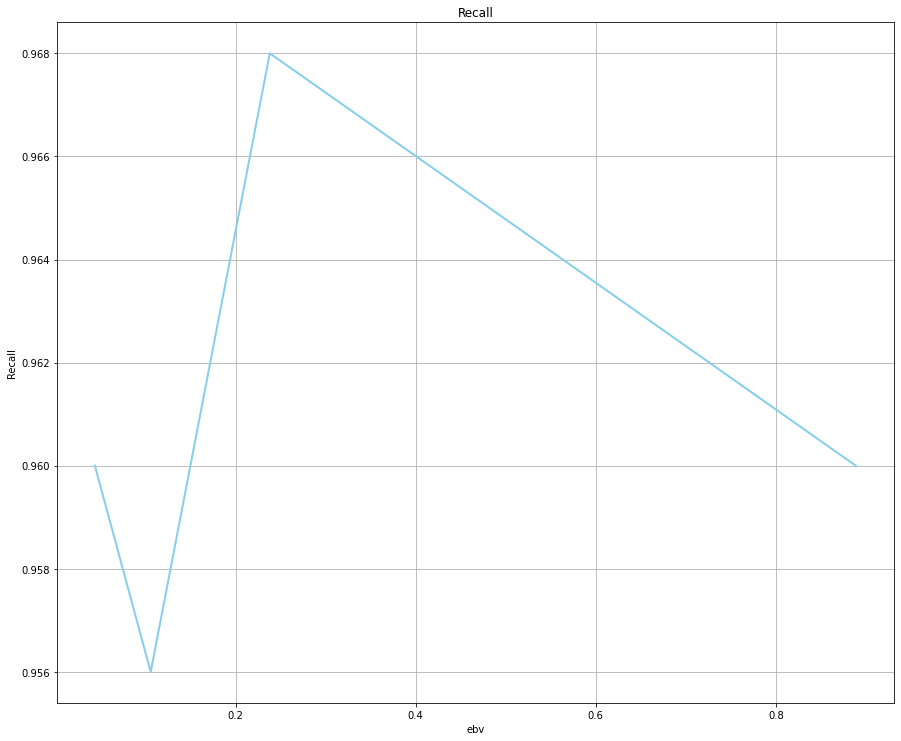

In [126]:
path_for_all_model = dict()
accuracy = dict()
brightness = dict()
overview = "psdr2+wise_decals8tr"
column = 'ebv'
data = 'ap'
model_mat = ['gb', 'tn', 'gb_big_big', 'tn_big_big']#, 'tn_big_big2', 'tn_big_and_little']
for i in range(1):

  df1 = df_ap[df_ap[column] >= 0][[column]+f[overview]].dropna()
  #df1 = df1[(df1[column] >= vol_min) & (df1[column] <= vol_max)]
  for model in model_mat:
    print('\033[1m' + model + '\033[0m')
    folder = f'{model}_on_StarHorse'#folder = f'{model}_on_target_Fx{vol1}<{vol2}'
    model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
    class_row = 'Label'
    import os
    path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{folder}"

    try:
        os.makedirs(path)
    except FileExistsError:
      print("Директория %s уже существует" % path) 
    except OSError:
        print ("Создать директорию %s не удалось" % path)
        exit()

    X1=X2 = df1.values#[[column]+f[overview]]
    y1=y2 = np.ones(X1.shape[0])
    print(X1.shape, len(y1), y1)


    model1 = model2 = joblib.load(f'{model_path}/model_'+overview+'.pkl')
    print(model1.get_params())
    rob_mod = 'gb_big' if 'big_big' in model else 'gb' 
    robust1 = robust2 = joblib.load(f'{model_path}/{overview}_robust_for_{rob_mod}.pkl') if 'gb' in model else None
    #path_for_all_model[model] = path
    #F1_plot_class(X1, y1, X2, y2, gb, gb, robust, robust, column, path, N=1)
    acc, r = choseAcc_2cv(X2, y2, X1, y1, model1, model2, 4, robust1, robust2, rec, norm=False)
    acc = np.array(acc).T
    accuracy[overview] = acc
    brightness[overview] = r

    np.savetxt(f'{path}/{overview}_{model}_on_{data}_r.txt', brightness[overview])
    np.savetxt(f'{path}/{overview}_{model}_on_{data}_accuracy.txt', accuracy[overview])
    path_for_all_model[model] = f'{path}/{overview}_{model}_on_{data}_'


    plt.figure(figsize=(15, 15))
    lines = []
    labels = []
    clr = ['skyblue', 'aqua', 'greenyellow', 'lime', 'yellow', 'orange', 'red', 'chocolate', 'darkorange', 'gold', 'springgreen', 'aquamarine',  'lightskyblue']

    j=0
    #for overview in /f.keys():
    l, = plt.plot(brightness[overview], accuracy[overview], color=clr[j], lw=2)
    lines.append(l)
    labels.append(f"Model {overview}")
    j+=1

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlabel(column)
    #plt.xlim(15.5, 23)
    #plt.ylim(0.5, 1.01)
    plt.ylabel('Recall')
    plt.title('Recall')
    plt.grid(True)
    #plt.legend(lines, labels, loc=(0, -0.32), prop=dict(size=14))
    #plt.savefig(f'/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{model}_accuracy.png')
    plt.show()


Данный эксперимент не дает однозначных выводов. Попробуем посмотреть на тест при добалении поглощения 

In [35]:
ebv_coeff = {
                'sdssdr16': 
                      {
                          'u': 4.239,
                          'g': 3.303,
                          'r': 2.285,
                          'i': 1.698,
                          'z': 1.263
                      },
                'psdr2':
                      {
                          'g': 3.172,
                          'r': 2.271, 
                          'i': 1.682,
                          'z': 1.322,
                          'y': 1.087,
                          'w': 2.341
                      },
                'decals8tr':
                      {
                          'Lw1': 0.186,
                          'Lw2': 0.123,
                          'g'  : 3.237,
                          'r'  : 2.176,
                          'z'  : 1.217
                      }
            }

In [36]:
ebv_coeff1 = {
                'sdssdr16': 
                      {
                          'u': 4.239,
                          'g': 3.303,
                          'r': 2.285,
                          'i': 1.698,
                          'z': 1.263
                      },
                'psdr2':
                      {
                          'g': 3.172,
                          'r': 2.271, 
                          'i': 1.682,
                          'z': 1.322,
                          'y': 1.087,
                          'w': 2.341
                      },
                'decals8tr':
                      {
                          'Lw1': 0.186,
                          'Lw2': 0.123,
                          'g'  : 3.237,
                          'r'  : 2.176,
                          'z'  : 1.217
                      }
            }

In [37]:
for i in ebv_coeff.keys():
  for j in ebv_coeff[i].keys():
    for j1 in ebv_coeff[i].keys():
      ebv_coeff1[i][j+'-'+j1] = ebv_coeff[i][j] - ebv_coeff[i][j1]

In [38]:
ebv_coeff1

{'decals8tr': {'Lw1': 0.186,
  'Lw1-Lw1': 0.0,
  'Lw1-Lw2': 0.063,
  'Lw1-g': -3.051,
  'Lw1-r': -1.9900000000000002,
  'Lw1-z': -1.0310000000000001,
  'Lw2': 0.123,
  'Lw2-Lw1': -0.063,
  'Lw2-Lw2': 0.0,
  'Lw2-g': -3.114,
  'Lw2-r': -2.053,
  'Lw2-z': -1.094,
  'g': 3.237,
  'g-Lw1': 3.051,
  'g-Lw2': 3.114,
  'g-g': 0.0,
  'g-r': 1.061,
  'g-z': 2.02,
  'r': 2.176,
  'r-Lw1': 1.9900000000000002,
  'r-Lw2': 2.053,
  'r-g': -1.061,
  'r-r': 0.0,
  'r-z': 0.9590000000000001,
  'z': 1.217,
  'z-Lw1': 1.0310000000000001,
  'z-Lw2': 1.094,
  'z-g': -2.02,
  'z-r': -0.9590000000000001,
  'z-z': 0.0},
 'psdr2': {'g': 3.172,
  'g-g': 0.0,
  'g-i': 1.4900000000000002,
  'g-r': 0.9010000000000002,
  'g-w': 0.831,
  'g-y': 2.085,
  'g-z': 1.85,
  'i': 1.682,
  'i-g': -1.4900000000000002,
  'i-i': 0.0,
  'i-r': -0.589,
  'i-w': -0.6590000000000003,
  'i-y': 0.595,
  'i-z': 0.3599999999999999,
  'r': 2.271,
  'r-g': -0.9010000000000002,
  'r-i': 0.589,
  'r-r': 0.0,
  'r-w': -0.07000000000000028,

In [ ]:
data = df[features]
data.columns

In [39]:
#посчитаем все коэффициенты для features заранее
coeff = dict()
for feature in features:
  if ('psf-kron' in feature) or ('psf-cmodel' in feature):
    print('psf- '+feature)
    coeff[feature] = 0
    continue 
  c_feature=0
  for j in ebv_coeff1.keys():
    flag = False
    c = 0
    if j in feature:
      if '-'+j in feature:
        flag = True
      for fil in reversed(list(ebv_coeff1[j].keys())):
        filter = j+'_'+fil
        if filter in feature:
         c+= ebv_coeff1[j][fil]
         break
      c*=(-1) + (not flag)*2
      c_feature += c
  coeff[feature] = c_feature

psf- sdssdr16_u_psf-cmodel
psf- sdssdr16_g_psf-cmodel
psf- sdssdr16_i_psf-cmodel
psf- psdr2_i_psf-kron
psf- psdr2_y_psf-kron


In [84]:
coeff

{'decals8tr_Lw1': 0.186,
 'decals8tr_Lw1-Lw2': 0.063,
 'decals8tr_Lw2': 0.123,
 'decals8tr_g': 3.237,
 'decals8tr_g-r': 1.061,
 'decals8tr_g-z': 2.02,
 'decals8tr_r': 2.176,
 'decals8tr_r-z': 0.9590000000000001,
 'decals8tr_z': 1.217,
 'psdr2_g-i_psf': 1.4900000000000002,
 'psdr2_g-y_psf': 2.085,
 'psdr2_g_kron-decals8tr_Lw1': 2.986,
 'psdr2_g_kron-decals8tr_Lw2': 3.0490000000000004,
 'psdr2_g_psf': 3.172,
 'psdr2_i-y_psf': 0.595,
 'psdr2_i-z_psf': 0.3599999999999999,
 'psdr2_i_kron': 1.682,
 'psdr2_i_kron-decals8tr_Lw1': 1.496,
 'psdr2_i_kron-decals8tr_Lw2': 1.559,
 'psdr2_i_psf': 1.682,
 'psdr2_i_psf-kron': 0,
 'psdr2_r-i_psf': 0.589,
 'psdr2_r-y_psf': 1.184,
 'psdr2_r_kron-decals8tr_Lw1': 2.085,
 'psdr2_r_kron-decals8tr_Lw2': 2.1479999999999997,
 'psdr2_r_psf': 2.271,
 'psdr2_y_kron': 1.087,
 'psdr2_y_kron-decals8tr_Lw1': 0.901,
 'psdr2_y_kron-decals8tr_Lw2': 0.964,
 'psdr2_y_psf': 1.087,
 'psdr2_y_psf-kron': 0,
 'psdr2_z-y_psf': 0.2350000000000001,
 'psdr2_z_kron-decals8tr_Lw1': 1.

In [40]:
def add_ebv(data, ebv): #корректно работает на features, на остальных - неизветсно
  for i in data.columns:
    data[i] = data[i] + float(ebv * coeff[i])

In [185]:
data1 = data[:3].copy()

In [186]:
data1

sdssdr16_u_psf  ...  sdssdr16_z_cmodel-decals8tr_z
0       22.802148  ...                      -0.644149
1       23.021914  ...                       0.217004
2       23.925104  ...                       0.008856

[3 rows x 65 columns]

In [194]:
add_ebv(data1, 1)
data1

sdssdr16_u_psf  ...  sdssdr16_z_cmodel-decals8tr_z
0       43.997148  ...                      -0.414149
1       44.216914  ...                       0.447004
2       45.120104  ...                       0.238856

[3 rows x 65 columns]

In [63]:
def ebv_probability_plot(df, model, features, r=None, max=5.5):
  data = df[features].dropna().copy()
  if data.shape[0] > 1:
    print('Я могу что-то сделать только для одного объекта, а вы мне даете сразу '+str(data.shape[0]))
    return
  if data.shape[0] < 1:
    print('Давайте жить дружно! Мне нужен один объект, а вы мне даете '+str(data.shape[0])+'. Проверьте, есть ли признаки для этого объекта <3')
    return
  
  graf = []
  for ebv in np.arange(0.0, max, 0.1):
    obj = data.copy()
    add_ebv(obj, -ebv)
    X = obj.values
    if r is not None:
      X = r.transform(X)
    res = model.predict_proba(X)[0]
    graf.append([ebv, res[0], res[1], res[2]])
    
  lab =['S', 'Q', 'G']
  graf = np.array(graf)
  print(graf[:, 0])
  lines = []
  labels = []
  clr = ['skyblue', 'red', 'greenyellow', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'lime', 'springgreen', 'aquamarine', 'aqua',  'lightskyblue']
  for j in range(3):
    lines = []
    labels = []
    l, = plt.plot(graf[:, 0], graf[:, j+1], color=clr[j], lw=2)
    lines.append(l)
    labels.append(lab[j])
    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlabel('ebv')
    #plt.xlim(15.5, 23)
    #plt.ylim(0.5, 1.01)
    plt.ylabel('probability')
    plt.title('Probability')
    plt.grid(True)
    plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
    #if file_name is not None:
    #  plt.savefig(file_name+'F1.png')
    plt.show()
    

'''
  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel(column)
  #plt.xlim(15.5, 23)
  #plt.ylim(0.5, 1.01)
  plt.ylabel('probability')
  plt.title('Probability')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
  #if file_name is not None:
  #  plt.savefig(file_name+'F1.png')
  plt.show()
'''

"\n  fig = plt.gcf()\n  fig.subplots_adjust(bottom=0.25)\n  plt.xlabel(column)\n  #plt.xlim(15.5, 23)\n  #plt.ylim(0.5, 1.01)\n  plt.ylabel('probability')\n  plt.title('Probability')\n  plt.grid(True)\n  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))\n  #if file_name is not None:\n  #  plt.savefig(file_name+'F1.png')\n  plt.show()\n"

In [61]:
def ebv_probability_plot_log(df, model, features, r=None, max=5.5):
  data = df[features].dropna().copy()
  if data.shape[0] > 1:
    print('Я могу что-то сделать только для одного объекта, а вы мне даете сразу '+str(data.shape[0]))
    return
  if data.shape[0] < 1:
    print('Давайте жить дружно! Мне нужен один объект, а вы мне даете '+str(data.shape[0])+'. Проверьте, есть ли признаки для этого объекта <3')
    return
  
  graf = []
  for ebv in np.arange(0.0, max, 0.1):
    obj = data.copy()
    add_ebv(obj, -ebv)
    X = obj.values
    if r is not None:
      X = r.transform(X)
    res = model.predict_proba(X)[0]
    graf.append([ebv, res[0], res[1], res[2]])
    
  lab =['S', 'Q', 'G']
  graf = np.array(graf)
  print(graf[:, 0])
  lines = []
  labels = []
  clr = ['skyblue', 'red', 'greenyellow', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'lime', 'springgreen', 'aquamarine', 'aqua',  'lightskyblue']
  for j in range(3):

    l, = plt.plot(graf[:, 0], np.log10(graf[:, j+1]), color=clr[j], lw=2)
    lines.append(l)
    labels.append(lab[j])
    
    


  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel('ebv')
  #plt.xlim(15.5, 23)
  #plt.ylim(0.5, 1.01)
  plt.ylabel('probability')
  plt.title('Probability')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
  #if file_name is not None:
  #  plt.savefig(file_name+'F1.png')
  plt.show()

In [51]:
def ebv_probability_predict_one(df, model, features, r=None, pred_proba=False, max=5.5):
  data = df[features].dropna().copy()
  if data.shape[0] > 1:
    print('Я могу что-то сделать только для одного объекта, а вы мне даете сразу '+str(data.shape[0]))
    return
  if data.shape[0] < 1:
    print('Давайте жить дружно! Мне нужен один объект, а вы мне даете '+str(data.shape[0])+'. Проверьте, есть ли признаки для этого объекта <3')
    return
  
  graf = []
  for ebv in np.arange(0.0, max, 0.1):
    obj = data.copy()
    add_ebv(obj, -ebv)
    X = obj.values
    if r is not None:
      X = r.transform(X)
    res = model.predict_proba(X)[0]
    graf.append([ebv, res[0], res[1], res[2]])
    
  lab =['S', 'Q', 'G']
  graf = np.array(graf)
  '''
  print(graf[:, 0])
  lines = []
  labels = []
  clr = ['skyblue', 'red', 'greenyellow', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'lime', 'springgreen', 'aquamarine', 'aqua',  'lightskyblue']
  for j in range(3):
    lines = []
    labels = []
    l, = plt.plot(graf[:, 0], graf[:, j+1], color=clr[j], lw=2)
    lines.append(l)
    labels.append(lab[j])
    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlabel(column)
    #plt.xlim(15.5, 23)
    #plt.ylim(0.5, 1.01)
    plt.ylabel('probability')
    plt.title('Probability')
    plt.grid(True)
    plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
    #if file_name is not None:
    #  plt.savefig(file_name+'F1.png')
    plt.show()
  '''
  proba = np.array((graf[:, 1].max(), graf[:, 2].max(), graf[:, 3].max()))
  ebv_proba = np.array((0.1*np.argmax(graf[:, 1]), 0.1*np.argmax(graf[:, 2]), 0.1*np.argmax(graf[:, 3])))
  

  if pred_proba:
    return proba, ebv_proba
  pred = np.argmax(proba) + 1
  ebv  = ebv_proba[pred-1]
  return pred, ebv

In [66]:
overview = 'psdr2+wise_decals8tr'
df_ap =APOGEE_DR16_StarHorse[f[overview]+['AV50']].dropna()
ebv = df_ap['AV50'].values / 3.1
df_ap['ebv'] = ebv

gb
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4]


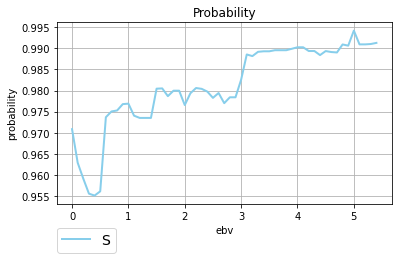

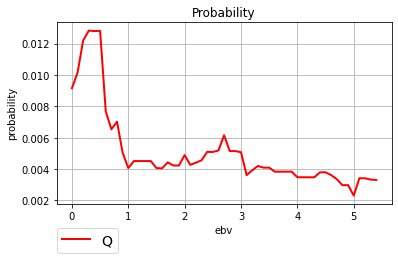

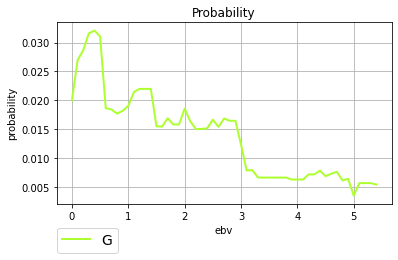

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4]


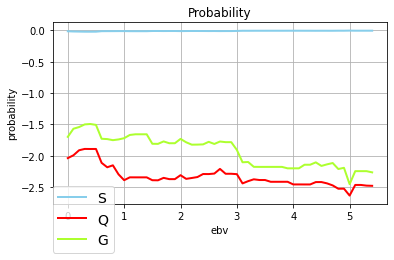

(1, 5.0)
tn
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4]


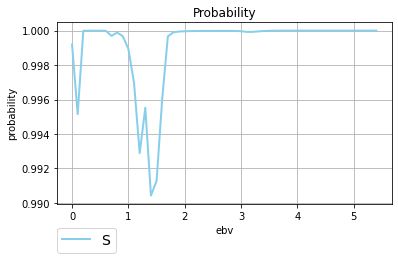

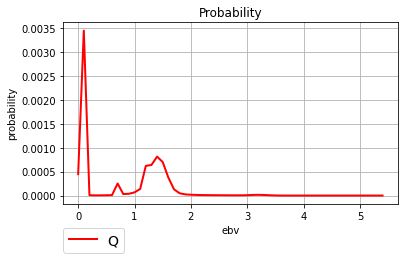

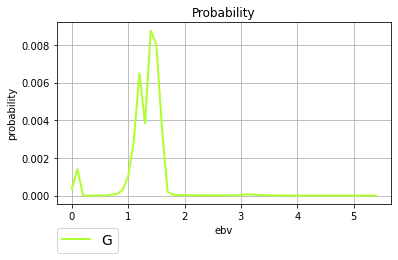

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4]


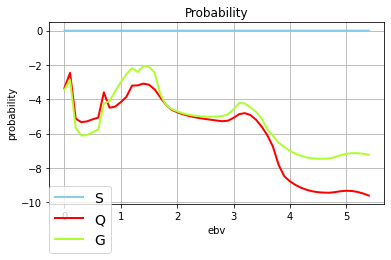

(1, 4.2)
gb_big_big
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4]


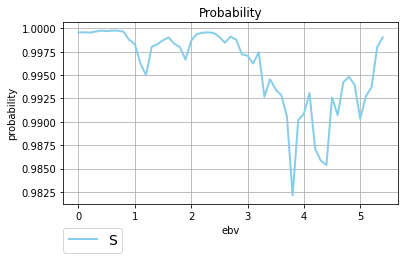

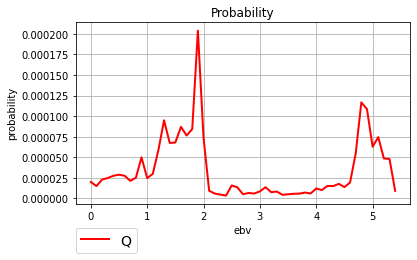

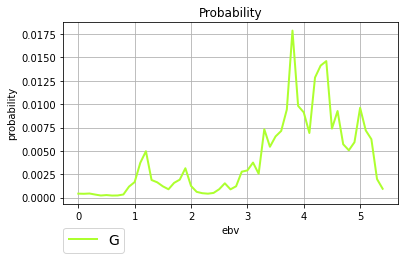

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4]


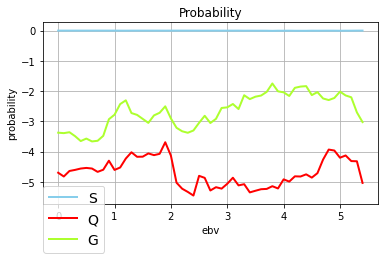

(1, 0.6000000000000001)
tn_big_big
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4]


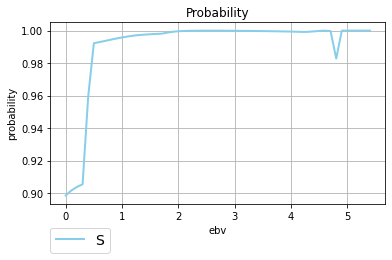

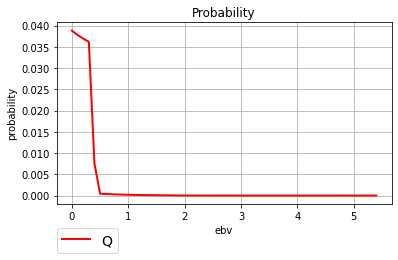

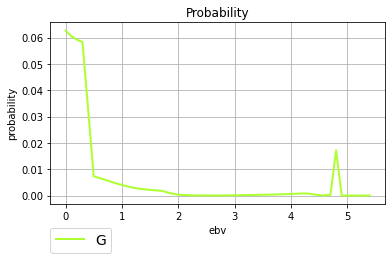

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4]


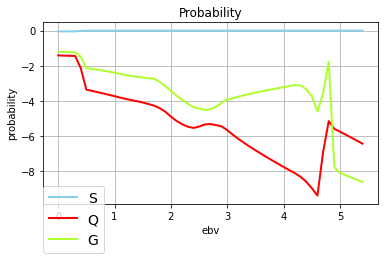

(1, 5.4)


In [67]:
model_mat = ['gb', 'tn', 'gb_big_big', 'tn_big_big']#, 'tn_big_big2', 'tn_big_and_little']
for i in range(1):

  obj = df_ap[(df_ap.ebv >= 4.0) & (df_ap.ebv <= 4.0115)]#df_ap[(df_ap['ebv'] >= 0.267980) & (df_ap['ebv'] <= 0.267991)]
  for model in model_mat:
    print('\033[1m' + model + '\033[0m')
    folder = f'{model}_on_StarHorse'#folder = f'{model}_on_target_Fx{vol1}<{vol2}'
    model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'

    model1 = joblib.load(f'{model_path}/model_'+overview+'.pkl')
    rob_mod = 'gb_big' if 'big_big' in model else 'gb' 
    robust = joblib.load(f'{model_path}/{overview}_robust_for_{rob_mod}.pkl') if 'gb' in model else None
    #path_for_all_model[model] = path
    ebv_probability_plot(obj, model1, f[overview], robust)
    ebv_probability_plot_log(obj, model1, f[overview], robust)
    print(ebv_probability_predict_one(obj, model1, f[overview], robust))

In [57]:
overview = 'sdssdr16+psdr2+all_decals8tr'
df_ap =APOGEE_DR16_StarHorse[f[overview]+['AV50']].dropna()
ebv = df_ap['AV50'].values / 3.1
df_ap['ebv'] = ebv

gb
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9]


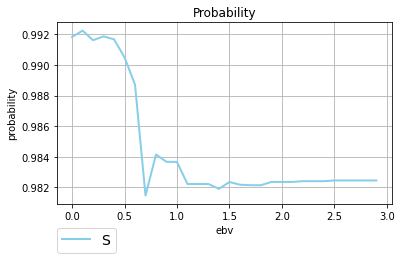

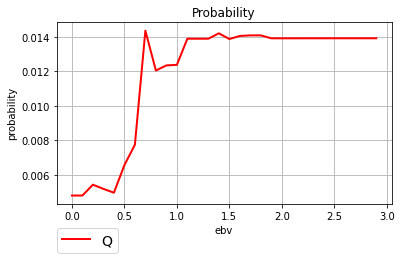

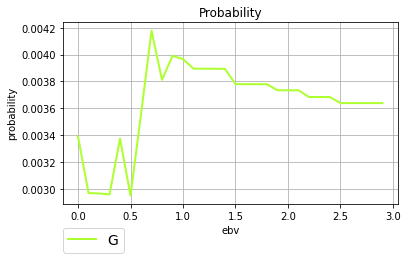

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9]


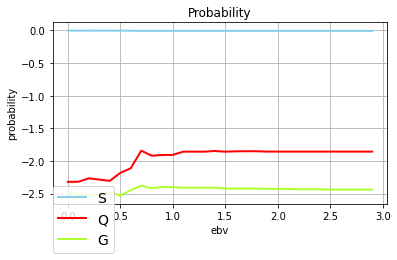

(1, 0.1)
tn
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9]


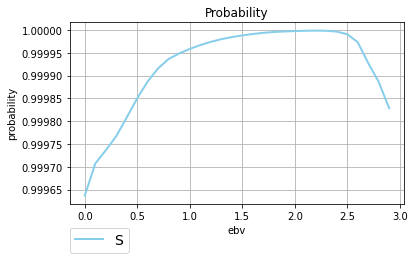

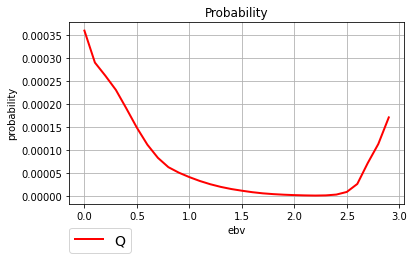

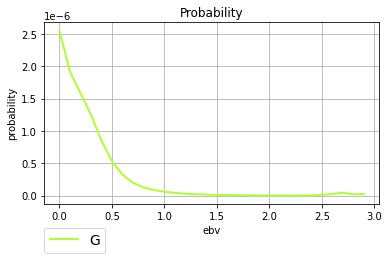

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9]


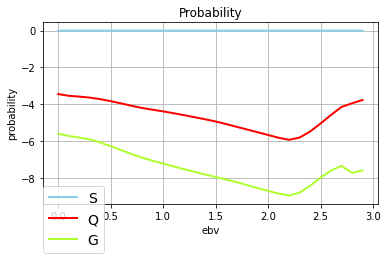

(1, 5.2)
gb_big_big
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9]


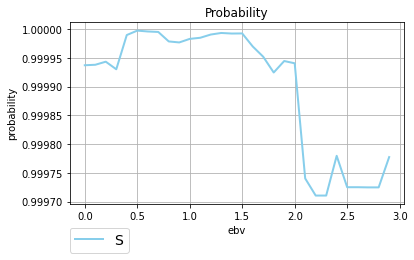

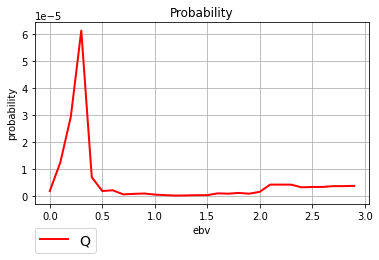

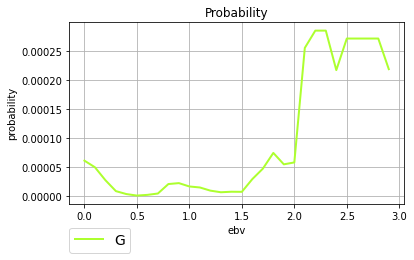

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9]


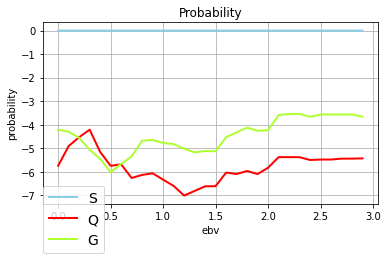

(1, 0.5)
tn_big_big
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9]


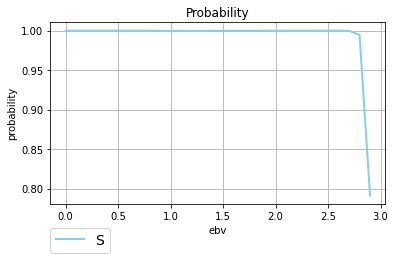

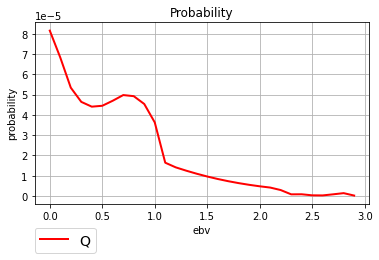

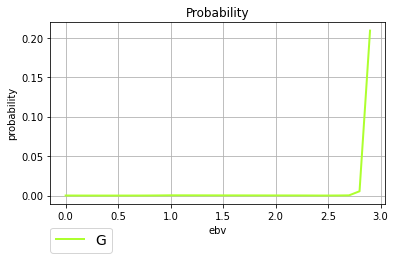

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9]


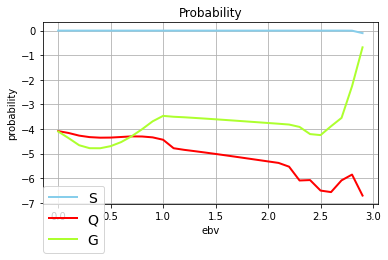

(1, 2.5)


In [65]:
model_mat = ['gb', 'tn', 'gb_big_big', 'tn_big_big']#, 'tn_big_big2', 'tn_big_and_little']
for i in range(1):

  obj = df_ap[(df_ap['ebv'] >= 0.267980) & (df_ap['ebv'] <= 0.267991)]
  for model in model_mat:
    print('\033[1m' + model + '\033[0m')
    folder = f'{model}_on_StarHorse'#folder = f'{model}_on_target_Fx{vol1}<{vol2}'
    model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'

    model1 = joblib.load(f'{model_path}/model_'+overview+'.pkl')
    rob_mod = 'gb_big' if 'big_big' in model else 'gb' 
    robust = joblib.load(f'{model_path}/{overview}_robust_for_{rob_mod}.pkl') if 'gb' in model else None
    #path_for_all_model[model] = path
    ebv_probability_plot(obj, model1, f[overview], robust, max=3.0)
    ebv_probability_plot_log(obj, model1, f[overview], robust, max=3.0)
    print(ebv_probability_predict_one(obj, model1, f[overview], robust))
    

In [50]:
def ebv_rec(df, model, features, true, r=None):
  from sklearn.metrics import recall_score
  data = df[features + [true]].dropna().copy()
  data1 = data[features]
  y = data[true].values
  graf = []
  #X = data1.values
  for ebv in np.arange(0.0, 4.0, 0.1):
    obj = data1.copy()
    add_ebv(obj, ebv)
    X = obj.values
    if r is not None:
      X = r.transform(X)
    rec = recall_score(y, model.predict(X), average=None)
    graf.append([ebv, rec[0], rec[1], rec[2]])
    
  lab =['S', 'Q', 'G']
  graf = np.array(graf)
  lines = []
  labels = []
  clr = ['skyblue', 'red', 'greenyellow', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'lime', 'springgreen', 'aquamarine', 'aqua',  'lightskyblue']
  for j in range(3):
    l, = plt.plot(graf[:, 0], graf[:, j+1], color=clr[j], lw=2)
    lines.append(l)
    labels.append(lab[j])
  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel(column)
  #plt.xlim(15.5, 23)
  plt.ylim(0.3, 1.01)
  plt.ylabel('Recall')
  plt.title('Recall E(b-v)')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
  #if file_name is not None:
  
  #  plt.savefig(file_name+'F1.png')
  plt.show()
    

'''
  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel(column)
  #plt.xlim(15.5, 23)
  #plt.ylim(0.5, 1.01)
  plt.ylabel('probability')
  plt.title('Probability')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
  #if file_name is not None:
  #  plt.savefig(file_name+'F1.png')
  plt.show()
'''

"\n  fig = plt.gcf()\n  fig.subplots_adjust(bottom=0.25)\n  plt.xlabel(column)\n  #plt.xlim(15.5, 23)\n  #plt.ylim(0.5, 1.01)\n  plt.ylabel('probability')\n  plt.title('Probability')\n  plt.grid(True)\n  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))\n  #if file_name is not None:\n  #  plt.savefig(file_name+'F1.png')\n  plt.show()\n"

In [115]:
def ebv_acc(df, model, features, true, r=None):
  from sklearn.metrics import accuracy_score
  column = 'sdssdr16_r_cmodel'
  data = df[[column]+features + [true]].dropna().copy()
  data1 = data[[column]+features]
  y = data[true].values
  graf = []
  ind1 = data1[column] < 20
  ind2 = data1[column] > 20
  #X = data1.values
  for ebv in np.arange(0.0, 4.0, 0.1):
    obj = data1[features].copy()
    add_ebv(obj, ebv)
    X1 = obj[ind1].values
    X2 = obj[ind2].values
    if r is not None:
      X1 = r.transform(X1)
      X2 = r.transform(X2)
    acc = [accuracy_score(y[ind1], model.predict(X1)), accuracy_score(y[ind2], model.predict(X2))]
    graf.append([ebv, acc[0], acc[1]])
    
  lab =['sdssdr16_r_cmodel < 20', 'sdssdr16_r_cmodel > 20']
  graf = np.array(graf)
  lines = []
  labels = []
  clr = ['skyblue', 'red', 'greenyellow', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'lime', 'springgreen', 'aquamarine', 'aqua',  'lightskyblue']
  for j in range(len(lab)):
    l, = plt.plot(graf[:, 0], graf[:, j+1], color=clr[j], lw=2)
    lines.append(l)
    labels.append(lab[j])
  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel('E(b-v)')
  #plt.xlim(15.5, 23)
  plt.ylim(0.7, 1.01)
  plt.ylabel('Acc')
  plt.title('Acc E(b-v)')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.42), prop=dict(size=14))
  #if file_name is not None:
  
  #  plt.savefig(file_name+'F1.png')
  plt.show()
    

'''
  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel(column)
  #plt.xlim(15.5, 23)
  #plt.ylim(0.5, 1.01)
  plt.ylabel('probability')
  plt.title('Probability')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
  #if file_name is not None:
  #  plt.savefig(file_name+'F1.png')
  plt.show()
'''

"\n  fig = plt.gcf()\n  fig.subplots_adjust(bottom=0.25)\n  plt.xlabel(column)\n  #plt.xlim(15.5, 23)\n  #plt.ylim(0.5, 1.01)\n  plt.ylabel('probability')\n  plt.title('Probability')\n  plt.grid(True)\n  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))\n  #if file_name is not None:\n  #  plt.savefig(file_name+'F1.png')\n  plt.show()\n"

In [236]:
model1

TabNetClassifier(n_d=32, n_a=32, n_steps=4, gamma=2.3696685979745844, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=3, n_shared=3, epsilon=1e-15, momentum=0.02, lambda_sparse=0.00837486406175253, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 200, 'gamma': 0.95}, mask_type='entmax', input_dim=42, output_dim=3, device_name='auto')

In [237]:
obj = df_ap[(df_ap['ebv'] >= 0.267980) & (df_ap['ebv'] <= 0.267991)]

In [ ]:
ebv_probability_plot(obj, model1, f['sdssdr16+psdr2+all_decals8tr'])

In [ ]:
f['sdssdr16+psdr2+all_decals8tr']

[1.0000000e+00 8.5374896e-10 2.5111231e-16]
[1.0000000e+00 7.7741996e-10 2.0400495e-16]
[1.000000e+00 7.079340e-10 1.657018e-16]
[1.0000000e+00 6.4467465e-10 1.3456156e-16]
[1.0000000e+00 5.8708260e-10 1.0925098e-16]
[1.0000000e+00 5.3464577e-10 8.8680591e-17]
[1.000000e+00 4.869054e-10 7.196739e-17]
[1.0000000e+00 4.4044993e-10 5.8252070e-17]
[1.0000000e+00 3.8936204e-10 4.6761347e-17]
[1.0000000e+00 3.4418801e-10 3.7526954e-17]
[1.0000000e+00 3.0440545e-10 3.0122599e-17]
[1.0000000e+00 2.7566910e-10 2.4723318e-17]
[1.0000000e+00 2.5406971e-10 2.0628756e-17]
[1.0000000e+00 2.2090765e-10 1.6484366e-17]
[1.0000000e+00 5.8867483e-10 2.5743598e-18]
[1.0000000e+00 5.3460214e-09 1.0745338e-17]
[1.0000000e+00 8.8927905e-09 3.8142317e-19]
[1.0000000e+00 2.1457446e-08 1.3956443e-20]
[1.0000000e+00 2.3673842e-08 8.1289832e-23]
[9.9999797e-01 2.0640266e-06 2.4224406e-29]
[9.9999762e-01 2.4051894e-06 3.4898253e-32]
[9.9999666e-01 3.3041154e-06 4.0319984e-35]
[9.9999654e-01 3.4751083e-06 2.1911443

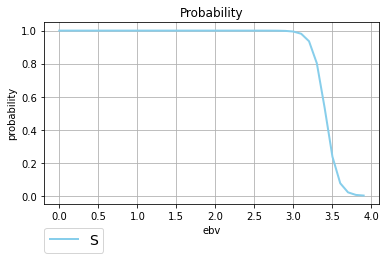

In [225]:
  r = None
  model = model1
  feature = f['sdssdr16+psdr2+all_decals8tr']
  data = obj[feature].dropna().copy()
  if data.shape[0] > 1:
    print('Я могу что-то сделать только для одного объекта, а вы мне даете сразу '+str(data.shape[0]))
    exit()
  if data.shape[0] < 1:
    print('Давайте жить дружно! Мне нужен один объект, а вы мне даете '+str(data.shape[0])+'. Проверьте, есть ли признаки для этого объекта <3')
    exit()
  
  graf = []
  for ebv in np.arange(0.0, 4.0, 0.1):
    obj = data.copy()
    add_ebv(obj, -ebv)
    X = obj.values
    if r is not None:
      X = r.transform(X)
    res = model.predict_proba(X)[0]
    print(res)
    graf.append([ebv, res[0], res[1], res[2]])
    
  lab =['S', 'Q', 'G']
  graf = np.array(graf)
  print(graf[:, 0])
  lines = []
  labels = []
  clr = ['skyblue', 'red', 'greenyellow', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'lime', 'springgreen', 'aquamarine', 'aqua',  'lightskyblue']
  for j in range(3):
    l, = plt.plot(graf[:, 0], graf[:, j+1], color=clr[j], lw=2)
    lines.append(l)
    labels.append(lab[j])
    break


  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlabel(column)
  #plt.xlim(15.5, 23)
  #plt.ylim(0.5, 1.01)
  plt.ylabel('probability')
  plt.title('Probability')
  plt.grid(True)
  plt.legend(lines, labels, loc=(0, -0.27), prop=dict(size=14))
  #if file_name is not None:
  #  plt.savefig(file_name+'F1.png')
  plt.show()

##Тест на выборке из 15 тыс рентгеноских объектах 

In [90]:
column = 'sdssdr16_r_cmodel'
data = 'little'

In [91]:
import gzip
import pickle
#classes = {'STAR': 1, 'QSO':2, 'GALAXY':3}


path = '/content/drive/MyDrive/Научная работа/Data/X-ray/cv0.gz_pkl'#'/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_0/cv0.gz_pkl'
with gzip.open(path, 'rb') as fin:
    df1 = pickle.load(fin)
    df1 = df1[[column] + features + ['class']].dropna()

path = '/content/drive/MyDrive/Научная работа/Data/X-ray/cv1.gz_pkl'#'/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_1/cv1.gz_pkl'
with gzip.open(path, 'rb') as fin:
    df2 = pickle.load(fin)
    df2= df2[[column] + features + ['class']].dropna()

gb


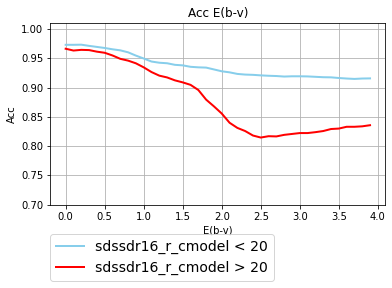

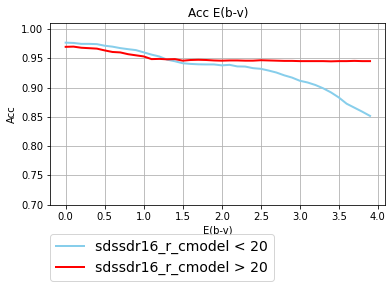

tn


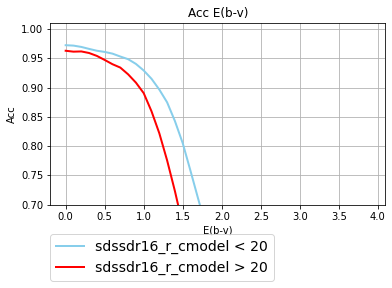

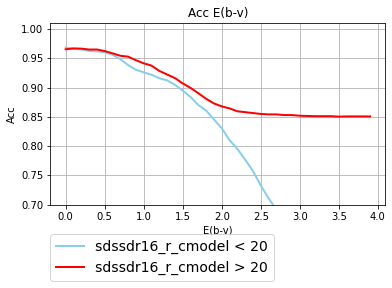

In [116]:
for model in ['gb', 'tn']:

  print('\033[1m' + model + '\033[0m')
  
  model1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
  robust1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')

  model2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
  robust2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')

  ebv_acc(df2, model1, f[overview], 'class', r=robust1)
  ebv_acc(df1, model2, f[overview], 'class', r=robust2)

gb_big_big


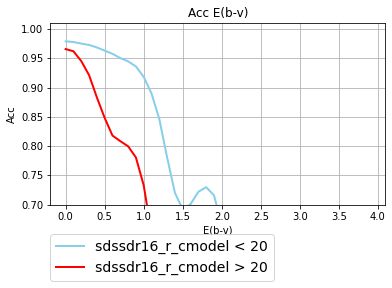

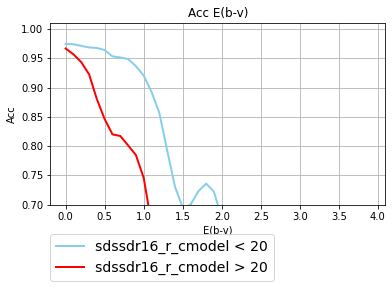

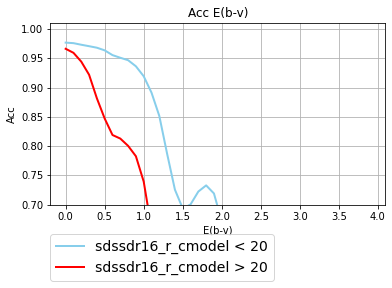

tn_big_big


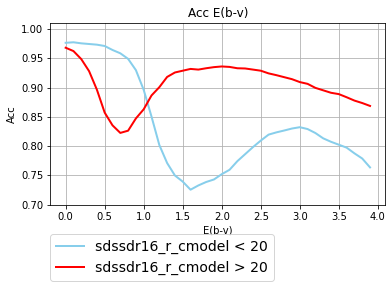

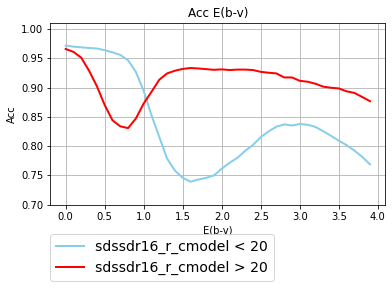

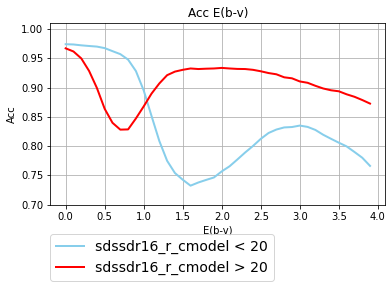

tn_big_big2


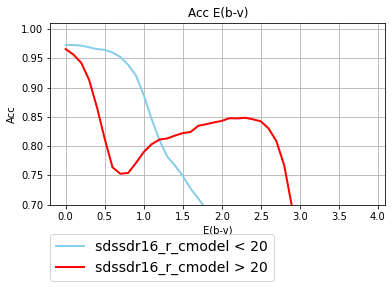

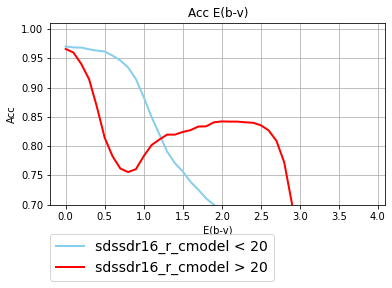

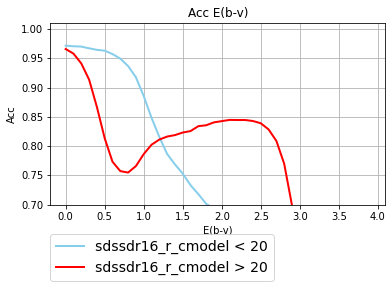

tn_big_and_little


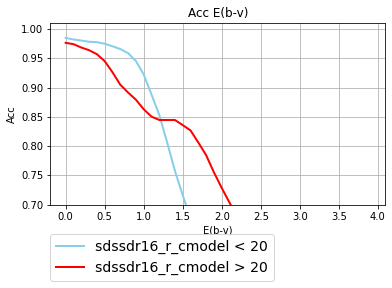

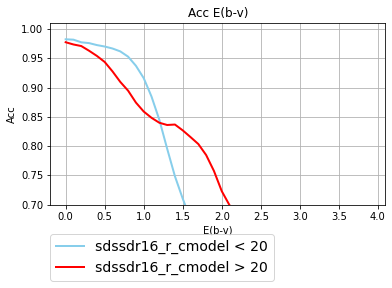

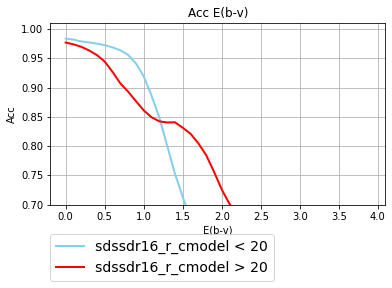

In [117]:
model_mat = ['gb_big_big', 'tn_big_big', 'tn_big_big2', 'tn_big_and_little']
for model in model_mat:

  print('\033[1m' + model + '\033[0m')
  model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
  
  model1 = joblib.load(f'{model_path}/model_'+overview+'.pkl')
  rob_mod = 'gb_big' if 'big_big' in model else 'gb' 
  robust1 = joblib.load(f'{model_path}/{overview}_robust_for_{rob_mod}.pkl') if 'gb' in model else None

  ebv_acc(df1, model1, f[overview], 'class', r=robust1)
  ebv_acc(df2, model1, f[overview], 'class', r=robust1)
  ebv_acc(pd.concat((df1,df2)), model1, f[overview], 'class', r=robust1)

## Тест на большой выборке

In [118]:
column = 'sdssdr16_r_cmodel'
data = 'big'

In [119]:
import gzip
import pickle
classes = {'STAR': 1, 'QSO':2, 'GALAXY':3}


path = '/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_0/cv0.gz_pkl'
with gzip.open(path, 'rb') as fin:
    df1 = pickle.load(fin)
    df1 = df1[[column] + features + ['class']].dropna()
    #subclass1 = df1['zspec']
    df1 = df1[[column] + features + ['class']]


In [120]:
path = '/content/drive/MyDrive/Научная работа/Data/Main/data/cv0_1/cv1.gz_pkl'
with gzip.open(path, 'rb') as fin:
    df2 = pickle.load(fin)
    df2 = df2[[column] + features + ['class']].dropna()
    #subclass2 = df2['zspec']
    df2 = df2[[column] + features + ['class']]

In [121]:
df1.replace({'class':classes}, inplace = True)
df2.replace({'class':classes}, inplace = True)

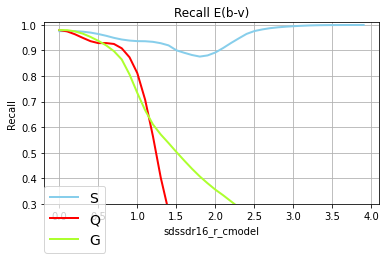

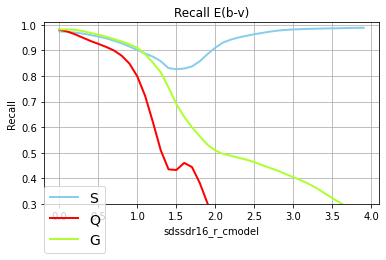

In [297]:
  model = 'gb_big'

  model1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')
  robust1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')

  model2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')
  robust2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')

  ebv_acc(df2, model1, f[overview], 'class', r=robust1)
  ebv_acc(df1, model2, f[overview], 'class', r=robust2)

In [298]:
overview

'sdssdr16+psdr2+all_decals8tr'

In [70]:
df1.shape

(650803, 67)

Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_on_big уже существует
Директория /content/drive/MyDrive/Научная работа/Data/X-ray/plots/tn_big_on_big/sdssdr16+psdr2+all_decals8tr уже существует
sdssdr16+psdr2+all_decals8tr


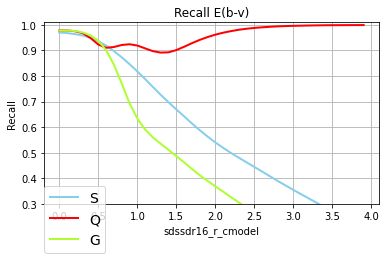

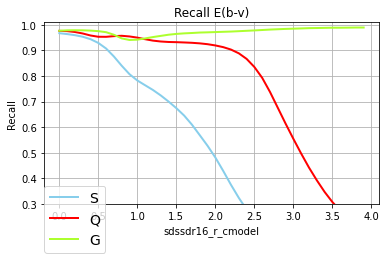

In [71]:
model = 'tn_big'

import os
path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}"

try:
    os.makedirs(path)
except FileExistsError:
  print("Директория %s уже существует" % path) 
except OSError:
    print ("Создать директорию %s не удалось" % path)
    exit()

for overview in ['sdssdr16+psdr2+all_decals8tr']:
  path = f"/content/drive/MyDrive/Научная работа/Data/X-ray/plots/{model}_on_{data}/{overview}"
  try:
      os.makedirs(path)
  except FileExistsError:
    print("Директория %s уже существует" % path)
  except OSError:
      print("Создать директорию %s не удалось" % path)
      exit()

  print(overview)
  '''

  X1, y1 = df1[[column]+f[overview]].values, df1['class'].values #.replace({'class':classes}, inplace = True)
  X2, y2 = df2[[column]+f[overview]].values, df2['class'].values

  
  m = globals()[f"For_one_{model[:2]}"]
  model1, robust1 = m(X1[:, 1:], y1, X2[:, 1:], y2)
  model2, robust2 = m(X2[:, 1:], y2, X1[:, 1:], y1)

  joblib.dump(model1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')#были обучены на маленьком датасете 
  joblib.dump(robust1, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')
  #joblib.dump([X1, y1], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_1.pkl')


  joblib.dump(model2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')#были обучены на маленьком датасете 
  joblib.dump(robust2, f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')
  #joblib.dump([X2, y2], f'/content/drive/MyDrive/Научная работа/Data/X-ray/{overview}_Xy_{data}_2.pkl')
  '''
  model1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_1.pkl')
  robust1 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_1.pkl')

  model2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/model_{overview}_2.pkl')
  robust2 = joblib.load(f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}/{overview}_robust_for_{model}_2.pkl')


  
  #ZG_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=f'{path}/{overview}_{model}_', N=3)
  #ZQ_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=f'{path}/{overview}_{model}_', N=3)

  #SubClass_plot(X1, y1, X2, y2, subclass1, subclass2, model1, model2, robust1, robust2, column, file_name=f'{path}/{overview}_{model}_', N=6)
  ebv_acc(df2, model1, f[overview], 'class', r=robust1)
  ebv_acc(df1, model2, f[overview], 'class', r=robust2)

gb


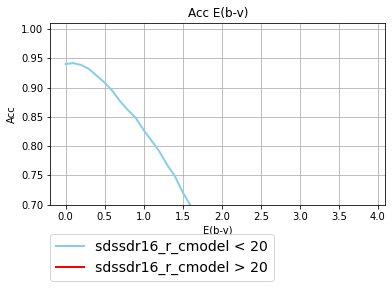

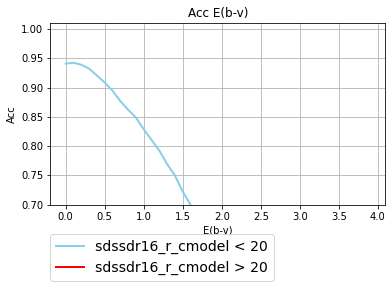

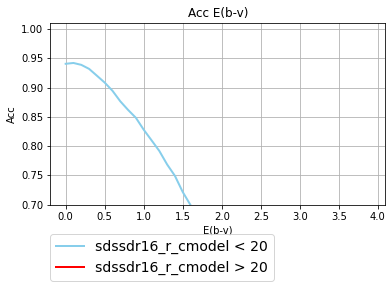

tn


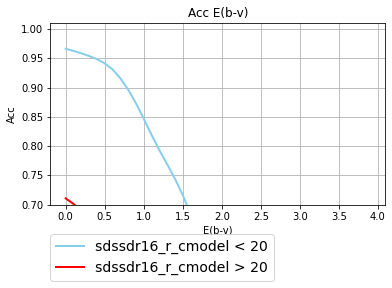

KeyboardInterrupt: ignored

In [122]:
model_mat = ['gb', 'tn']
for model in model_mat:

  print('\033[1m' + model + '\033[0m')
  model_path = f'/content/drive/MyDrive/Научная работа/Data/X-ray/{model}'
  
  model1 = joblib.load(f'{model_path}/model_'+overview+'.pkl')
  rob_mod = 'gb_big' if 'big_big' in model else 'gb' 
  robust1 = joblib.load(f'{model_path}/{overview}_robust_for_{rob_mod}.pkl') if 'gb' in model else None

  #ebv_acc(df1, model1, f[overview], 'class', r=robust1)
  #ebv_acc(df2, model1, f[overview], 'class', r=robust1)
  ebv_acc(pd.concat((df1,df2)), model1, f[overview], 'class', r=robust1)


#Далее

In [ ]:
X1.shape, X2.shape

((8480, 17), (8480, 17))

In [ ]:
X_train.shape

(6336, 65)

In [ ]:
gb = lgb.LGBMClassifier()
t = time()
gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_test_norm, y_test)],  **lgb_fit_params)
print(time()-t)

1.1678180694580078


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.97      0.96      0.96       116
           2       0.98      0.98      0.98       399
           3       0.98      0.96      0.97       190

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705

Confusion Matrix: 
 [[111   4   1]
 [  3 393   3]
 [  1   6 183]]
Training Score:  0.9970012626262627
Testing Score:  0.9744680851063829


In [ ]:
pred = gb.predict(X2_norm)
print('Classification Report: \n', classification_report(y2, pred))
print('Confusion Matrix: \n', confusion_matrix(y2, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y2, pred)
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.99      0.99      0.99      1152
           2       1.00      1.00      1.00      3989
           3       0.99      0.99      0.99      1900

    accuracy                           0.99      7041
   macro avg       0.99      0.99      0.99      7041
weighted avg       0.99      0.99      0.99      7041

Confusion Matrix: 
 [[1142    7    3]
 [   5 3974   10]
 [   1   11 1888]]
Training Score:  0.9970012626262627
Training Score:  0.9947450646215026


In [ ]:
X_train.shape, X_test.shape

((6340, 65), (706, 65))

In [ ]:
clf = TabNetClassifier(n_d=32, n_a=32,
                       momentum=0.7,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":20, # how to use learning rate scheduler
                                         "gamma":0.95},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,

                       mask_type='entmax',
                       
                       **{'gamma': 1.7,
                          'lambda_sparse': 0.001,
                          'n_steps': 5}

)

Device used : cuda


In [ ]:
max_epochs = 300

In [ ]:
X_train.shape

(6336, 65)

In [ ]:
X_test.shape

(705, 65)

In [ ]:
t = time()
clf.fit(
    X_train=X_train, y_train=y_train,
    #X_valid=X_valid, y_valid=y_valid,
    eval_set=[(X_train, y_train), (X_train, y_train)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','accuracy'],
    max_epochs=max_epochs , patience=50,
    batch_size=512, virtual_batch_size=128,
    #from_unsupervised=unsupervised_model
) 
print(time()-t)

epoch 0  | loss: 0.96442 | train_logloss: 5.35252 | train_accuracy: 0.42551 | valid_logloss: 5.35252 | valid_accuracy: 0.42551 |  0:00:00s
epoch 1  | loss: 0.32988 | train_logloss: 2.74    | train_accuracy: 0.64378 | valid_logloss: 2.74    | valid_accuracy: 0.64378 |  0:00:01s
epoch 2  | loss: 0.27342 | train_logloss: 3.26327 | train_accuracy: 0.41525 | valid_logloss: 3.26327 | valid_accuracy: 0.41525 |  0:00:02s
epoch 3  | loss: 0.2023  | train_logloss: 9.63578 | train_accuracy: 0.34501 | valid_logloss: 9.63578 | valid_accuracy: 0.34501 |  0:00:03s
epoch 4  | loss: 0.19852 | train_logloss: 3.86725 | train_accuracy: 0.41177 | valid_logloss: 3.86725 | valid_accuracy: 0.41177 |  0:00:04s
epoch 5  | loss: 0.16243 | train_logloss: 2.8799  | train_accuracy: 0.65025 | valid_logloss: 2.8799  | valid_accuracy: 0.65025 |  0:00:05s
epoch 6  | loss: 0.18096 | train_logloss: 0.91737 | train_accuracy: 0.79419 | valid_logloss: 0.91737 | valid_accuracy: 0.79419 |  0:00:06s
epoch 7  | loss: 0.15446 | 

In [ ]:
X_test = X_test.astype('float')

In [ ]:
pred = clf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
clf_train_acc = accuracy_score(y_train, clf.predict(X_train.astype('float')))
print('Training Score: ', clf_train_acc)
clf_test_acc = accuracy_score(y_test, pred)
print('Testing Score: ', clf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.99      0.96      0.97       116
           2       0.98      0.98      0.98       399
           3       0.95      0.96      0.95       190

    accuracy                           0.97       705
   macro avg       0.97      0.96      0.97       705
weighted avg       0.97      0.97      0.97       705

Confusion Matrix: 
 [[111   2   3]
 [  1 391   7]
 [  0   8 182]]
Training Score:  0.9924242424242424
Testing Score:  0.9702127659574468


In [ ]:
pred = clf.predict(X2)
print('Classification Report: \n', classification_report(y2, pred))
print('Confusion Matrix: \n', confusion_matrix(y2, pred))
clf_train_acc = accuracy_score(y_train, clf.predict(X_train.astype('float')))
print('Training Score: ', clf_train_acc)
clf_test_acc = accuracy_score(y2, pred)
print('Training Score: ', clf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.99      0.99      1152
           2       0.99      0.99      0.99      3989
           3       0.98      0.99      0.99      1900

    accuracy                           0.99      7041
   macro avg       0.99      0.99      0.99      7041
weighted avg       0.99      0.99      0.99      7041

Confusion Matrix: 
 [[1139    7    6]
 [   5 3954   30]
 [   0   21 1879]]
Training Score:  0.9924242424242424
Training Score:  0.9902002556455048


In [ ]:
lgb_fit_params = {
    'early_stopping_rounds': 20,
    'verbose': False
}
lgb_class_params = {
    'min_child_samples':np.random.randint(1, 50, size = 5),
    'colsample_bytree': np.random.uniform(0.1, 0.9, size = 5),
    'num_leaves' :      np.random.randint(10, 100, size = 5),
    'min_child_weight': np.random.uniform(0.001, 0.99, size = 5),
}

kf = KFold(n_splits=3)

LGBM = RandomizedSearchCV(LGBMClassifier(learning_rate=0.001, n_estimators=300), lgb_class_params, random_state=0, cv=kf)
search = LGBM.fit(X_train_norm, y_train)

In [ ]:
X_test.shape

(8669, 26)

In [ ]:
len(gb.feature_importances_)

26

In [ ]:
np.where(gb.feature_importances_ == 366)[0].tolist()

[]

In [ ]:
[columns_sdss[i] for i in np.where(gb.feature_importances_ == 930)[0].tolist()]

['sdssdr16_u-z_psf']

In [ ]:
columns_not_ls = [i for i in columns_not_L if 'ls' not in i]

In [ ]:
columns_not_Err =  [i for i in columns if 'Err' not in i]

In [ ]:
columns_not_Ivar = [i for i in columns_not_Err if 'Ivar' not in i]

In [ ]:
columns_not_w = [i for i in columns_not_Ivar if 'w' not in i]

In [ ]:
columns_sdss = [i for i in columns_not_Ivar if 'sdss' in i] + ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [ ]:
columns_not_z = [i for i in columns_sdss if 'z' not in i]

In [ ]:
columns_not_z

['sdss_cModelFlux_u',
 'sdss_cModelFlux_g',
 'sdss_cModelFlux_r',
 'sdss_cModelFlux_i',
 'sdss_psfFlux_u',
 'sdss_psfFlux_g',
 'sdss_psfFlux_r',
 'sdss_psfFlux_i',
 'sdssdr16_u_psf',
 'sdssdr16_g_psf',
 'sdssdr16_r_psf',
 'sdssdr16_i_psf',
 'sdssdr16_u_cmodel',
 'sdssdr16_g_cmodel',
 'sdssdr16_r_cmodel',
 'sdssdr16_i_cmodel',
 'sdssdr16_u-g_psf',
 'sdssdr16_u-r_psf',
 'sdssdr16_u-i_psf',
 'sdssdr16_u_psf-cmodel',
 'sdssdr16_g-r_psf',
 'sdssdr16_g-i_psf',
 'sdssdr16_g_psf-cmodel',
 'sdssdr16_r-i_psf',
 'sdssdr16_r_psf-cmodel',
 'sdssdr16_i_psf-cmodel',
 'LabelQ',
 'LabelG',
 'LabelS',
 'Label']